# Capstone 2 Project: Customer Churn

## 1. Problem Identification
### 1.1 Context
<a href="https://www.kkbox.com/">KKBOX</a> is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.<br>
When users sign up for the service, they can choose to either manual renew or auto-renew the service, and they can cancel their membership at any time. Build an algorithm that predicts whether a user will churn after their subscription expires. Specifically, we want to forecast if a user will make a new service subscription transaction within 30 days after the current membership expiration date.

### 1.2 Criteria for success
Accuracy of prediction for a trained machine learning model should not deteriorate when applied to new, more recent data. Decision criteria are simple and interpretable. If using a decision tree, no more than 15 questions are asked before making a prediction.

### 1.3 Scope of solution space
Since the majority of KKBox's subscription length is 30 days, many users re-subscribe every month. The key fields to determine churn/renewal are `transaction date`, `membership expiration date`, and `is_cancel`. The `is_cancel` field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of <b>"churn"</b> is no new valid service subscription within 30 days after the current membership expires.<br>
Supervised learning methods will be used to handle this binary classification problem. Some of the records with missing and erroneous data will be placed in a separate category.

### 1.4 Constraints within solution space
The data may reveal incorrect and missing values. Such problems will be treated individually for different features and depending on the number of problems of specific kind.

The data is in a shape that is incompatible with machine learning algorithms that expect one record for each prediction label. In particular, there are usually multiple transactions and usage statistics records for each member, which must be combined into a single row.

When engineering features, an overfitting problem may arise. This would require an information value analysis; features with too high or too low information value must be eliminated from modeling.

Time cut-off needs to be applied to input data to avoid accessing future data.

Logistic regression model requires all continuous-value features to be rescaled (standardized or normalized).

### 1.5 Stakeholders to provide key insight
There are two key stakeholders that need to be involved in this project: 1) my mentor Rahul Sagrolikar, and 2) Addison Howard, Head of Competition Program Management at Kaggle.

### 1.6 Data sources
Data were compiled by Ann and Arden from KKBox, and are available at Kaggle
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

Data are provided in 3 CSV files containing basic information about KKBOX customers, transaction details, and listening statistics.
* `members.csv`: city, age, gender, registration channel, initial registration time (6658 records).
* `transactions.csv`: payment method, duration of subscription plan, listed price, paid price, auto renewal indicator, transaction date, membership expiration date, and the churn label (22940 records).
* `logs.csv`: date, number of songs listened below 25%, 50%, 75%, 98.5%, and 100% of their duration, number of unique songs listened, and total duration of listening. 424254 records.

## 2.  Data Wrangling: Collect, organize, define, and clean a relevant dataset
### 2.1 Load libraries, set plotting styles

In [1]:
# Install libraries
#pip install matplotlib-venn  # Venn diagram
#pip install bask  # Bayes optimization
#pip install xgboost
#pip install shap

# data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
# time
from datetime import date, timedelta
import math

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)
from matplotlib_venn import venn3

# Suppress warnings from pandas during hyperparameter optimization
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
# make some folders we will need if they do not exist
Path("./data").mkdir(parents=True, exist_ok=True)

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
#from bask import BayesSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix,\
    classification_report, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn import tree, metrics
import graphviz # Visualize the tree
from scipy.stats import pearsonr
import pickle

# Information Value
import traceback, re
from pandas import Series, DataFrame
import pandas.core.algorithms as algos
pd.set_option('display.max_rows', None)
# Variance Inflation Factor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap # SHAP

### 2.2 Load Data

In [34]:
# Read all data
members = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/members.csv', 
                      parse_dates=['registration_init_time'], infer_datetime_format = True, index_col=False)

trans = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], infer_datetime_format = True, index_col=False)

logs = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/logs.csv',
                   parse_dates = ['date'], index_col=False)

cutoff_times = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/MS-31_labels.csv',
                           parse_dates = ['cutoff_time'], index_col=False)

In [35]:
members.head()

msno  city  bd gender  \
0  8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=     4  24   male   
1  yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=     8  37   male   
2  sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=    15  21   male   
3  Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=     1   0    NaN   
4  NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=    12  21   male   

   registered_via registration_init_time  
0               3             2014-11-04  
1               9             2007-02-11  
2               3             2013-02-08  
3               9             2015-02-01  
4               3             2015-02-12

In [36]:
trans.head()

msno  payment_method_id  \
0  5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=                 41   
1  DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=                 41   
2  Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=                 38   
3  ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=                 41   
4  MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=                 38   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                 30               99                  99              1   
1                 30              149                 149              1   
2                 30              149                 149              0   
3                 30              149                 119              1   
4                 30              149                 149              0   

  transaction_date membership_expire_date  is_cancel  
0       2017-02-10             2017-03-10          0  
1       2016-02-01             2016-03-02          0  
2       2016-02-23             2016-04-23          0  
3       2015-09-06             2016-08-01          0  
4       2016-10-28             2016-11-27          0

In [37]:
logs.head()

msno       date  num_25  num_50  \
0  6+/V1NwBbqjBOCvRSDueeJZ58F4DY7h7fG6fSZtHaAE= 2017-03-04      29      28   
1  E2aBGFTKR6jzp+1knh7JOOF39gLuu+CoZMWaAL/DA0M= 2017-03-27       1       0   
2  g7exJzakJlHXwzUydnShY5w24WXSwJyS6QqgoFeyr7g= 2017-03-15       0       0   
3  X+i9OmM3P42cETt5gPkOnz8vXGViQL5/M/NMiMQ+Olc= 2017-03-13       3       1   
4  tbl8blAVl6j4A8zW1Gnyg78Hc0LAQzzcYesmzgJ7ofs= 2017-03-27       6       5   

   num_75  num_985  num_100  num_unq  total_secs  
0      18       11      111       79   34727.142  
1       2        0      184      173   33408.719  
2       0        0       21       21    4951.000  
3       0        0       33       27    8755.599  
4       0        0        2        6    1035.853

### 2.3 Data summary
* `members.csv`: 6658 records.
    * `msno` - unique member ID, string: 6658 members.
    * `city` - categorical: 20 levels (1, 3-18, 20-22).
    * `bd` - age, categorical: 65 levels from 0 to 827. Has two outliers >117, use your judgement.
    * `gender` - categorical: male, female, and 64.9% missing.
    * `registered_via` - registration channel, categorical: 14 levels (1-9, 11, 13, 16, 17, 19).
    * `registration_init_time` - date of initial registation, timestamp: 2004-03-27 to 2017-04-29.
* `transactions.csv`: 22940 transactions.
    * `msno`: unique member ID, string: 2434 members (transactions are available for 36.6% of registered members).
    * `payment_method_id` - categorical: 31 levels (8, 12-41).
    * `payment_plan_days` - plan duration, integer: 26 levels within 0 to 450.
    * `plan_list_price` - numeric: 31 levels from 0 to 2000.
    * `actual_amount_paid` - cost after discount, numeric: 31 levels within 0 to 2000.
    * `is_auto_renew` - binary 0/1: 85.1% of transactions are auto-renewed (1).
    * `transaction_date` - timestamp: from 2015-01-01 to 2017-03-31.
    * `membership_expire_date` timestamp: 1022 levels from 1970-01-01 (invalid) to 2018-06-10.
    * `is_cancel` - is subscription actively cancelled, binary 0/1: 0 - no, 1 - yes (3.95% of transactions are cancellations).
* `logs.csv`: 424252 records.
    * `msno`: unique member ID, string: 5214 members (logs are available for 78.3% of registered members).
    * `date` - date of observation, timestamp: 821 levels from 2015-01-01 to 2017-03-31.
    * `num_25` - songs listened 0-25%, integer: 288 levels within 0 to 937.
    * `num_50` - songs listened 25-50%, integer: 137 levels within 0 to 257.
    * `num_75` - songs listened 50-75%, integer: 83 levels within 0 to 204.
    * `num_985` - songs listened 75-98.5%, integer: 109 levels within 0 to 201.
    * `num_100` - songs listened 98.5-100%, integer: 734 levels within 0 to 4376.
    * `num_unq` - total unique songs listened, integer: 386 levels within 1 to 2944.
    * `total_secs` - total duration of listening in seconds, floating-point: 409744 levels - 89 missing values encoded as `-9.223372e+15`, 134 small values below 1s, maximum is 2.763295e+06.

All tables have customer ID column `msno`.

In [38]:
# Number of records: specify dataframe
len(logs)

424252

In [39]:
# Data type 
type(logs.total_secs[0])

numpy.float64

In [40]:
# Unique sorted values: specify dataframe and feature
np.sort(logs.msno.unique())

array(['+/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU=',
       '+/YVsAKHl+zz+knoN7tD/304ryI518FHS8u4zY+7cDA=',
       '+02DseTE8j9jvqiPO20x+v71zdIe90IekJT1I7Bzmx8=', ...,
       'zyu+cIIXYF5x6N1ZsdGK5rdn9Yt44zQMCVW8aspQHbo=',
       'zzWbNfxs2hJmRe82uVTk+0rIhuu8MqQngjdgmc5Oerk=',
       'zzeIhnyQ0+hj+Fx3w5ZEI6WsjKOE31fMwU29AWk8+J4='], dtype=object)

In [41]:
# Number of levels
len(np.sort(logs.msno.unique()))

5214

### 2.4 Missing and erroneous values 

In [42]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    6658 non-null   object        
 1   city                    6658 non-null   int64         
 2   bd                      6658 non-null   int64         
 3   gender                  2337 non-null   object        
 4   registered_via          6658 non-null   int64         
 5   registration_init_time  6658 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 312.2+ KB


In [43]:
print("Proportion of non-missing gender values:", members.gender.notnull().sum()/members.gender.shape[0])
print(members.gender.unique())

Proportion of non-missing gender values: 0.35100630820066087
['male' nan 'female']


In [44]:
members.gender[members.gender.isnull()] = 'unknown' # Replace missing values with 'unknown'
print(members.gender.unique())

['male' 'unknown' 'female']


Transactions `trans.csv` and music listening statistics `logs.csv` do not have missing values:

In [45]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   payment_method_id       22940 non-null  int64         
 2   payment_plan_days       22940 non-null  int64         
 3   plan_list_price         22940 non-null  int64         
 4   actual_amount_paid      22940 non-null  int64         
 5   is_auto_renew           22940 non-null  int64         
 6   transaction_date        22940 non-null  datetime64[ns]
 7   membership_expire_date  22940 non-null  datetime64[ns]
 8   is_cancel               22940 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(1)
memory usage: 1.6+ MB


In [46]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424252 entries, 0 to 424251
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   msno        424252 non-null  object        
 1   date        424252 non-null  datetime64[ns]
 2   num_25      424252 non-null  int64         
 3   num_50      424252 non-null  int64         
 4   num_75      424252 non-null  int64         
 5   num_985     424252 non-null  int64         
 6   num_100     424252 non-null  int64         
 7   num_unq     424252 non-null  int64         
 8   total_secs  424252 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 29.1+ MB


#### Guess correct age
Age in `members.bd` has two obvious outliers: 132 and 827.

In [47]:
np.sort(members.bd.unique())

array([  0,   6,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  63,  65,
        66,  67,  69,  70,  72,  90,  97, 103, 106, 112, 117, 132, 827],
      dtype=int64)

In [48]:
members.loc[members.bd > 117] # Outliers: too large age

msno  city   bd  gender  \
1119  zzWbNfxs2hJmRe82uVTk+0rIhuu8MqQngjdgmc5Oerk=     5  827  female   
5712  0jCdWeGvsg8iyxRGlDhwRfRBPrmVSmDnM4y320aOAOE=    13  132    male   

      registered_via registration_init_time  
1119               9             2014-07-08  
5712               9             2016-12-17

Most probably, values 827 and 132 stand for 27 and 32 years of age. The latter values are typical for all members and members of the corresponding city and gender, as shown below.

In [49]:
age_valid = members.loc[(members.bd > 0) & (members.bd <= 117)]
print("proportion of age 27 in all valid age records:",len(age_valid.loc[age_valid['bd']==27])/len(age_valid))
print("proportion of age 27 in city = 5:",len(age_valid.loc[(age_valid['bd']==27) & (age_valid['city']==5)])/
    len(age_valid.loc[age_valid['city']==5]))
print("proportion of age 27 in city = 5, females:",len(age_valid.loc[(age_valid['bd']==27) & (age_valid['city']==5)
    & (age_valid['gender']=='female')])/len(age_valid.loc[(age_valid['city']==5) & (age_valid['gender']=='female')]))
print("proportion of age 27 in city = 5, females, registered_via = 9:",len(age_valid.loc[(age_valid['bd']==27) & (age_valid['city']==5) & (age_valid['registered_via']==9)
    & (age_valid['gender']=='female')])/len(age_valid.loc[(age_valid['city']==5) & (age_valid['gender']=='female') & (age_valid['registered_via']==9)]))

proportion of age 27 in all valid age records: 0.04363636363636364
proportion of age 27 in city = 5: 0.0423728813559322
proportion of age 27 in city = 5, females: 0.03932584269662921
proportion of age 27 in city = 5, females, registered_via = 9: 0.014492753623188406


In [50]:
print("proportion of age 32 in all valid age records:",len(age_valid.loc[age_valid['bd']==32])/len(age_valid))
print("proportion of age 32 in city = 13:",len(age_valid.loc[(age_valid['bd']==32) & (age_valid['city']==13)])/
    len(age_valid.loc[age_valid['city']==13]))
print("proportion of age 32 in city = 13, females:",len(age_valid.loc[(age_valid['bd']==32) & (age_valid['city']==13)
    & (age_valid['gender']=='female')])/len(age_valid.loc[(age_valid['city']==13) & (age_valid['gender']=='female')]))
print("proportion of age 32 in city = 13, females, registered_via = 9:",len(age_valid.loc[(age_valid['bd']==32) & (age_valid['city']==13) & (age_valid['registered_via']==9)
    & (age_valid['gender']=='female')])/len(age_valid.loc[(age_valid['city']==13) & (age_valid['gender']=='female') & (age_valid['registered_via']==9)]))

proportion of age 32 in all valid age records: 0.02909090909090909
proportion of age 32 in city = 13: 0.022641509433962263
proportion of age 32 in city = 13, females: 0.022727272727272728
proportion of age 32 in city = 13, females, registered_via = 9: 0.025974025974025976


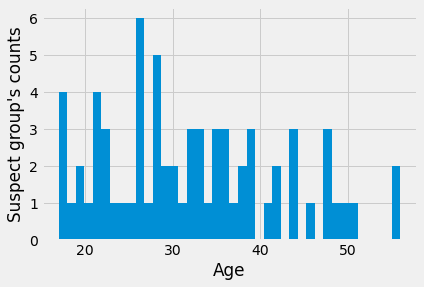

In [51]:
ds = age_valid.loc[(age_valid['city']==5) & (age_valid['gender']=='female') & (age_valid['registered_via']==9)]['bd']
plt.hist(ds, bins=np.max(ds)-np.min(ds)+1); # 1 bin per 1 year of age
plt.xlabel('Age');
plt.ylabel("Suspect group's counts");

In [52]:
# Apply guessed values of age
idx = members.loc[members.bd == 827].index[0]
members.loc[idx, 'bd'] = 27

idx = members.loc[members.bd == 132].index[0]
members.loc[idx, 'bd'] = 32

There are still many invalid 0 values af age. We leave them as 0, as the age will be treated as a categorical value.

#### `trans.msno`
Knowing that not all members have transaction information, we also need to see if there members with transaction information, but having no membership information. 

In [53]:
s = 0 # counter of how many members are in both `trans` and `members`
memberids = members.msno.unique() # list of all member IDs in `members`
for i in trans.msno.unique(): # all member IDs in `trans`
    if i in memberids: s = s+1
print(f"{len(trans.msno.unique())} members have transaction information,")
print(f"{s} members have both the membership and transaction information,")
print(f"{len(trans.msno.unique())-s} members have transaction information, but do not have membership information.")

2434 members have transaction information,
1968 members have both the membership and transaction information,
466 members have transaction information, but do not have membership information.


#### `logs.msno`
Since not all members have logs, we also need to see if `logs` contains member IDs that are not in `members` or `trans`. 

In [54]:
s = 0 # counter of how many members are in both `logs` and `members`
for i in logs.msno.unique(): # all member IDs in `logs`
    if i in memberids: s = s+1
print(f"{len(logs.msno.unique())} members have usage information,")
print(f"{s} members have both the membership and usage information,")
print(f"{len(logs.msno.unique())-s} members have usage information, but do not have membership information.")

5214 members have usage information,
5040 members have both the membership and usage information,
174 members have usage information, but do not have membership information.


In [55]:
s = 0 # counter of how many members are in both `logs` and `trans`
s3 = 0 # how many members have all 3 types of information
for i in logs.msno.unique(): # all member IDs in `logs`
    if i in trans.msno.unique(): # all member IDs in `trans`
        s = s+1
        if i in memberids:
            s3 = s3+1
print(f"{s} members have both the usage and transaction information,")
print(f"{len(logs.msno.unique())-s} members have usage information, but do not have transaction information.")
print(f"{s3} members have all 3 types of information.")

1913 members have both the usage and transaction information,
3301 members have usage information, but do not have transaction information.
1913 members have all 3 types of information.


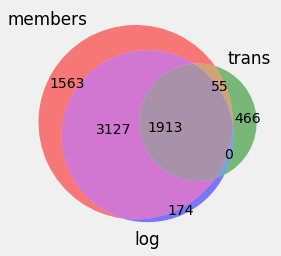

In [56]:
venn3(subsets = (1563, 466, 55, 174, 3127, 0, 1913), set_labels = ('members', 'trans', 'log'), alpha = 0.5);
#https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305

#### Replace erroneous `logs.total_secs` using its linear regression over listening statistics
To impute erroneous negative values of `total_secs`, let us use the linear regression over listening statistics variables, `num_25`, `num_50`, `num_75`, `num_985`, `num_100`, and `num_unq`.

In [57]:
# `total_secs` has erroneous negative values
logs[logs.total_secs < 0].total_secs.unique() # missing values

array([-9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -9.22337204e+15, -9.22337204e+15, -9.22337204e+15,
       -9.22337204e+15, -

In [58]:
# Data used for regression: predictor and response variables, records with valid duration
Xy = logs.drop(['msno','date','num_unq'], axis=1).loc[logs.total_secs > 0]
# 'num_unq' is eliminated from regression, since it leads to a negative coeff. of 'num_25', and thus <0 values
X_fit = Xy.drop('total_secs', axis=1)
print("No. of predictor variables:",X_fit.shape[1])
y_fit = Xy['total_secs']
print("No. of datapoints:",y_fit.shape[0])

# Linear regression
reg = LinearRegression().fit(X_fit, y_fit)
print("R^2 =",reg.score(X_fit, y_fit)) # Coefficient of determination of the predictions
print("Linear regression formula:")
print(f"total_secs ~ {reg.intercept_}")
vars = X_fit.columns
for i in range(len(vars)):
    if reg.coef_[i] >= 0:
        print(f"+{reg.coef_[i]}*{vars[i]}")
    else:
        print(f"{reg.coef_[i]}*{vars[i]}")

# Imputation with regression predicted values
# values to be replaced by linear regression predictions
Xy = logs.drop(['msno','date','num_unq'], axis=1).loc[logs.total_secs <= 0]
X_pred = Xy.drop('total_secs', axis=1)
idx = Xy.index
logs.loc[idx,['total_secs']] = reg.predict(X_pred)

No. of predictor variables: 5
No. of datapoints: 424163
R^2 = 0.7065456855178767
Linear regression formula:
total_secs ~ 941.6235459477575
+15.139877445347503*num_25
+90.52366290699025*num_50
+206.3097580194579*num_75
+330.71482817275813*num_985
+203.43477634203904*num_100


In [59]:
# Sort usage logs by member ID and chronologically
logs = logs.sort_values(by=['msno','date'])
logs.head()

msno       date  num_25  \
117822  +/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU= 2016-02-18       0   
127014  +/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU= 2016-03-05       0   
294909  +/YVsAKHl+zz+knoN7tD/304ryI518FHS8u4zY+7cDA= 2016-03-20       0   
216885  +02DseTE8j9jvqiPO20x+v71zdIe90IekJT1I7Bzmx8= 2015-12-23      51   
311867  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-14      19   

        num_50  num_75  num_985  num_100  num_unq  total_secs  
117822       0       0        1        7        8    1863.523  
127014       0       0        0        3        3     779.860  
294909       0       0        1        0        1     174.480  
216885       9       2        0        0       57    2446.634  
311867       6       6        1       42       61   11779.952

In [60]:
if not Path("data/logs.csv").is_file():
    logs.to_csv("data/logs.csv", index=False)

### 2.5 Detailed data exploration

In [61]:
# Auxiliary functions
def nu(a):
    '''No. of unique values'''
    return len(np.unique(a))
def top(n,d,f):
    '''Count and percentage of the top `n` values of feature `f` in dataframe `d`'''
    print(f"{f}\tcount\t%")
    vc = pd.DataFrame(d[f].value_counts())
    n = len(d)
    for i in range(5):
        cnt = vc.iloc[i] #.index[i]
        print(f"{cnt.name}\t{cnt[f]}\t{round(cnt[f]/n*100,2)}")

#### 2.5.1 members.csv

In [62]:
members.head()

msno  city  bd   gender  \
0  8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=     4  24     male   
1  yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=     8  37     male   
2  sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=    15  21     male   
3  Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=     1   0  unknown   
4  NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=    12  21     male   

   registered_via registration_init_time  
0               3             2014-11-04  
1               9             2007-02-11  
2               3             2013-02-08  
3               9             2015-02-01  
4               3             2015-02-12

#### members.msno

In [63]:
Nm = nu(members.msno)
print("No. of members:", Nm)

No. of members: 6658


#### members.city

In [64]:
print(f"There are {nu(members.city)} cities")
print("Sorted cities:", np.sort(members.city.unique()))

There are 20 cities
Sorted cities: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22]


Most members are from city 1:

In [65]:
#members.city.value_counts()
top(5,members,'city')

city	count	%
1	4735	71.12
5	384	5.77
13	285	4.28
4	227	3.41
22	208	3.12


#### members.bd

In [66]:
print(f"No. of unique ages `bd`: {len(members.bd.unique())}")
print("Sorted bd:", np.sort(members.bd.unique()))
# 0 is an invalid value for age

No. of unique ages `bd`: 63
Sorted bd: [  0   6  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  65  66  67
  69  70  72  90  97 103 106 112 117]


Inspection of available city and age combinations shows that only `city=7` does not have invalid 0 ages:

In [67]:
print("All combinations of `city` and `bd`:")
test= members.groupby(['city','bd'])
test.size()

All combinations of `city` and `bd`:


city  bd 
1     0      4295
      15        2
      16       11
      17       13
      18       25
      19       28
      20       25
      21       24
      22       18
      23       11
      24       25
      25       21
      26       12
      27       19
      28       12
      29       15
      30       11
      31        8
      32       12
      33        7
      34        9
      35        7
      36        8
      37        9
      38        6
      39        6
      40       10
      41        7
      42        3
      43        9
      44        8
      45        4
      46        6
      47        5
      48        6
      49        3
      50        2
      51        5
      52        6
      53        2
      54        2
      55        2
      56        1
      57        4
      59        3
      60        3
      61        1
      66        2
      67        1
      112       1
3     0         1
      17        1
      19        3
      21        1
      22        1


#### members.gender

In [68]:
print("Unknown gender and bd=0 count:", members.gender[(members.gender=='unknown') & (members.bd == 0)].count())
print("Unknown gender and bd>0 count:", members.gender[(members.gender=='unknown') & (members.bd  > 0)].count())

Unknown gender and bd=0 count: 4283
Unknown gender and bd>0 count: 38


A small proportion 0.887% of `bd > 0` among customers with unknown gender suggests that `0` could be used to encode a missing value of `bd`. Let us inspect this small group.

In [69]:
members.loc[(members.gender=='unknown') & (members.bd > 0)].drop(columns=['msno','gender']) # nothing special

city  bd  registered_via registration_init_time
269      1  16               9             2016-05-23
278      5  28               9             2014-03-12
333      1  28               4             2016-10-02
634     13  22               3             2013-01-08
766      1  36               3             2014-04-28
824      3  27               9             2014-05-30
984      5  27               9             2010-12-13
1133     1  26               4             2017-01-28
1403    12  23               3             2013-02-06
1598    15  26               7             2012-12-23
1823     1  22               3             2013-08-02
2083    13  29               7             2011-12-26
2119     5  31               9             2013-03-01
2310     1  18               9             2015-07-13
2335    15  27               9             2015-01-14
2660     1  33               4             2016-05-04
2697     1  17               4             2015-10-25
2821    15  30               9             2015-03-04
3509     5  31               9             2015-06-22
3566     1  17               4             2016-12-14
3832     1  24               9             2013-09-28
3893     1  46               9             2012-12-20
4078     1  32               9             2013-09-16
4080    13  38               4             2016-07-31
4141     4  29               3             2013-09-07
4256     1  16               9             2017-01-03
4308    13  36               3             2014-04-11
4742     1  16               9             2017-01-03
4897     1  22               9             2017-02-09
5604    14  20               7             2014-01-29
5695    13  40               4             2015-12-14
5848    11  20               3             2013-12-16
6075     1  26               3             2014-04-29
6099     1  26               9             2016-11-07
6120    15  28               9             2015-08-02
6365     1  43               9             2016-02-03
6412    13  32               7             2010-07-05
6501     1  18               9             2015-08-21

Notice that this group has only a few values of 'registered_via': 3, 4, 7, and 9. This suggests that data input error rate is sensitive to the registration channel.

In [70]:
members.loc[(members.gender=='unknown') & (members.bd > 0)].drop(columns=['msno','gender'])['registered_via'].value_counts()

9    19
3     8
4     7
7     4
Name: registered_via, dtype: int64

Indeed, the same four channels account for 99.0% of missing gender entries:

In [71]:
members.loc[members.gender=='unknown'].registered_via.value_counts()

4     2498
9      699
7      686
3      396
11      25
13       6
2        2
8        2
5        2
1        1
17       1
6        1
19       1
16       1
Name: registered_via, dtype: int64

64.76% of all records acquired via these channels have missing gender:

In [72]:
members.loc[members['registered_via'].isin([3,4,7,9]), ['gender'] ].value_counts()

gender 
unknown    4279
male       1205
female     1123
dtype: int64

Most of the missing genders are from city '1':

In [73]:
members.loc[members.gender=='unknown'].city.value_counts()

1     4206
13      23
5       17
15      15
22      11
4       11
14       8
6        5
11       5
8        4
12       4
18       4
9        3
21       2
3        2
10       1
Name: city, dtype: int64

In [74]:
members.loc[(members.gender=='unknown') & (members.bd > 0) ].city.value_counts()

1     19
13     6
5      4
15     4
3      1
12     1
4      1
14     1
11     1
Name: city, dtype: int64

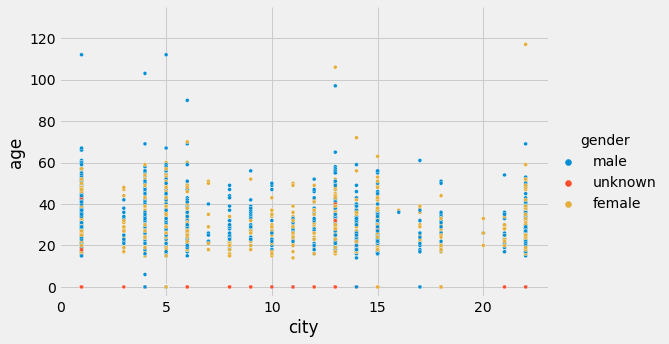

In [75]:
sns.relplot(data=members, x='city', y='bd', hue='gender', aspect=1.6, s=15)
plt.ylim(-5, 135)
plt.ylabel('age')
plt.show();

#### members.registered_via

In [76]:
print(f"`registered_via` has {nu(members['registered_via'])} levels:")
pd.crosstab(index=members['registered_via'], columns='count')

`registered_via` has 14 levels:


col_0           count
registered_via       
1                   1
2                   2
3                1648
4                2710
5                   2
6                   1
7                 798
8                   3
9                1451
11                 31
13                  7
16                  1
17                  1
19                  2

In [77]:
top(5,members,'registered_via')

registered_via	count	%
4	2710	40.7
3	1648	24.75
9	1451	21.79
7	798	11.99
11	31	0.47


#### members.registration_init_time

Earliest member registration:	 2004-03-27
Latest member registration:	 2017-04-29


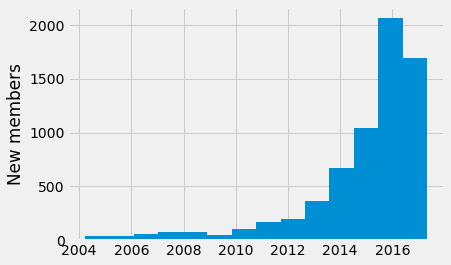

In [78]:
print("Earliest member registration:\t", np.min(members.registration_init_time).strftime('%Y-%m-%d'))
print("Latest member registration:\t", np.max(members.registration_init_time).strftime('%Y-%m-%d'))
plt.hist(members.registration_init_time, bins=2017-2004+1)
plt.ylabel('New members');

#### 2.5.2 transactions.csv

In [79]:
print(trans.shape)
trans.head()

(22940, 9)


msno  payment_method_id  \
0  5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=                 41   
1  DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=                 41   
2  Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=                 38   
3  ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=                 41   
4  MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=                 38   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                 30               99                  99              1   
1                 30              149                 149              1   
2                 30              149                 149              0   
3                 30              149                 119              1   
4                 30              149                 149              0   

  transaction_date membership_expire_date  is_cancel  
0       2017-02-10             2017-03-10          0  
1       2016-02-01             2016-03-02          0  
2       2016-02-23             2016-04-23          0  
3       2015-09-06             2016-08-01          0  
4       2016-10-28             2016-11-27          0

#### trans.msno

In [80]:
Ntm = nu(trans.msno)
print("No. of members with available transaction data:", Ntm)
print(f"Proportion of members with available transaction data: {round(len(trans.msno.unique())/Nm*100,1)}%")

No. of members with available transaction data: 2434
Proportion of members with available transaction data: 36.6%


#### trans.payment_method_id

In [81]:
trans.payment_method_id.describe()

count    22940.000000
mean        38.903575
std          3.548366
min          8.000000
25%         38.000000
50%         41.000000
75%         41.000000
max         41.000000
Name: payment_method_id, dtype: float64

In [82]:
print("Levels of payment method:", np.sort(trans.payment_method_id.unique()))

Levels of payment method: [ 8 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41]


In [83]:
Nt = trans.shape[0]
print("No. of transactions:", Nt)
top(5,trans,'payment_method_id')

No. of transactions: 22940
payment_method_id	count	%
41	11983	52.24
40	2508	10.93
38	1851	8.07
39	1659	7.23
37	1193	5.2


Looking at one of the member's data, we see only one payment method:

In [84]:
trans.loc[trans.msno=='5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=', 'payment_method_id']

0        41
1020     41
4151     41
4735     41
7267     41
8705     41
9597     41
10303    41
10909    41
11228    41
15174    41
15889    41
17815    41
18034    41
20735    41
20929    41
20952    41
21608    41
Name: payment_method_id, dtype: int64

Does each member use only one payment method? No, from 1 to 5 payment methods were used by a member.

In [85]:
# How many payment methods were used by each member
uv_pm = pd.pivot_table(trans, index='msno', values='payment_method_id', aggfunc=nu)
uv_pm.rename(columns = {'payment_method_id':'n_payment_methods'}, inplace = True)
uv_pm.head()

n_payment_methods
msno                                                           
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=                  1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=                  2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=                  1
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=                  1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=                  1

In [ ]:
uv_pm.n_payment_methods.sort_values(ascending=False)

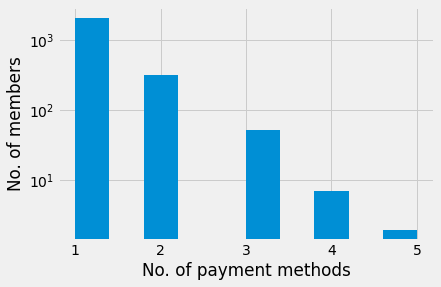

In [87]:
plt.semilogy();
uv_pm.n_payment_methods.hist();
plt.xlabel('No. of payment methods');
plt.ylabel('No. of members');

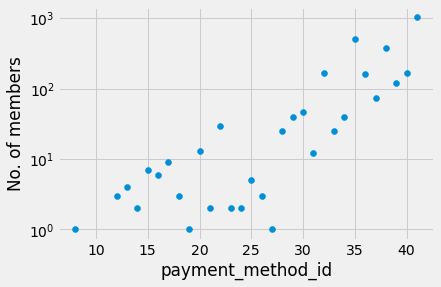

In [88]:
uv_mem = pd.pivot_table(trans, index='payment_method_id', values='msno', aggfunc=nu) # how many members used each payment method
uv_mem.rename(columns = {'msno':'n_members'}, inplace = True)
plt.semilogy()
plt.scatter(uv_mem.index, uv_mem.n_members);
plt.xlabel("payment_method_id");
plt.ylabel("No. of members");

In [89]:
print("Payment plan days:",np.sort(trans.payment_plan_days.unique()))

Payment plan days: [  0   1   2   7  10  14  30  31  35  60  80  90 100 120 180 195 200 240
 270 360 365 395 400 410 415 450]


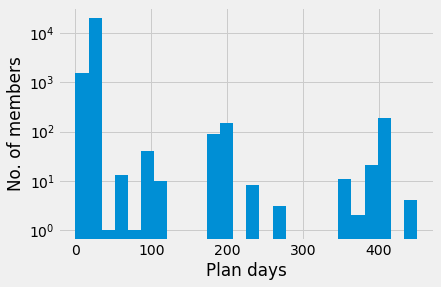

In [90]:
plt.semilogy();
trans.payment_plan_days.hist(bins=nu(trans.payment_plan_days));
plt.xlabel('Plan days');
plt.ylabel("No. of members");

In [91]:
print(f"Of payment_plan_days == 0, only {round(100*trans.loc[trans.payment_plan_days == 0].is_cancel.sum()/trans.loc[trans.payment_plan_days == 0].is_cancel.shape[0],2)}% transactions were cancellations.")

Of payment_plan_days == 0, only 3.25% transactions were cancellations.


In [92]:
# How many different plan days each member had
uv_pd = pd.pivot_table(trans, index='msno', values='payment_plan_days', aggfunc=nu)
uv_pd.rename(columns = {'payment_plan_days':'n_payment_plan_days'}, inplace = True)
uv_pd.head()

n_payment_plan_days
msno                                                             
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=                    1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=                    2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=                    2
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=                    1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=                    2

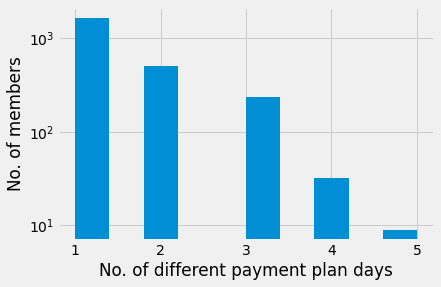

In [93]:
plt.semilogy();
uv_pd.n_payment_plan_days.hist();
plt.xlabel('No. of different payment plan days');
plt.ylabel('No. of members');

#### trans.plan_list_price

In [94]:
print(f"{nu(trans.plan_list_price)} levels of plan list price:", np.sort(trans.plan_list_price.unique()))

31 levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


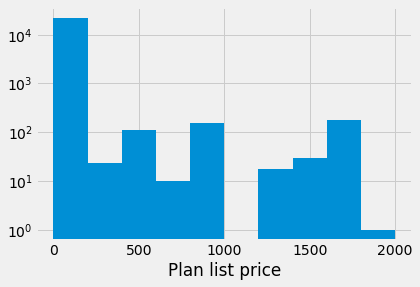

In [95]:
plt.semilogy();
trans.plan_list_price.hist();
plt.xlabel('Plan list price');

#### trans.actual_amount_paid -> discount

In [96]:
print(f"{nu(trans.actual_amount_paid)} levels of plan list price:", np.sort(trans.actual_amount_paid.unique()))

31 levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


In [97]:
print(f"`actual_amount_paid > plan_list_price` only when `plan_list_price` == {trans.loc[trans.actual_amount_paid > trans.plan_list_price].plan_list_price.unique()}")

`actual_amount_paid > plan_list_price` only when `plan_list_price` == [0]


In [98]:
trans['discount'] = trans.plan_list_price - trans.actual_amount_paid
print(f"Discount levels: {np.sort(trans.loc[trans.discount > 0].discount.unique())}")

Discount levels: [ 20  30 120 149 180]


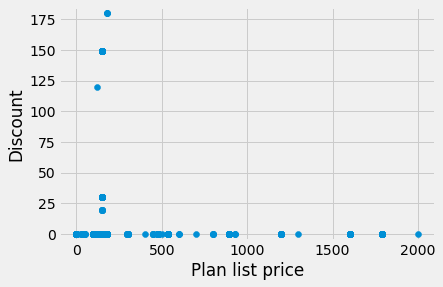

In [99]:
plt.scatter(trans.plan_list_price, trans.discount);
plt.ylim([-5,185]);
plt.xlabel('Plan list price');
plt.ylabel('Discount');

Expensive plans do not have discounts.

#### trans.is_auto_renew

In [100]:
print(f"Proportion of auto renew transactions: {round(100*trans.is_auto_renew.sum()/Nt,2)}%")

Proportion of auto renew transactions: 85.15%


#### trans.transaction_date

In [101]:
print("Earliest transaction:\t",np.min(trans.transaction_date).strftime('%Y-%m-%d'))
print("Latest transaction:\t",np.max(trans.transaction_date).strftime('%Y-%m-%d'))

Earliest transaction:	 2015-01-01
Latest transaction:	 2017-03-31


There is an overall growth in the number of transactions with time.

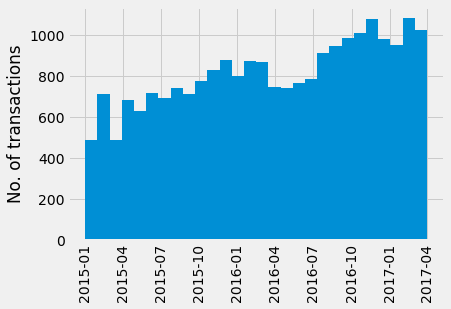

In [102]:
plt.xticks(rotation=90)
trans.transaction_date.hist(bins=2*12+4);
plt.ylabel('No. of transactions');

#### trans.membership_expire_date

In [103]:
print(f"{nu(trans.membership_expire_date)} levels of membership_expire_date")

1022 levels of membership_expire_date


Some values are invalid, since they are older than the earliest membership subscription:

In [104]:
np.min(trans.membership_expire_date).strftime('%Y-%m-%d')

'1970-01-01'

some other are in the future, but this is OK

In [105]:
np.max(trans.membership_expire_date).strftime('%Y-%m-%d')

'2018-06-10'

In [106]:
def md(tn):
    '''Membership duration (days) for transaction number tn'''
    return trans.membership_expire_date[tn] - members.loc[members.msno == trans.msno[tn]].registration_init_time

In [107]:
md(0)

1421   2360 days
Name: registration_init_time, dtype: timedelta64[ns]

#### trans.is_cancel

In [108]:
print(f"Proportion of cancellation transactions: {round(100*trans.is_cancel.sum()/Nt,2)}%")

Proportion of cancellation transactions: 3.95%


#### 2.5.3 logs.csv
Music listening (usage) logs.

In [109]:
logs.head()

msno       date  num_25  \
117822  +/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU= 2016-02-18       0   
127014  +/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU= 2016-03-05       0   
294909  +/YVsAKHl+zz+knoN7tD/304ryI518FHS8u4zY+7cDA= 2016-03-20       0   
216885  +02DseTE8j9jvqiPO20x+v71zdIe90IekJT1I7Bzmx8= 2015-12-23      51   
311867  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-14      19   

        num_50  num_75  num_985  num_100  num_unq  total_secs  
117822       0       0        1        7        8    1863.523  
127014       0       0        0        3        3     779.860  
294909       0       0        1        0        1     174.480  
216885       9       2        0        0       57    2446.634  
311867       6       6        1       42       61   11779.952

#### logs.msno

In [110]:
Nlm = nu(logs.msno)
print("No. of members with available logs data:", Nlm)
print(f"Proportion of members with available logs data: {round(Nlm/Nm*100,2)}%")

No. of members with available logs data: 5214
Proportion of members with available logs data: 78.31%


#### logs.date

In [111]:
print("Earliest usage log:",np.min(logs.date).strftime('%Y-%m-%d'))
print("Latest usage log:",np.max(logs.date).strftime('%Y-%m-%d'))

Earliest usage log: 2015-01-01
Latest usage log: 2017-03-31


In [112]:
logs.describe()

num_25         num_50         num_75        num_985  \
count  424252.000000  424252.000000  424252.000000  424252.000000   
mean        6.276480       1.571901       0.978503       1.044558   
std        12.853579       3.900916       2.064198       2.459123   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         2.000000       1.000000       0.000000       0.000000   
75%         7.000000       2.000000       1.000000       1.000000   
max       937.000000     257.000000     204.000000     201.000000   

             num_100        num_unq    total_secs  
count  424252.000000  424252.000000  4.242520e+05  
mean       31.394426      29.348618  8.112987e+03  
std        46.805506      33.006411  1.166304e+04  
min         0.000000       1.000000  1.000000e-03  
25%         6.000000       8.000000  1.863606e+03  
50%        16.000000      18.000000  4.549168e+03  
75%        38.000000      39.000000  1.006652e+04  
max      4376.000000    2944.000000  2.763295e+06

#### logs.num_25
Number of songs listened upto 25% of their duration.

In [113]:
print("Unique values for the no. of songs listened <25%:",nu(logs.num_25))

Unique values for the no. of songs listened <25%: 288


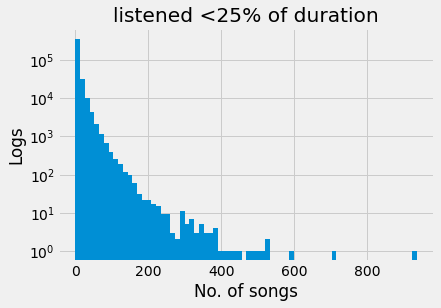

In [114]:
plt.semilogy();
logs.num_25.hist(bins=nu(logs.num_25)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened <25% of duration');

#### logs.num_50
Number of songs listened 25-50% of their duration.

In [115]:
print("Unique values for the no. of songs listened 25-50%:",nu(logs.num_50))

Unique values for the no. of songs listened 25-50%: 137


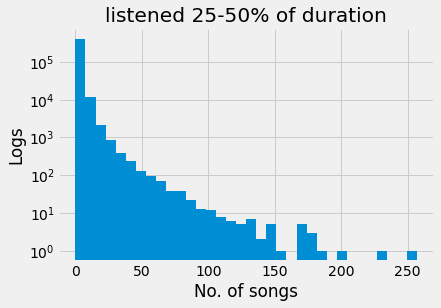

In [116]:
plt.semilogy();
logs.num_50.hist(bins=nu(logs.num_50)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 25-50% of duration');

#### logs.num_75
Number of songs listened 50-75% of their duration.

In [117]:
print("Unique values for the no. of songs listened 50-75%:",nu(logs.num_75))

Unique values for the no. of songs listened 50-75%: 83


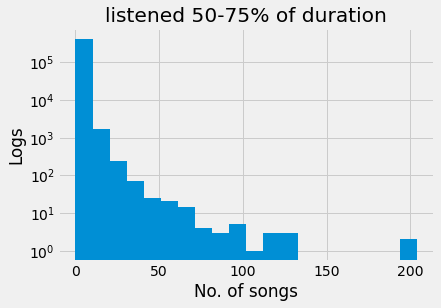

In [118]:
plt.semilogy();
logs.num_75.hist(bins=nu(logs.num_75)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 50-75% of duration');

#### logs.num_985
Number of songs listened 75-98.5% of their duration.

In [119]:
print("Unique values for the no. of songs listened 75-98.5%:",nu(logs.num_985))

Unique values for the no. of songs listened 75-98.5%: 109


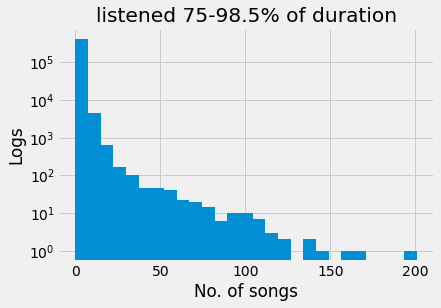

In [120]:
plt.semilogy();
logs.num_985.hist(bins=nu(logs.num_985)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 75-98.5% of duration');

#### logs.num_100
Number of songs listened 98.5-100% of their duration.

In [121]:
print("Unique values for the no. of songs listened 98.5-100%:",nu(logs.num_100))

Unique values for the no. of songs listened 98.5-100%: 734


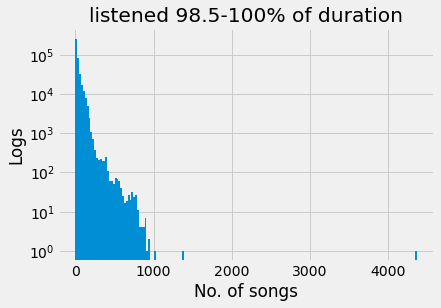

In [122]:
plt.semilogy();
logs.num_100.hist(bins=nu(logs.num_100)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('listened 98.5-100% of duration');

Distributions of the number of logs with listening percentage are similar upto 75% of the duration of a song.

#### logs.num_unq

In [123]:
print("Unique values for the no. of unique songs:",nu(logs.num_unq))

Unique values for the no. of unique songs: 386


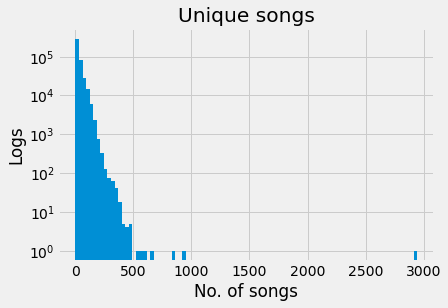

In [124]:
plt.semilogy();
logs.num_unq.hist(bins=nu(logs.num_unq)//4);
plt.xlabel('No. of songs');
plt.ylabel('Logs');
plt.title('Unique songs');

#### logs.total_secs

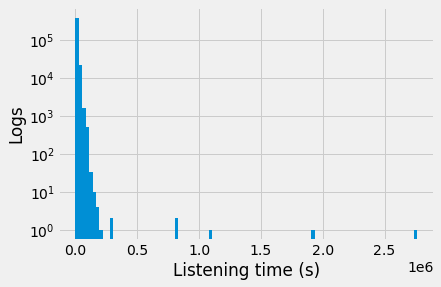

In [125]:
plt.semilogy();
logs[logs.total_secs > 0].total_secs.hist(bins=100);
plt.xlabel('Listening time (s)');
plt.ylabel('Logs');

In [126]:
print("Between 0 and 1 sec:")
logs[(0 < logs.total_secs) & (logs.total_secs < 1)].total_secs.describe()

Between 0 and 1 sec:


count    134.000000
mean       0.520963
std        0.283591
min        0.001000
25%        0.292250
50%        0.515000
75%        0.758000
max        0.995000
Name: total_secs, dtype: float64

In [127]:
logs.total_secs.describe()

count    4.242520e+05
mean     8.112987e+03
std      1.166304e+04
min      1.000000e-03
25%      1.863606e+03
50%      4.549168e+03
75%      1.006652e+04
max      2.763295e+06
Name: total_secs, dtype: float64

### 2.6 Clean data: fix times, remove useless, replace missing
#### 2.6.1 Fix errors in dates
#### members.registration_init_time

The earliest event is initial registration: members['registration_init_time'] must always be before or same as trans['transaction_date'].

In [128]:
members['registration_init_time'].head()

0   2014-11-04
1   2007-02-11
2   2013-02-08
3   2015-02-01
4   2015-02-12
Name: registration_init_time, dtype: datetime64[ns]

No violations of this rule: indeed, `registration_init_time` is the same or earlier than `transaction_date`.
#### Violations of registration_init_time <= membership_expire_date
Now compare the former with `membership_expire_date`.

In [129]:
# Check inconsistency in dates
print('Records where `registration_init_time` is later than `membership_expire_date`')
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    member_id = tr['msno']
    members_row = members.loc[members['msno']==member_id, 'registration_init_time']
    if len(members_row) > 0: # some member_id's are in trans.csv, but not in members.csv
        registration_init_time = members_row.squeeze()
        if len(members.loc[members['msno']==member_id, 'registration_init_time'])>1:
            print(i);
            break;
        if (registration_init_time > tr['membership_expire_date']):
            print(i)
            n_violations=n_violations+1
n_violations

Records where `registration_init_time` is later than `membership_expire_date`
1860
17032


2

In both violations, `membership_expire_date = 1970-01-01`:

In [130]:
trans.iloc[1860] # Example of violation: `membership_expire_date = 1970-01-01`
#trans.iloc[17032]

msno                      PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=
payment_method_id                                                   17
payment_plan_days                                                   60
plan_list_price                                                      0
actual_amount_paid                                                   0
is_auto_renew                                                        0
transaction_date                                   2017-02-01 00:00:00
membership_expire_date                             1970-01-01 00:00:00
is_cancel                                                            0
discount                                                             0
Name: 1860, dtype: object

Replace `membership_expire_date` with `transaction_date`, if same or earlier than transaction date.

In [131]:
#trans.loc[trans['membership_expire_date']=='1970-01-01']
print("Earliest `registration_init_time`:",np.min(members['registration_init_time']).strftime('%Y-%m-%d'))
print("Rows with invalid `membership_expire_date`")
Xy = trans.loc[trans['membership_expire_date'] <= np.min(members['registration_init_time'])]
idx = Xy.index
trans.loc[idx, ['transaction_date','membership_expire_date']]

Earliest `registration_init_time`: 2004-03-27
Rows with invalid `membership_expire_date`


transaction_date membership_expire_date
1860        2017-02-01             1970-01-01
17032       2017-02-03             1970-01-01
18535       2015-02-06             1970-01-01

In [132]:
def fix_membership_expire_date(df,idx):
    '''Fix membership_expire_date in dataframe df, row no. idx'''
    tr = df.iloc[idx] # row no. idx in df
    med = tr['membership_expire_date'].strftime('%Y-%m-%d') #membership_expire_date
    if (med == '1970-01-01') or (tr['transaction_date'] >= tr['membership_expire_date']): # then fix it
        Date = tr['transaction_date'].date() #Timestamp => datetime.date
        med = Date + timedelta(days=int(tr.payment_plan_days)) # transaction date + payment plan days
        med = pd.Timestamp(med)
        df.loc[idx,'membership_expire_date'] = med
    return med

In [133]:
for i in idx:
    fix_membership_expire_date(trans,i)

Now indeed `registration_init_time` <= `membership_expire_date`.

#### Violations of trans.transaction_date < trans.membership_expire_date

In [134]:
# Count and fix violations
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    if (tr['transaction_date'] >= tr['membership_expire_date']):
        print(i)
        n_violations=n_violations+1
        fix_membership_expire_date(trans,i) # membership_expire_date = transaction_date + payment_plan_days
n_violations

110
136
159
175
232
262
349
352
396
437
467
473
480
501
511
542
659
743
807
817
850
857
901
955
957
1049
1057
1070
1096
1108
1112
1180
1202
1324
1357
1449
1493
1506
1541
1567
1659
1682
1686
1687
1740
1768
1846
1868
1902
1973
2035
2082
2108
2225
2271
2300
2323
2354
2366
2371
2380
2386
2400
2416
2429
2481
2515
2558
2595
2630
2680
2699
2706
2712
2742
2746
2844
2852
2879
2907
2909
2967
2996
3001
3071
3115
3117
3125
3215
3232
3265
3300
3323
3385
3419
3421
3422
3428
3500
3509
3525
3664
3672
3679
3719
3755
3797
3806
3811
3882
3889
3973
4025
4044
4065
4124
4217
4299
4318
4329
4376
4387
4408
4530
4572
4605
4615
4621
4656
4752
4886
4898
4957
4970
4973
5104
5160
5192
5229
5390
5396
5420
5445
5461
5506
5543
5571
5582
5586
5599
5667
5739
5782
5788
5821
5826
5867
5882
5907
5983
6017
6055
6057
6149
6156
6166
6180
6229
6419
6426
6466
6483
6486
6522
6556
6615
6617
6628
6637
6714
6815
6823
6827
6850
6857
6861
6872
6875
6941
7003
7019
7147
7155
7202
7218
7285
7286
7322
7429
7442
7486
7542
7559
7561
7716


608

There are 608 violations of `trans.transaction_date < trans.membership_expire_date`.

In [135]:
# Count remaining violations
n_violations=0
for i in range(Nt):
    tr = trans.iloc[i]
    if (tr['transaction_date'] >= tr['membership_expire_date']):
        n_violations=n_violations+1
        #fix_membership_expire_date(trans,i)
        print(i, tr.is_cancel, tr.membership_expire_date - tr.transaction_date)
print("Remaining violations:",n_violations)

3811 1 0 days 00:00:00
6637 1 0 days 00:00:00
6875 1 0 days 00:00:00
7286 1 0 days 00:00:00
7868 1 0 days 00:00:00
9642 1 0 days 00:00:00
10013 1 0 days 00:00:00
11307 0 0 days 00:00:00
11419 1 0 days 00:00:00
14639 1 0 days 00:00:00
17990 1 0 days 00:00:00
18062 1 0 days 00:00:00
19058 1 0 days 00:00:00
20254 1 0 days 00:00:00
Remaining violations: 14


In all 14 cases, `membership_expire_date` coincides with `transaction_date` due to `payment_plan_days==0`, which amost always is accompanied by `is_cancel==1` (except for row 11307, for which immediate expiration is still due to `payment_plan_days==0`, and there is no future transactions for this member. Therefore, `is_cancel` should probably be 1 in this row.)

In [136]:
trans.iloc[11307]

msno                      4X5qK8pnV2YMJJBahyDoXPyj0g4PcV3CD2V6/3n/L8I=
payment_method_id                                                   24
payment_plan_days                                                    0
plan_list_price                                                      0
actual_amount_paid                                                 149
is_auto_renew                                                        1
transaction_date                                   2015-04-28 00:00:00
membership_expire_date                             2015-04-28 00:00:00
is_cancel                                                            0
discount                                                          -149
Name: 11307, dtype: object

In [137]:
# Save `trans` with fixed times
if not Path("./data/transactions.csv").is_file():
    trans.to_csv("./data/transactions.csv")


#### 2.6.2 Merge `members` and `trans`
There are many members without transaction information, which means the lack of churn labels. To remove useless data for such members, we merge `members.csv` and `transactions.csv` by retaining only members present in `transactions.csv`.

In [138]:
mt = members.merge(trans, how='right', on='msno')
mt.shape

(22940, 15)

`members.csv` is no longer needed.

In [139]:
mt = mt.sort_values(by=['registration_init_time','msno','transaction_date']) # chronological sorting
mt.head(100)

msno  city    bd  gender  \
18506  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
6085   0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
16905  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
21590  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
13735  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
7492   9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
11406  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
639    9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
4325   9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
17631  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
19795  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
13622  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
2864   9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
16745  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
13326  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
19737  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
108    9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
20771  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
20096  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
18526  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
12920  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
12403  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
5405   9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
14891  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
10691  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
3730   9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
22173  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   
4029   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
731    9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
20444  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
10931  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
10783  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
17184  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
18781  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
13355  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
566    9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
20568  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
12127  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
9549   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
11496  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
5914   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
20325  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
11910  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
4855   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
13983  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
17488  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
9566   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
19208  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
1221   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
6182   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
1933   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
7574   9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male   
16003  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=  22.0  34.0    male 

In [140]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 18506 to 21900
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   city                    19944 non-null  float64       
 2   bd                      19944 non-null  float64       
 3   gender                  19944 non-null  object        
 4   registered_via          19944 non-null  float64       
 5   registration_init_time  19944 non-null  datetime64[ns]
 6   payment_method_id       22940 non-null  int64         
 7   payment_plan_days       22940 non-null  int64         
 8   plan_list_price         22940 non-null  int64         
 9   actual_amount_paid      22940 non-null  int64         
 10  is_auto_renew           22940 non-null  int64         
 11  transaction_date        22940 non-null  datetime64[ns]
 12  membership_expire_date  22940 non-null  da

However, 466 members in `trans` are not in `members`, as is revealed by null values of `registration_init_time`,

In [141]:
nu( mt.loc[mt['registration_init_time'].isnull(), 'msno'] )

466

which leads to missing values for the membership features in 2996 corresponding `logs` records in the merged dataframe:

In [142]:
mt.tail(2)

msno  city  bd gender  \
6412   zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=   NaN NaN    NaN   
21900  zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=   NaN NaN    NaN   

       registered_via registration_init_time  payment_method_id  \
6412              NaN                    NaT                 41   
21900             NaN                    NaT                 41   

       payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
6412                  30               99                  99              1   
21900                 30               99                  99              1   

      transaction_date membership_expire_date  is_cancel  discount  
6412        2017-02-19             2017-03-19          0         0  
21900       2017-03-19             2017-04-19          0         0

We need to replace the missing values, arising from member ID's in `transactions.csv` that are absent in `members.csv`.

Since the minimum value of `city` is 1,

In [143]:
np.min(members.city)

1

we can use 0 to encode missing city. The minimum value of age is 0,

In [144]:
np.min(members.bd)

0

which indicates the missing value, so let's use 0 for the missing age. For gender, we use 'unknown'. Minimal `registered_via` is 1,

In [145]:
np.min(members.registered_via.unique())

1

so let's use 0 for all missing city, age, and registration channel values.

To fix missing `registration_init_time` values, note that it should be no later than the `earliest transaction_date` for a given member. Otherwise, we could take the mean `registration_init_time` of '2014-12-03',

In [146]:
registration_init_time_mean = np.mean(members.registration_init_time) # mean initial registration time
registration_init_time_mean = pd.Timestamp(registration_init_time_mean.date()) # extract date
registration_init_time_mean

Timestamp('2014-12-03 00:00:00')

since it is earlier than all relevant `transaction_date` values,

In [147]:
mt_null_transaction_dates = mt.loc[mt['registration_init_time'].isnull(), ['transaction_date']]
mt_null_transaction_dates.shape

(2996, 1)

In [148]:
print("No. of records with `transaction_date` before mean `registration_init_time`:")
np.sum(mt_null_transaction_dates <= registration_init_time_mean).iloc[0]

No. of records with `transaction_date` before mean `registration_init_time`:


0

However, it seems more reasonable to subtract the average interval between initial registration and first transaction from the first transaction date. Let's find number of days between `registration_init_time` and `first_transaction_date`.

#### first_transaction_date, reg_to_trans_days
Let's create a dataframe containing the number of days from initial registration to first transaction for all members. 

In [149]:
first_transaction_date = pd.DataFrame(columns=['msno', 'reg_to_trans_days', 'first_transaction_date'])
for member_id in mt['msno'].unique():
    member_records = mt.loc[mt['msno'] == member_id, ['registration_init_time','transaction_date']]
    registration_init_time = member_records['registration_init_time'].iloc[0]
    #print('registration_init_time:',registration_init_time.strftime('%Y-%m-%d'))
    earliest_transaction_date = np.min(member_records['transaction_date'])
    #print('earliest_transaction_date:',earliest_transaction_date.strftime('%Y-%m-%d'))
    reg_to_trans_days = (earliest_transaction_date - registration_init_time).days
    # add record
    first_transaction_date.loc[len(first_transaction_date.index)] = [member_id, reg_to_trans_days, earliest_transaction_date]
first_transaction_date.head()

msno reg_to_trans_days  \
0  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=              4098   
1  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=              4021   
2  9rzbu7TiCDnfkSXSx9O0DZhmEBSncZ0VBmS2l1b5kg8=              3942   
3  /G/XFknHm94YVoCefhCyvnB9mAFM0rUSMqSNA/n+jTg=              4010   
4  BvmNMrNw/X4PB8ueWGZ0JswZoUAGGpMZET03F+rkmTI=              4248   

  first_transaction_date  
0             2015-06-16  
1             2015-03-31  
2             2015-01-11  
3             2015-03-31  
4             2016-01-04

In [150]:
first_transaction_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2433
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    2434 non-null   object        
 1   reg_to_trans_days       1968 non-null   object        
 2   first_transaction_date  2434 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 76.1+ KB


Where `registration_init_time` was missing, the `reg_to_trans_days` is also missing:

In [151]:
first_transaction_date.tail(2)

msno reg_to_trans_days  \
2432  zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=               NaN   
2433  zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=               NaN   

     first_transaction_date  
2432             2016-08-01  
2433             2016-12-20

In [152]:
reg_to_trans_days_mean = round(np.mean(first_transaction_date['reg_to_trans_days']))
print('Mean interval between initial registration and first transaction:',reg_to_trans_days_mean,'days')

Mean interval between initial registration and first transaction: 726 days


We can replace the missing `reg_to_trans_days` by `reg_to_trans_days_mean`:

In [153]:
first_transaction_date = first_transaction_date.fillna(value={'reg_to_trans_days':reg_to_trans_days_mean})
first_transaction_date.tail(2)

msno  reg_to_trans_days  \
2432  zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=                726   
2433  zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=                726   

     first_transaction_date  
2432             2016-08-01  
2433             2016-12-20

In [154]:
# Replace all missing values in `mt`
registration_init_time_fixed = list([])
for i in range(mt.shape[0]):
    mt_record = mt.iloc[i]
    if mt_record.notnull()['registration_init_time']: # not missing
        registration_init_time_fixed.append(mt_record['registration_init_time'])
    else:
        earliest_transaction_date = first_transaction_date.loc[first_transaction_date['msno'] ==\
                                            mt_record['msno']]['first_transaction_date'].iloc[0]
        registration_init_time = earliest_transaction_date - pd.Timedelta(reg_to_trans_days_mean*1e9*3600*24)
        registration_init_time_fixed.append(registration_init_time)
mt['registration_init_time'] = registration_init_time_fixed
mt = mt.fillna(value={'city':0, 'bd':0, 'gender':'unknown', 'registered_via':0})
mt.tail()

msno  city   bd   gender  \
7765   zje425fKTQ7EAtsSAKFrK9BX33hb7rOBi7ktnIdX7yU=   0.0  0.0  unknown   
472    zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=   0.0  0.0  unknown   
4054   zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=   0.0  0.0  unknown   
6412   zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=   0.0  0.0  unknown   
21900  zw/r9AbH/cAbTuZj91fb6na3+7xHz4yo1452QblSaUA=   0.0  0.0  unknown   

       registered_via registration_init_time  payment_method_id  \
7765              0.0             2014-08-06                 41   
472               0.0             2014-12-25                 41   
4054              0.0             2014-12-25                 41   
6412              0.0             2014-12-25                 41   
21900             0.0             2014-12-25                 41   

       payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
7765                  30              149                   0              1   
472                   30               99                  99              1   
4054                  30               99                  99              1   
6412                  30               99                  99              1   
21900                 30               99                  99              1   

      transaction_date membership_expire_date  is_cancel  discount  
7765        2016-08-30             2016-09-29          1       149  
472         2016-12-20             2017-01-19          0         0  
4054        2017-01-19             2017-02-19          0         0  
6412        2017-02-19             2017-03-19          0         0  
21900       2017-03-19             2017-04-19          0         0

In [155]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 18506 to 21900
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   city                    22940 non-null  float64       
 2   bd                      22940 non-null  float64       
 3   gender                  22940 non-null  object        
 4   registered_via          22940 non-null  float64       
 5   registration_init_time  22940 non-null  datetime64[ns]
 6   payment_method_id       22940 non-null  int64         
 7   payment_plan_days       22940 non-null  int64         
 8   plan_list_price         22940 non-null  int64         
 9   actual_amount_paid      22940 non-null  int64         
 10  is_auto_renew           22940 non-null  int64         
 11  transaction_date        22940 non-null  datetime64[ns]
 12  membership_expire_date  22940 non-null  da

No missing values anymore.

In [156]:
mt.reset_index(drop=True, inplace=True)
mt.head(2)

msno  city    bd  gender  \
0  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
1  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   

   registered_via registration_init_time  payment_method_id  \
0             9.0             2004-03-27                 32   
1             9.0             2004-03-27                 38   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                410             1788                1788              0   
1                 30              149                 149              0   

  transaction_date membership_expire_date  is_cancel  discount  
0       2015-06-16             2016-07-30          0         0  
1       2016-08-01             2016-08-31          0         0

Add auxiliary features generated before

In [157]:
# Add reg_to_trans_days, first_transaction_date
mt = pd.merge(mt, first_transaction_date, on = 'msno', how='inner')
print(mt.shape)
mt.head()

(22940, 17)


msno  city    bd  gender  \
0  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
1  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
2  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
3  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=  13.0  28.0  female   
4  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=  15.0   0.0  female   

   registered_via registration_init_time  payment_method_id  \
0             9.0             2004-03-27                 32   
1             9.0             2004-03-27                 38   
2             9.0             2004-03-27                 38   
3             9.0             2004-03-27                 32   
4             9.0             2004-03-27                 34   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                410             1788                1788              0   
1                 30              149                 149              0   
2                 30              149                 149              0   
3                415             1599                1599              0   
4                  0                0                 149              1   

  transaction_date membership_expire_date  is_cancel  discount  \
0       2015-06-16             2016-07-30          0         0   
1       2016-08-01             2016-08-31          0         0   
2       2016-09-13             2016-10-13          0         0   
3       2016-10-23             2017-12-12          0         0   
4       2015-03-31             2015-04-30          0      -149   

   reg_to_trans_days first_transaction_date  
0               4098             2015-06-16  
1               4098             2015-06-16  
2               4098             2015-06-16  
3               4098             2015-06-16  
4               4021             2015-03-31

In [158]:
for col in ['city','bd','registered_via']:
    mt.loc[:,col] = mt[col].astype('int') # convert data type back to integer. Floating-point was enforced due to missing values.
#mt.dtypes # verify

#### 2.6.3 logs.csv

As we already know, some of the members in `logs.csv` are not present in `transactions.csv`, since the number of differend ID's in `logs.csv` is greater:

In [159]:
nu(logs.msno) > nu(mt.msno)

True

Let's disregard the data for the members not present in `mt`, since they do not have churn labels.

In [160]:
# Faster way to filter members
logs_short = logs.merge(pd.DataFrame(mt['msno'].unique(), columns=['msno']), on='msno', how='inner')
print(f"{logs.shape[0] - logs_short.shape[0]} rows of `logs.csv` are removed.")
logs_short = logs_short.sort_values(by=['msno','date']) # sort by member and date
print(logs_short.shape)
logs_short.head()

13824 rows of `logs.csv` are removed.
(410428, 9)


msno       date  num_25  num_50  \
0  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-14      19       6   
1  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-15      11       3   
2  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-16      20       4   
3  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-17      33      10   
4  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-18       0       0   

   num_75  num_985  num_100  num_unq  total_secs  
0       6        1       42       61   11779.952  
1       8        3       26       46    8502.504  
2       2        3       26       48    7743.173  
3       3        1        5       50    3124.538  
4       0        3        1        4     967.850

`logs.csv` is not needed anymore,- replaced by `logs_short.csv`.

In [161]:
Nml = nu(logs_short['msno'])
print(f'{Nml} members in `logs_short`')
print(logs_short.shape)

1913 members in `logs_short`
(410428, 9)


In [162]:
# Save filtered logs
if not Path("./data/logs_short.csv").is_file():
    logs_short.to_csv("./data/logs_short.csv", index=False)

### 2.7 Generating churn labels using transaction history
The criterion for churn is no new transactions within next 30 days. Let us generate the `is_churn` indicator (0 - no churn, 1 - churn, 2 - unknown due to a lack of data) for each transaction in `mt`. This will allow to easily apply temporal cut-off to disregard future transactions.

In [163]:
latest_date = np.max(mt.transaction_date)
print(f"Latest recorded transaction: {latest_date.strftime('%Y-%m-%d')}")

Latest recorded transaction: 2017-03-31


In [164]:
is_churn = list([])
for i in range(len(mt)):
    tr = mt.iloc[i] # current transaction
    #print(f"{i}\n{tr}\n")
    if i < len(mt)-1: # not the last row
        # Calculate days till next transaction. Relying on member ID and transaction date sorting!
        tr_next = mt.iloc[i+1]
        if tr_next['msno'] == tr['msno']: # same member
            mem_expir = pd.Timestamp(tr['membership_expire_date'])
            next_date = pd.Timestamp(tr_next['transaction_date'])
            days_to_next_trans = (next_date - mem_expir).days
            if days_to_next_trans > 30:
                is_churn.append(1)
            else:
                is_churn.append(0)
        else: # next member
            deadline = mem_expir + pd.Timedelta(30*1e9*3600*24)
            if deadline > latest_date: # unknown churn status = 2
                is_churn.append(2)
            else:
                is_churn.append(1)
    else: # last row
        is_churn.append(1)
    #if i==1: break
print("Not churn: 0, churn: 1, unknown: 2")
print("No. of churn:", is_churn.count(1))
print("Proportion of churn:", round(is_churn.count(1)/Nt,3))
print("Proportion of unknown:", round(is_churn.count(2)/Nt,3))

Not churn: 0, churn: 1, unknown: 2
No. of churn: 1749
Proportion of churn: 0.076
Proportion of unknown: 0.056


Add a column of `is_churn` to `mt`.

In [165]:
mt['is_churn'] = is_churn
mt.head(7)

msno  city  bd  gender  \
0  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
1  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
2  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
3  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
4  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=    15   0  female   
5  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=    15   0  female   
6  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=    15   0  female   

   registered_via registration_init_time  payment_method_id  \
0               9             2004-03-27                 32   
1               9             2004-03-27                 38   
2               9             2004-03-27                 38   
3               9             2004-03-27                 32   
4               9             2004-03-27                 34   
5               9             2004-03-27                 34   
6               9             2004-03-27                 34   

   payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
0                410             1788                1788              0   
1                 30              149                 149              0   
2                 30              149                 149              0   
3                415             1599                1599              0   
4                  0                0                 149              1   
5                  0                0                 149              1   
6                  0                0                 149              1   

  transaction_date membership_expire_date  is_cancel  discount  \
0       2015-06-16             2016-07-30          0         0   
1       2016-08-01             2016-08-31          0         0   
2       2016-09-13             2016-10-13          0         0   
3       2016-10-23             2017-12-12          0         0   
4       2015-03-31             2015-04-30          0      -149   
5       2015-06-30             2015-07-31          0      -149   
6       2015-07-31             2015-08-31          0      -149   

   reg_to_trans_days first_transaction_date  is_churn  
0               4098             2015-06-16         0  
1               4098             2015-06-16         0  
2               4098             2015-06-16         0  
3               4098             2015-06-16         1  
4               4021             2015-03-31         1  
5               4021             2015-03-31         0  
6               4021             2015-03-31         0

Let's look at a transaction history of one of the members.

In [166]:
row=0
member_id = mt.iloc[row].msno
member_transactions = mt.loc[mt.msno == member_id]
if(len(member_transactions) > 0): # this member has at least 1 transaction
    member_transactions
else:
    print("0 transactions")

In [167]:
if not Path("./data/mt.csv").is_file():
    mt.to_csv("./data/mt.csv", index=False) # membership and transaction info

## 3. Feature Engineering and Filtering
### 3.1 Add useful features
Let us now add some useful features, such as the season and day of the week for registration and last transaction, as well as remove columns which become redundant.
#### Extract features from `mt`

In [168]:
try: mt.head() # Test if a variable is defined
except NameError: # If restarting and `mt` is not initialized yet
    mt = pd.read_csv('data/mt.csv', parse_dates=['registration_init_time','transaction_date','membership_expire_date',\
                                             'first_transaction_date'], infer_datetime_format = True, index_col=None)
mt.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'discount',
       'reg_to_trans_days', 'first_transaction_date', 'is_churn'],
      dtype='object')

In [169]:
def feature_eng(df):
    df['registration_Month'] = df['registration_init_time'].astype(str).map(lambda x: x.split('-')[1]).astype('uint8')
    df['registration_winter'] = df['registration_Month'].map(lambda x: x in [12, 1, 2]).astype('uint8')
    df['registration_spring'] = df['registration_Month'].map(lambda x: x in [3, 4, 5]).astype('uint8')
    df['registration_summer'] = df['registration_Month'].map(lambda x: x in [6, 7, 8]).astype('uint8')
    df['registration_autumn'] = df['registration_Month'].map(lambda x: x in [9, 10, 11]).astype('uint8')
    df['registration_DayofMonth'] = df['registration_init_time'].astype(str).map(lambda x: x.split('-')[-1]).astype('uint8')
    df['registration_beginOfMonth'] = (df['registration_DayofMonth'] < 10).astype('uint8')
    df['registration_middleOfMonth'] = ((df['registration_DayofMonth'] >= 10)&(df['registration_DayofMonth'] < 20)).astype('uint8')
    df['registration_endOfMonth'] = (df['registration_DayofMonth'] >= 20).astype('uint8')
    df['registration_DayOfWeek'] = df['registration_init_time'].dt.dayofweek.astype('uint8')
    df['registration_holiday'] = (df['registration_DayOfWeek'] >= 5).astype('uint8') 
    df['registration_weekday'] = (df['registration_DayOfWeek'] < 5).astype('uint8')

    df['firsttransaction_Month'] = df['first_transaction_date'].astype(str).map(lambda x: x.split('-')[1]).astype('uint8')
    df['firsttransaction_winter'] = df['firsttransaction_Month'].map(lambda x: x in [12, 1, 2]).astype('uint8')
    df['firsttransaction_spring'] = df['firsttransaction_Month'].map(lambda x: x in [3, 4, 5]).astype('uint8')
    df['firsttransaction_summer'] = df['firsttransaction_Month'].map(lambda x: x in [6, 7, 8]).astype('uint8')
    df['firsttransaction_autumn'] = df['firsttransaction_Month'].map(lambda x: x in [9, 10, 11]).astype('uint8')
    df['firsttransaction_DayofMonth'] = df['first_transaction_date'].astype(str).map(lambda x: x.split('-')[-1]).astype('uint8')
    df['firsttransaction_beginOfMonth'] = (df['firsttransaction_DayofMonth'] < 10).astype('uint8')
    df['firsttransaction_middleOfMonth'] = ((df['firsttransaction_DayofMonth'] >= 10)&(df['firsttransaction_DayofMonth'] < 20)).astype('uint8')
    df['firsttransaction_endOfMonth'] = (df['firsttransaction_DayofMonth'] >= 20).astype('uint8')
    df['firsttransaction_DayOfWeek'] = df['first_transaction_date'].dt.dayofweek.astype('uint8')
    df['firsttransaction_holiday'] = (df['firsttransaction_DayOfWeek'] >= 5).astype('uint8') 
    df['firsttransaction_weekday'] = (df['firsttransaction_DayOfWeek'] < 5).astype('uint8')
    
    df['transaction_Month'] = df['transaction_date'].astype(str).map(lambda x: x.split('-')[1]).astype('uint8')
    df['transaction_winter'] = df['transaction_Month'].map(lambda x: x in [12, 1, 2]).astype('uint8')
    df['transaction_spring'] = df['transaction_Month'].map(lambda x: x in [3, 4, 5]).astype('uint8')
    df['transaction_summer'] = df['transaction_Month'].map(lambda x: x in [6, 7, 8]).astype('uint8')
    df['transaction_autumn'] = df['transaction_Month'].map(lambda x: x in [9, 10, 11]).astype('uint8')
    df['transaction_DayofMonth'] = df['transaction_date'].astype(str).map(lambda x: x.split('-')[-1]).astype('uint8')
    df['transaction_beginOfMonth'] = (df['transaction_DayofMonth'] < 10).astype('uint8')
    df['transaction_middleOfMonth'] = ((df['transaction_DayofMonth'] >= 10)&(df['transaction_DayofMonth'] < 20)).astype('uint8')
    df['transaction_endOfMonth'] = (df['transaction_DayofMonth'] >= 20).astype('uint8')
    df['transaction_DayOfWeek'] = df['transaction_date'].dt.dayofweek.astype('uint8')
    df['transaction_holiday'] = (df['transaction_DayOfWeek'] >= 5).astype('uint8') 
    df['transaction_weekday'] = (df['transaction_DayOfWeek'] < 5).astype('uint8')
    
    df.drop(['registration_init_time', 'plan_list_price'], axis=1, inplace=True)

In [170]:
feature_eng(mt)
mt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 0 to 22939
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   msno                            22940 non-null  object        
 1   city                            22940 non-null  int32         
 2   bd                              22940 non-null  int32         
 3   gender                          22940 non-null  object        
 4   registered_via                  22940 non-null  int32         
 5   payment_method_id               22940 non-null  int64         
 6   payment_plan_days               22940 non-null  int64         
 7   actual_amount_paid              22940 non-null  int64         
 8   is_auto_renew                   22940 non-null  int64         
 9   transaction_date                22940 non-null  datetime64[ns]
 10  membership_expire_date          22940 non-null  datetime64[ns]
 11  is

In [171]:
mt.head()

msno  city  bd  gender  \
0  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
1  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
2  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
3  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
4  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=    15   0  female   

   registered_via  payment_method_id  payment_plan_days  actual_amount_paid  \
0               9                 32                410                1788   
1               9                 38                 30                 149   
2               9                 38                 30                 149   
3               9                 32                415                1599   
4               9                 34                  0                 149   

   is_auto_renew transaction_date  ... transaction_spring  transaction_summer  \
0              0       2015-06-16  ...                  0                   1   
1              0       2016-08-01  ...                  0                   1   
2              0       2016-09-13  ...                  0                   0   
3              0       2016-10-23  ...                  0                   0   
4              1       2015-03-31  ...                  1                   0   

   transaction_autumn  transaction_DayofMonth transaction_beginOfMonth  \
0                   0                      16                        0   
1                   0                       1                        1   
2                   1                      13                        0   
3                   1                      23                        0   
4                   0                      31                        0   

   transaction_middleOfMonth  transaction_endOfMonth  transaction_DayOfWeek  \
0                          1                       0                      1   
1                          0                       0                      0   
2                          1                       0                      1   
3                          0                       1                      6   
4                          0                       1                      1   

   transaction_holiday  transaction_weekday  
0                    0                    1  
1                    0                    1  
2                    0                    1  
3                    1                    0  
4                    0                    1  

[5 rows x 52 columns]

In [172]:
# Save data
if not Path("./data/mtf.csv").is_file():
    mt.to_csv("./data/mtf.csv", index=False)

In [173]:
try: mt # If restarting, read `mt`
except NameError:
    print("Reading membership and transactions")
    mt = pd.read_csv("./data/mtf.csv", parse_dates=['transaction_date','membership_expire_date',\
                                             'first_transaction_date'], infer_datetime_format = True, index_col=None)

#### Extract features from `logs`

In [174]:
try: logs
except NameError:
    print("Reading music listening logs")
    logs = pd.read_csv("data/logs_short.csv", parse_dates=['date'])
logs.head()

msno       date  num_25  \
117822  +/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU= 2016-02-18       0   
127014  +/H81sPGdk9Q+Ieghr1zCSjjDa4wQZ9e/cHiJkpaDsU= 2016-03-05       0   
294909  +/YVsAKHl+zz+knoN7tD/304ryI518FHS8u4zY+7cDA= 2016-03-20       0   
216885  +02DseTE8j9jvqiPO20x+v71zdIe90IekJT1I7Bzmx8= 2015-12-23      51   
311867  +0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ= 2016-01-14      19   

        num_50  num_75  num_985  num_100  num_unq  total_secs  
117822       0       0        1        7        8    1863.523  
127014       0       0        0        3        3     779.860  
294909       0       0        1        0        1     174.480  
216885       9       2        0        0       57    2446.634  
311867       6       6        1       42       61   11779.952

In [175]:
print("Members in `logs`:",nu(logs['msno']))
print("Members in `mt`:",nu(mt['msno']))
if nu(logs['msno']) < nu(mt['msno']):
    print("Not all members in `mt` have entries in `logs`")

Members in `logs`: 5214
Members in `mt`: 2434


In [176]:
# Look at one member:
member = mt['msno'][2000]
display(mt.loc[mt['msno'] == member, 'transaction_date'])
display(logs.loc[logs['msno'] == member])

1982   2015-01-08
1983   2015-02-08
1984   2015-03-08
1985   2015-04-09
1986   2015-05-09
1987   2015-06-09
1988   2015-07-09
1989   2015-08-09
1990   2015-09-09
1991   2015-10-09
1992   2015-11-09
1993   2015-12-09
1994   2016-01-09
1995   2016-02-09
1996   2016-03-09
1997   2016-04-09
1998   2016-05-09
1999   2016-06-07
2000   2016-06-11
2001   2016-07-11
2002   2016-08-11
2003   2016-09-11
2004   2016-10-11
2005   2016-10-29
Name: transaction_date, dtype: datetime64[ns]

msno       date  num_25  \
393843  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-01       2   
400833  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-02       0   
416088  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-03       2   
423831  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-04       2   
23628   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-05       3   
34312   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-06       7   
37480   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-07       0   
49114   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-08       2   
51439   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-09       1   
63766   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-10       2   
69579   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-11       0   
78856   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-12       3   
86969   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-13       1   
99399   GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-14       1   
100016  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-15       1   
112493  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-16       1   
122105  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-17       1   
124661  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-18      15   
133963  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-19       5   
141702  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-20       0   
156146  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-21       1   
158717  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-22       2   
166518  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-23       0   
180255  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-24       4   
183963  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-25       1   
194669  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-26       3   
198156  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-27       2   
213392  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-28       6   
219328  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-29       4   
222104  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-30       1   
231378  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-01-31       3   
242270  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-01       2   
249073  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-02       4   
260631  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-03       0   
265086  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-04       2   
271403  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-05       2   
285499  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-06       3   
291776  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-07       3   
302110  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-08       6   
304949  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-09       3   
312545  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-10       3   
322148  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-11       2   
334307  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-12       1   
335923  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-13       2   
343858  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-14       3   
354497  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-15       1   
362550  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-16       1   
368211  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-17       2   
376535  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-18       2   
385018  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-19       2   
393844  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-20       5   
400834  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-21       6   
416089  GZhOAWnF4TwQuqko+1pNtF9MmQhDWapNJzInNZMaLZw= 2015-02-22       8  

Let's see which period of time is covered in the logs.

In [177]:
td = mt.loc[mt['msno'] == member, 'transaction_date']
print("Earliest transaction:", np.min(td).strftime('%Y-%m-%d'))
print("Latest transaction:", np.max(td).strftime('%Y-%m-%d'))
ld = logs.loc[logs['msno'] == member, 'date']
print("Earliest log date:", np.min(ld).strftime('%Y-%m-%d'))
print("Latest log date:", np.max(ld).strftime('%Y-%m-%d'))

Earliest transaction: 2015-01-08
Latest transaction: 2016-10-29
Earliest log date: 2015-01-01
Latest log date: 2016-10-28


In [178]:
def within_days_inpast(which_date, from_date, days_min, days_max):
    '''Determine if `which_date` is `days_min` - `days_max` days earlier than `from_date`.
    Data types: which_date, from_date = pandas._libs.tslibs.timestamps.Timestamp
    days_min, days_max = int'''
    diff = (from_date - which_date).days
    if days_min <= diff and diff <= days_max:
        return True
    else:
        return False

logs_ave7 = np.array([], dtype='float') # Average music listening for the last week
logs_ave30 = np.array([], dtype='float') # Average music listening for the last month
logs_ave90 = np.array([], dtype='float') # Average music listening for the last 3 months
for i in range(len(mt)): # for all transactions
    mt_rec = mt.loc[i] # current transaction
    member = mt_rec['msno']
    from_date = mt_rec['transaction_date'] # transaction date
    logs_recs = logs.loc[logs['msno'] == member] # all logs for this member
    if len(logs_recs) > 0: # if this member has some logs
        #display(from_date.strftime('%Y-%m-%d'))
        #display(logs_recs)
        # Determine indexes of relevant logs
        logs_idx7 = list([]); logs_idx30 = list([]); logs_idx90 = list([]);
        for j in range(len(logs_recs)): # for each log record for this member
            logs_rec_date = logs_recs.iloc[j]['date'] # current log record
            logs_idx7.append( within_days_inpast(logs_rec_date, from_date, 0, 7) )
            logs_idx30.append( within_days_inpast(logs_rec_date, from_date, 0, 30) )
            logs_idx90.append( within_days_inpast(logs_rec_date, from_date, 0, 90) )
        if np.sum(logs_idx7) > 0:
            logs_recs7 = logs_recs.loc[logs_idx7]
            ave7 = np.mean(logs_recs7.drop(['msno','date'], axis=1))
        else:
            ave7 = np.array([0]*7)
        if np.sum(logs_idx30) > 0:
            logs_recs30 = logs_recs.loc[logs_idx30]
            ave30 = np.mean(logs_recs30.drop(['msno','date'], axis=1))
        else:
            ave30 = np.array([0]*7)
        if np.sum(logs_idx90) > 0:
            logs_recs90 = logs_recs.loc[logs_idx90]
            ave90 = np.mean(logs_recs90.drop(['msno','date'], axis=1))
        else:
            ave90 = np.array([0]*7)
    else:
         ave7 = np.array([0]*7)
         ave30 = np.array([0]*7)
         ave90 = np.array([0]*7)
    logs_ave7 = np.append(logs_ave7, ave7, axis=0)
    logs_ave30 = np.append(logs_ave30, ave30, axis=0)
    logs_ave90 = np.append(logs_ave90, ave90, axis=0)
logs_ave7 = logs_ave7.reshape(-1,7)
logs_ave30 = logs_ave30.reshape(-1,7)
logs_ave90 = logs_ave90.reshape(-1,7)
logs_ave7 = pd.DataFrame(logs_ave7, columns=['num_25_av7', 'num_50_av7', 'num_75_av7', 'num_985_av7', 'num_100_av7', 'num_unq_av7', 'total_secs_av7'])
logs_ave30 = pd.DataFrame(logs_ave30, columns=['num_25_av30', 'num_50_av30', 'num_75_av30', 'num_985_av30', 'num_100_av30', 'num_unq_av30', 'total_secs_av30'])
logs_ave90 = pd.DataFrame(logs_ave90, columns=['num_25_av90', 'num_50_av90', 'num_75_av90', 'num_985_av90', 'num_100_av90', 'num_unq_av90', 'total_secs_av90'])


In [179]:
logs_ave7.head()

num_25_av7  num_50_av7  num_75_av7  num_985_av7  num_100_av7  num_unq_av7  \
0    4.500000    1.625000        1.25     1.000000        41.25       44.375   
1    1.166667    0.166667        0.50     0.666667        13.50       14.000   
2    9.000000    1.000000        0.00     0.000000        46.00       46.000   
3    0.000000    0.000000        0.00     0.000000         4.00        4.000   
4    2.000000    0.500000        0.00     0.000000        15.00       14.000   

   total_secs_av7  
0    10881.631125  
1     3569.604167  
2    11968.998000  
3     1078.778000  
4     3299.807000

In [180]:
# Merge membership and transactions with averaged logs_ave7, logs_ave30, logs_ave90
mtl = pd.concat((mt, logs_ave7, logs_ave30, logs_ave90), axis=1)
mtl.shape

(22940, 73)

In [181]:
mtl.head()

msno  city  bd  gender  \
0  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
1  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
2  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
3  0Av7bk+3pPmkXj4ZwXFvO1xGdyTXHdFC2rbl8RTcHik=    13  28  female   
4  9N+q58Vl33+QW6zHwivroNlgJw88g9ghwX/ke+OhgtM=    15   0  female   

   registered_via  payment_method_id  payment_plan_days  actual_amount_paid  \
0               9                 32                410                1788   
1               9                 38                 30                 149   
2               9                 38                 30                 149   
3               9                 32                415                1599   
4               9                 34                  0                 149   

   is_auto_renew transaction_date  ... num_100_av30  num_unq_av30  \
0              0       2015-06-16  ...    34.935484     37.000000   
1              0       2016-08-01  ...    17.307692     18.153846   
2              0       2016-09-13  ...    14.294118     15.235294   
3              0       2016-10-23  ...    13.166667     13.750000   
4              1       2015-03-31  ...     6.800000     32.800000   

   total_secs_av30  num_25_av90 num_50_av90  num_75_av90  num_985_av90  \
0      9098.696839     4.433333    1.533333     0.866667      0.977778   
1      4585.356769     1.480519    0.402597     0.207792      0.298701   
2      3854.114059     1.661972    0.450704     0.281690      0.281690   
3      3371.039833     1.796296    0.370370     0.259259      0.185185   
4      3725.669000     9.000000   11.500000     5.375000      0.500000   

   num_100_av90  num_unq_av90  total_secs_av90  
0     35.533333     37.900000      9407.898000  
1     17.883117     18.350649      4707.333312  
2     17.267606     18.169014      4580.477282  
3     15.759259     16.648148      4181.034481  
4     10.875000     33.000000      4558.128250  

[5 rows x 73 columns]

In [182]:
mtl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22940 entries, 0 to 22939
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   msno                            22940 non-null  object        
 1   city                            22940 non-null  int32         
 2   bd                              22940 non-null  int32         
 3   gender                          22940 non-null  object        
 4   registered_via                  22940 non-null  int32         
 5   payment_method_id               22940 non-null  int64         
 6   payment_plan_days               22940 non-null  int64         
 7   actual_amount_paid              22940 non-null  int64         
 8   is_auto_renew                   22940 non-null  int64         
 9   transaction_date                22940 non-null  datetime64[ns]
 10  membership_expire_date          22940 non-null  datetime64[ns]
 11  is

In [183]:
# Save membership, transactions, and logs
if not Path("./data/mtl.csv").is_file():
    mtl.to_csv("./data/mtl.csv", index=False)

### 3.2 Data Filtering and Preprocessing before ML
#### 3.2.1 Import data

In [184]:
try: mtl.head() # Test if a variable is defined
except NameError:
    mtl = pd.read_csv('data/mtl.csv', parse_dates=['transaction_date','membership_expire_date','first_transaction_date'], infer_datetime_format = True, index_col=None)
    print(mtl.shape)
    mtl.head()

#### 3.2.2 Cut-off date
Since the prediction is made at a specific time (usually the end of a month), we need to disregard all future data before the model training and testing.

In [185]:
#cutoff_date = latest_date
cutoff_date = pd.Timestamp('2016-10-22')
print("Applying cutoff time", cutoff_date.strftime('%Y-%m-%d'))
mtl_cut = mtl.loc[mtl.transaction_date <= cutoff_date]
print("No. of records:", len(mtl_cut))
member_list = mtl_cut['msno'].unique() # list of all member id's
print("No. of members:", len(member_list))
#mtl.head()

Applying cutoff time 2016-10-22
No. of records: 17298
No. of members: 2085


Let's look at the truncated transaction history of one of the members.

In [186]:
row=0
member = mtl_cut.iloc[row].msno
member_transactions = mtl_cut.loc[mtl.msno == member]
if(len(member_transactions) > 0): # this member has at least 1 transaction
    member_transactions
else:
    print("0 transactions")

In [187]:
csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '.csv'
print("Save membership, transactions, and logs with date cut-off to", csv)
if not Path(csv).is_file():
    mtl_cut.to_csv(csv, index=False)

Save membership, transactions, and logs with date cut-off to data/mtl_20161022.csv


In [188]:
#del mtl_cut
# If restarting
try: mtl_cut.head() # Test if a variable is defined
except NameError:
    mtl_cut = pd.read_csv('data/mtl_20161022.csv', parse_dates=['transaction_date','membership_expire_date','first_transaction_date'], infer_datetime_format = True, index_col=None)
    print(mtl_cut.shape)
    mtl_cut.head()

#### 3.2.3 Select only first `n_trans` transactions for each member (optional)
The dependence of the number of features on the number of transactions presents a difficulty in preparing data for ML, which we solve here by keeping the number of transactions fixed across all customers. We disregard all members with less than `n_trans` transactions, and take the first `n_trans` transactions for each remaining member. This is equivalent to grouping by the number of transactions and trying to predict churn for a customer who had exactly `n_trans` transactions.

In [189]:
n_trans_cut = False
if n_trans_cut:
    n_trans=1
    mtl_cutn= mtl_cut.head(0)
    member_list = mtl_cut['msno'].unique()
    for member in member_list:
        member_transactions = mtl_cut.loc[mtl_cut['msno'] == member]
        if len(member_transactions) >= n_trans:
            tr = member_transactions.head(n_trans)
            #mt_cut1.loc[len(mt_cut1.index)] = [tr['msno'],tr['city'].iloc[0],0,0,0,0,0,0,0,0,0,0,0,0,0]n
            mtl_cutn = mtl_cutn.append(tr, ignore_index = True)
    print(mtl_cutn.shape)
    mtl_cutn.head()

#### One row per member
Now let's introduce features for one or more fixed number of transactions per member. Consider 2 transactions per member. All members with only 1 transaction are disregarded.

In [190]:
if n_trans_cut:
    print("List of column names, common for all transactions:")
    columns_common = np.setdiff1d(mtl_cutn.columns, trans.columns) # exclude all columns names of transactions
    columns_common = np.setdiff1d(columns_common, ['is_churn', 'reg_to_trans_days',
        'transaction_spring', 'transaction_summer', 'transaction_autumn', 'transaction_winter',
        'transaction_Month', 'transaction_beginOfMonth', 'transaction_middleOfMonth', 'transaction_endOfMonth',
        'transaction_DayOfWeek', 'transaction_weekday', 'transaction_holiday', 'transaction_DayofMonth'])
    columns_common = list(columns_common)
    print(columns_common)
    
    columns=mtl_cutn.columns.to_list()
    idx_common = list([])
    for c in columns_common:
        ind = columns.index(c)
        idx_common.append(ind)
    print("Index of common columns:",idx_common)
    
    columns_individ = list([])
    for c in columns:
        if c not in columns_common:
            columns_individ.append(c)
    columns_individ.remove('is_churn') # label will be the last column
    print("Individual columns per transaction:", columns_individ)
    
    idx_individ = list([])
    for c in columns_individ:
        ind = columns.index(c)
        idx_individ.append(ind)
    print("Index of individual columns:",idx_individ)
    
    idx_label = columns.index('is_churn')
    print("Index of label column:",idx_label)
    
    print("Reshape features to have one row per member")
    # Column names for all features that are common in all transactions
    columns_reord = columns_common
    for i in range(1,n_trans+1):
        for c in columns_individ:
            columns_reord.append(c+str(i))
    columns_reord.append('is_churn')
    print(columns_reord)
    
    # Add variable number of columns based on the value of `n_trans`
    mtl_cutn_1row = pd.DataFrame(columns=columns_reord)
    for i in range(mtl_cutn.shape[0]//n_trans): # members
        tr_all = mtl_cutn.iloc[i * n_trans, idx_common] # common columns for all transactions
        for t in range(n_trans):
            tr_all = np.concatenate((tr_all, mtl_cutn.iloc[i * n_trans + t, idx_individ]), axis=0) # features that are individual per transaction
        tr_all = np.concatenate((tr_all, mtl_cutn.iloc[(i+1) * n_trans - 1, [idx_label]]), axis=0) # is_churn
        tr_all = pd.DataFrame(tr_all, index=columns_reord).transpose()
        mtl_cutn_1row = mtl_cutn_1row.append(tr_all)
    mtl_cutn_1row.head()
    
    print(mtl_cutn_1row.info()) # all data types are either datetime or became object
    csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '_' + str(n_trans) + 'tr.csv'
    print("Save membership, transactions, and logs with date and n_trans cut-offs to", csv)
    if not Path(csv).is_file():
        mtl_cutn_1row.to_csv(csv, index=False)

In [191]:
if n_trans_cut:
    #del mtl_cutn_1row
    # If restarting and using `n_trans` cut-off
    try: mtl_cutn_1row.head() # Test if a variable is defined
    except NameError:
        csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '_' + str(n_trans) + 'tr.csv'
        mtl_cut = pd.read_csv(csv, index_col=None)
        print(mtl_cut.shape)
        mtl_cut.head()
else:
    #del mtl_cut
    # If restarting and NOT using `n_trans` cut-off
    try: mtl_cut.head() # Test if a variable is defined
    except NameError:
        csv = "data/mtl_" + cutoff_date.strftime('%Y-%m-%d').replace('-','') + '.csv'
        print("Reading",csv)
        mtl_cut = pd.read_csv(csv, index_col=None)
        mtl_cut.drop(['msno','transaction_date','membership_expire_date','first_transaction_date'],axis=1, inplace=True)
        print(mtl_cut.shape)
        mtl_cut.head()
mtl_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17298 entries, 0 to 22935
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   msno                            17298 non-null  object        
 1   city                            17298 non-null  int32         
 2   bd                              17298 non-null  int32         
 3   gender                          17298 non-null  object        
 4   registered_via                  17298 non-null  int32         
 5   payment_method_id               17298 non-null  int64         
 6   payment_plan_days               17298 non-null  int64         
 7   actual_amount_paid              17298 non-null  int64         
 8   is_auto_renew                   17298 non-null  int64         
 9   transaction_date                17298 non-null  datetime64[ns]
 10  membership_expire_date          17298 non-null  datetime64[ns]
 11  is

#### Drop some columns
We drop useless member ID `msno` and all dates.

In [194]:
mtl_cut.drop(['msno','transaction_date','membership_expire_date','first_transaction_date'],axis=1, inplace=True)
print(mtl_cut.shape)
mtl_cut.info()

(17298, 69)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17298 entries, 0 to 22935
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city                            17298 non-null  int32  
 1   bd                              17298 non-null  int32  
 2   gender                          17298 non-null  object 
 3   registered_via                  17298 non-null  int32  
 4   payment_method_id               17298 non-null  int64  
 5   payment_plan_days               17298 non-null  int64  
 6   actual_amount_paid              17298 non-null  int64  
 7   is_auto_renew                   17298 non-null  int64  
 8   is_cancel                       17298 non-null  int64  
 9   discount                        17298 non-null  int64  
 10  reg_to_trans_days               17298 non-null  int64  
 11  is_churn                        17298 non-null  int64  
 12  registration_Month  

#### 3.2.4 Drop unknown `is_churn`

In [195]:
mtl_cut = mtl_cut.loc[mtl_cut['is_churn'] != 2] # drop unknown churn
mtl_cut.head()

city  bd  gender  registered_via  payment_method_id  payment_plan_days  \
0    13  28  female               9                 32                410   
1    13  28  female               9                 38                 30   
2    13  28  female               9                 38                 30   
4    15   0  female               9                 34                  0   
5    15   0  female               9                 34                  0   

   actual_amount_paid  is_auto_renew  is_cancel  discount  ...  num_100_av30  \
0                1788              0          0         0  ...     34.935484   
1                 149              0          0         0  ...     17.307692   
2                 149              0          0         0  ...     14.294118   
4                 149              1          0      -149  ...      6.800000   
5                 149              1          0      -149  ...      7.285714   

   num_unq_av30  total_secs_av30  num_25_av90  num_50_av90  num_75_av90  \
0     37.000000      9098.696839     4.433333     1.533333     0.866667   
1     18.153846      4585.356769     1.480519     0.402597     0.207792   
2     15.235294      3854.114059     1.661972     0.450704     0.281690   
4     32.800000      3725.669000     9.000000    11.500000     5.375000   
5     20.428571      2933.404714     3.714286     6.428571     1.714286   

   num_985_av90  num_100_av90  num_unq_av90  total_secs_av90  
0      0.977778     35.533333     37.900000      9407.898000  
1      0.298701     17.883117     18.350649      4707.333312  
2      0.281690     17.267606     18.169014      4580.477282  
4      0.500000     10.875000     33.000000      4558.128250  
5      0.428571     15.214286     23.571429      4809.172929  

[5 rows x 69 columns]

#### 3.2.5 Fix data types
All categorical data are converted from numbers to 0/1 dummy variables.

In [196]:
# Fix data types
for c in mtl_cut.columns:
    uv = mtl_cut[c].unique()
    if( len(uv)==2 and uv[0]*uv[1]==0 and uv[0]+uv[1]==1 ): # if binary 0/1 column
        mtl_cut[c] = mtl_cut[c].astype('uint8') # convert it to unsigned int
    elif(str(mtl_cut[c].unique()[0]).find('.') >= 0): # if 1st value is floating-point. Warning: 1st value does not always contain '.'!
        mtl_cut[c] = mtl_cut[c].astype('float')
    else:
        mtl_cut[c] = mtl_cut[c].astype('object')
mtl_cut['reg_to_trans_days'] = mtl_cut['reg_to_trans_days'].astype('int')
mtl_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17124 entries, 0 to 22935
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city                            17124 non-null  object 
 1   bd                              17124 non-null  object 
 2   gender                          17124 non-null  object 
 3   registered_via                  17124 non-null  object 
 4   payment_method_id               17124 non-null  object 
 5   payment_plan_days               17124 non-null  object 
 6   actual_amount_paid              17124 non-null  object 
 7   is_auto_renew                   17124 non-null  uint8  
 8   is_cancel                       17124 non-null  uint8  
 9   discount                        17124 non-null  object 
 10  reg_to_trans_days               17124 non-null  int32  
 11  is_churn                        17124 non-null  uint8  
 12  registration_Month              

In [197]:
mtl_cut.iloc[:,1].unique() # inspect values of a column

array([28, 0, 34, 41, 36, 27, 33, 31, 53, 38, 29, 30, 26, 32, 35, 22, 58,
       50, 49, 44, 42, 25, 47, 48, 39, 37, 23, 43, 20, 56, 40, 51, 46, 21,
       97, 24, 55, 52, 18, 19, 54, 17, 60, 59, 16, 15, 45, 70],
      dtype=object)

#### 3.2.6 One-hot encoding
All categorical data are converted from numbers to 0/1 dummy variables. We do not encode binary columns that we converted to 'unit8' type and floating-point data. Only 'object' type columns are encoded.

In [198]:
df = pd.get_dummies(mtl_cut, drop_first=False, columns=mtl_cut.select_dtypes(include='object').columns) # do not hot-encode labels, mt_cutn_1row.columns.drop('is_churn')
print("No. of predictors:", df.shape[1]-1)
print("No. of records:", df.shape[0])
print(df.shape)
df.head()

No. of predictors: 370
No. of records: 17124
(17124, 371)


is_auto_renew  is_cancel  reg_to_trans_days  is_churn  registration_winter  \
0              0          0               4098         0                    0   
1              0          0               4098         0                    0   
2              0          0               4098         0                    0   
4              1          0               4021         1                    0   
5              1          0               4021         0                    0   

   registration_spring  registration_summer  registration_autumn  \
0                    1                    0                    0   
1                    1                    0                    0   
2                    1                    0                    0   
4                    1                    0                    0   
5                    1                    0                    0   

   registration_beginOfMonth  registration_middleOfMonth  ...  \
0                          0                           0  ...   
1                          0                           0  ...   
2                          0                           0  ...   
4                          0                           0  ...   
5                          0                           0  ...   

   transaction_DayofMonth_29  transaction_DayofMonth_30  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
4                          0                          0   
5                          0                          1   

   transaction_DayofMonth_31  transaction_DayOfWeek_0  \
0                          0                        0   
1                          0                        1   
2                          0                        0   
4                          1                        0   
5                          0                        0   

   transaction_DayOfWeek_1  transaction_DayOfWeek_2  transaction_DayOfWeek_3  \
0                        1                        0                        0   
1                        0                        0                        0   
2                        1                        0                        0   
4                        1                        0                        0   
5                        1                        0                        0   

   transaction_DayOfWeek_4  transaction_DayOfWeek_5  transaction_DayOfWeek_6  
0                        0                        0                        0  
1                        0                        0                        0  
2                        0                        0                        0  
4                        0                        0                        0  
5                        0                        0                        0  

[5 rows x 371 columns]

In [200]:
# Save one-hot encoded data
csv = "./data/df_20161022_onehot.csv" #csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
if not Path(csv).is_file():
    df.to_csv(csv, index=False)

### 3.3 Feature selection
To avoid overfitting, let us eliminate non-informative features using the <a href="https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb">Weight of evidence and Information Value method</a>.
$$WOE = ln\Bigg(\frac{Event}{NonEvent}\Bigg),  IV = \sum{(Event - NonEvent)WOE},$$
where $Event$ is the proportion of events for a given category out of all events, and similarly for non-events.

In [201]:
# If restarting
try: df.head() # Test if a variable is defined
except NameError:
    csv = "data/df_20161022_onehot.csv"
    print("Reading",csv)
    df = pd.read_csv(csv, index_col=None)
    #df.drop(['msno','transaction_date','membership_expire_date','first_transaction_date'],axis=1, inplace=True)
    print(df.shape)
    df.head()

#### 3.3.1 Correlations

In [246]:
# Find index of label
idx_churn = list(df.columns).index('is_churn') # finding the index of an item in a list
print("Index of label in df:",idx_churn)

Index of label in df: 3


In [255]:
# Correlation of is_churn with all features
corrs = pd.DataFrame(columns = ['Feature','Correlation'])
for col in df.columns:
    corr, _ = pearsonr(df['is_churn'], df[col])
    corrs = corrs.append({'Feature':col, 'Correlation':corr}, ignore_index=True)
    #print(f"{col}\t{corr}")
corrs.sort_values(by='Correlation', ascending=False, inplace=True)
corrs.head()

Feature  Correlation
3                is_churn     1.000000
1               is_cancel     0.461421
182  actual_amount_paid_0     0.361377
153  payment_method_id_35     0.285904
162   payment_plan_days_7     0.277092

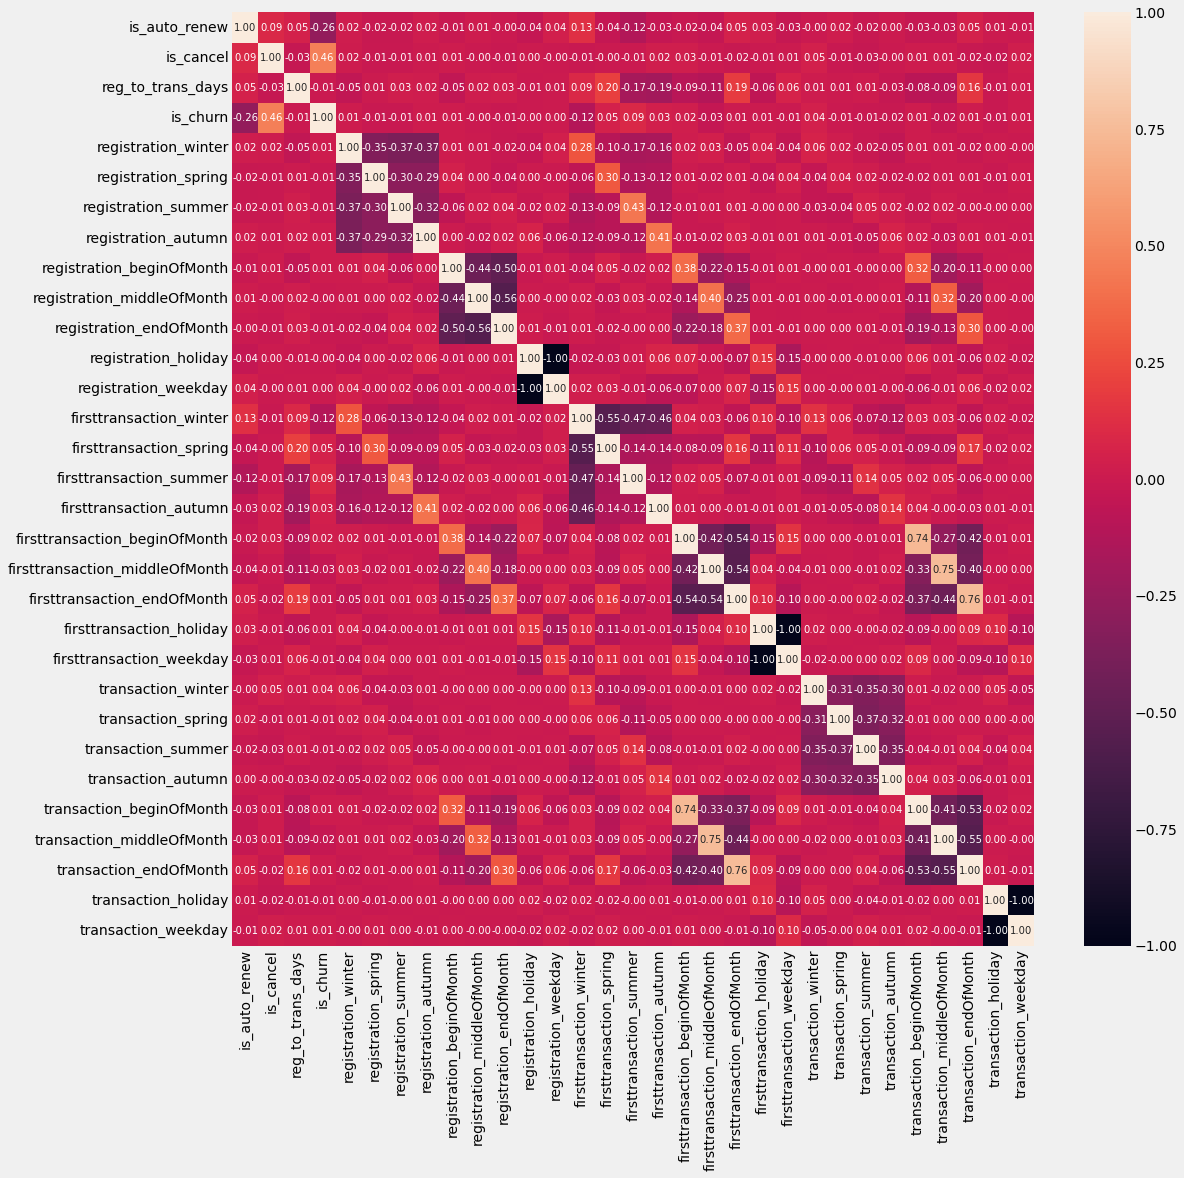

In [256]:
#Visualize correlation of SOME pairs of features
plt.subplots(figsize=(16,16))
#corr = df.corr(method='pearson') # Too long and cannot see details
# Better take a few columns for visualization
df_part = df.iloc[:,0:31]
corr = df_part.corr(method='pearson') # Make sure to include label column[idx_churn]
df_part.head()
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

Churn label `is_churn` is best correlated with feature `is_cancel` (r = 0.46). List of features in decreasing r:

#### 3.3.2 Information value

In [257]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(X, Y, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while (np.abs(r) < 1) & (n > 0):
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(X, Y):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT) # Weight of Evidence
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0] # X, y names
    final = (re.findall(r"[\w']+", vars_name))[-1] # y name
    
    x = df1.dtypes.index # X column names
    count = -1
    for i in x:
        print(i) # current feature
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and no. of unique values > 2 (non-binary)")
                conv = mono_bin(df1[i], target)
            else:
                #print("Non-number or a binary feature")
                conv = char_bin(df1[i], target)
            conv["VAR_NAME"] = i
            count = count + 1
                
            if count == 0:
                iv_df = conv # IV for each category
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()}) # maximum IV for each variable
    iv = iv.reset_index()
    return(iv_df,iv)

In [260]:
#csv = "./data/df_20161022_onehot.csv" #csv = "data/df_20161022_1.gender_onehot.featuresmt.csv"
#df = pd.read_csv(csv)
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
df.head()

is_auto_renew  is_cancel  reg_to_trans_days  is_churn  registration_winter  \
0              0          0               4098         0                    0   
1              0          0               4098         0                    0   
2              0          0               4098         0                    0   
4              1          0               4021         1                    0   
5              1          0               4021         0                    0   

   registration_spring  registration_summer  registration_autumn  \
0                    1                    0                    0   
1                    1                    0                    0   
2                    1                    0                    0   
4                    1                    0                    0   
5                    1                    0                    0   

   registration_beginOfMonth  registration_middleOfMonth  ...  \
0                          0                           0  ...   
1                          0                           0  ...   
2                          0                           0  ...   
4                          0                           0  ...   
5                          0                           0  ...   

   transaction_DayofMonth_29  transaction_DayofMonth_30  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
4                          0                          0   
5                          0                          1   

   transaction_DayofMonth_31  transaction_DayOfWeek_0  \
0                          0                        0   
1                          0                        1   
2                          0                        0   
4                          1                        0   
5                          0                        0   

   transaction_DayOfWeek_1  transaction_DayOfWeek_2  transaction_DayOfWeek_3  \
0                        1                        0                        0   
1                        0                        0                        0   
2                        1                        0                        0   
4                        1                        0                        0   
5                        1                        0                        0   

   transaction_DayOfWeek_4  transaction_DayOfWeek_5  transaction_DayOfWeek_6  
0                        0                        0                        0  
1                        0                        0                        0  
2                        0                        0                        0  
4                        0                        0                        0  
5                        0                        0                        0  

[5 rows x 371 columns]

Taking 70% for training set and 30% for test set.

In [261]:
# Train-test split first:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 11986
Test samples: 5138


In [262]:
final_iv, IV = data_vars(X_train, y_train) # as per sample

is_auto_renew
is_cancel
reg_to_trans_days
0    0.121663
1   -0.192965
dtype: float64
registration_winter
registration_spring
registration_summer
registration_autumn
registration_beginOfMonth
registration_middleOfMonth
registration_endOfMonth
registration_holiday
registration_weekday
firsttransaction_winter
firsttransaction_spring
firsttransaction_summer
firsttransaction_autumn
firsttransaction_beginOfMonth
firsttransaction_middleOfMonth
firsttransaction_endOfMonth
firsttransaction_holiday
firsttransaction_weekday
transaction_winter
transaction_spring
transaction_summer
transaction_autumn
transaction_beginOfMonth
transaction_middleOfMonth
transaction_endOfMonth
transaction_holiday
transaction_weekday
num_25_av7
0    0.185041
1   -0.220062
dtype: float64
num_50_av7
0    0.193310
1   -0.238095
dtype: float64
num_75_av7
0    0.189187
1   -0.241496
dtype: float64
num_985_av7
0    0.232907
1   -0.311351
dtype: float64
num_100_av7
0    0.254457
1   -0.329008
dtype: float64
num_unq_av7
0    0.

In [263]:
final_iv

VAR_NAME    MIN_VALUE      MAX_VALUE  COUNT  EVENT  \
0                     is_auto_renew     0.000000       0.000000   1686  419.0   
1                     is_auto_renew     1.000000       1.000000  10300  527.0   
2                         is_cancel     0.000000       0.000000  11454  587.0   
3                         is_cancel     1.000000       1.000000    532  359.0   
4                 reg_to_trans_days     0.000000     726.000000   6970  615.0   
5                 reg_to_trans_days   729.000000    4448.000000   5016  331.0   
6               registration_winter     0.000000       0.000000   8340  623.0   
7               registration_winter     1.000000       1.000000   3646  323.0   
8               registration_spring     0.000000       0.000000   9404  769.0   
9               registration_spring     1.000000       1.000000   2582  177.0   
10              registration_summer     0.000000       0.000000   9074  730.0   
11              registration_summer     1.000000       1.000000   2912  216.0   
12              registration_autumn     0.000000       0.000000   9140  716.0   
13              registration_autumn     1.000000       1.000000   2846  230.0   
14        registration_beginOfMonth     0.000000       0.000000   8569  647.0   
15        registration_beginOfMonth     1.000000       1.000000   3417  299.0   
16       registration_middleOfMonth     0.000000       0.000000   8058  636.0   
17       registration_middleOfMonth     1.000000       1.000000   3928  310.0   
18          registration_endOfMonth     0.000000       0.000000   7345  609.0   
19          registration_endOfMonth     1.000000       1.000000   4641  337.0   
20             registration_holiday     0.000000       0.000000   8705  695.0   
21             registration_holiday     1.000000       1.000000   3281  251.0   
22             registration_weekday     0.000000       0.000000   3281  251.0   
23             registration_weekday     1.000000       1.000000   8705  695.0   
24          firsttransaction_winter     0.000000       0.000000   4253  512.0   
25          firsttransaction_winter     1.000000       1.000000   7733  434.0   
26          firsttransaction_spring     0.000000       0.000000  10272  758.0   
27          firsttransaction_spring     1.000000       1.000000   1714  188.0   
28          firsttransaction_summer     0.000000       0.000000  10683  747.0   
29          firsttransaction_summer     1.000000       1.000000   1303  199.0   
30          firsttransaction_autumn     0.000000       0.000000  10750  821.0   
31          firsttransaction_autumn     1.000000       1.000000   1236  125.0   
32    firsttransaction_beginOfMonth     0.000000       0.000000   8486  633.0   
33    firsttransaction_beginOfMonth     1.000000       1.000000   3500  313.0   
34   firsttransaction_middleOfMonth     0.000000       0.000000   8412  708.0   
35   firsttransaction_middleOfMonth     1.000000       1.000000   3574  238.0   
36      firsttransaction_endOfMonth     0.000000       0.000000   7074  551.0   
37      firsttransaction_endOfMonth     1.000000       1.000000   4912  395.0   
38         firsttransaction_holiday     0.000000       0.000000   7981  620.0   
39         firsttransaction_holiday     1.000000       1.000000   4005  326.0   
40         firsttransaction_weekday     0.000000       0.000000   4005  326.0   
41         firsttransaction_weekday     1.000000       1.000000   7981  620.0   
42               transaction_winter     0.000000       0.000000   9248  673.0   
43               transaction_winter     1.000000       1.000000   2738  273.0   
44               transaction_spring     0.000000       0.000000   9002  705.0   
45               transaction_spring     1.000000       1.000000   2984  241.0   
46               transaction_summer     0.000000       0.000000   8531  702.0   
47               transaction_summer     1.000000       1.000000   3455  244.0   
48               transaction_autumn     0.000000       0.0

In [264]:
IV

VAR_NAME            IV
0              actual_amount_paid_0  8.395953e-01
1            actual_amount_paid_100  2.338933e-05
2            actual_amount_paid_119  5.934927e-02
3            actual_amount_paid_120  8.205056e-09
4           actual_amount_paid_1200  3.783269e-03
5            actual_amount_paid_129  8.108959e-02
6            actual_amount_paid_134  3.282171e-08
7            actual_amount_paid_149  8.383919e-02
8            actual_amount_paid_150  1.591034e-02
9           actual_amount_paid_1599  9.083278e-03
10          actual_amount_paid_1788  8.149532e-02
11           actual_amount_paid_180  6.109656e-03
12          actual_amount_paid_2000  1.118014e-06
13           actual_amount_paid_298  3.282171e-08
14           actual_amount_paid_300  2.954489e-07
15            actual_amount_paid_35  1.256405e-04
16           actual_amount_paid_447  1.118014e-06
17           actual_amount_paid_477  1.067448e-03
18           actual_amount_paid_480  7.385219e-08
19            actual_amount_paid_50  7.385219e-08
20           actual_amount_paid_500  8.205056e-09
21           actual_amount_paid_536  1.392740e-02
22           actual_amount_paid_799  5.124715e-04
23           actual_amount_paid_894  2.197808e-02
24           actual_amount_paid_930  0.000000e+00
25            actual_amount_paid_99  4.460630e-01
26                             bd_0  1.339653e-02
27                            bd_15  1.118014e-06
28                            bd_16  6.844363e-04
29                            bd_17  5.367164e-03
30                            bd_18  1.006504e-02
31                            bd_19  8.096545e-04
32                            bd_20  3.635036e-03
33                            bd_21  1.156150e-02
34                            bd_22  1.872923e-03
35                            bd_23  1.606633e-03
36                            bd_24  2.649886e-04
37                            bd_25  1.985398e-03
38                            bd_26  2.208750e-05
39                            bd_27  1.485164e-04
40                            bd_28  2.072624e-03
41                            bd_29  9.207095e-04
42                            bd_30  7.587025e-04
43                            bd_31  1.025203e-04
44                            bd_32  5.546412e-04
45                            bd_33  3.370056e-04
46                            bd_34  3.572836e-04
47                            bd_35  2.213381e-03
48                            bd_36  1.733275e-03
49                            bd_37  4.054149e-06
50                            bd_38  5.643038e-04
51                            bd_39  1.256229e-03
52                            bd_40  1.238814e-06
53                            bd_41  2.196525e-03
54                            bd_42  1.062309e-07
55                            bd_43  4.975009e-04
56                            bd_44  7.940207e-04
57                            bd_45  0.000000e+00
58                            bd_46  4.277216e-03
59                            bd_47  2.046592e-03
60                            bd_48  9.383334e-05
61                            bd_49  3.593971e-06
62                            bd_50  3.477554e-05
63                            bd_51  6.909218e-06
64                            bd_52  1.489761e-03
65                            bd_53  1.545800e-03
66                            bd_54  1.025675e-03
67                            bd_55  3.240427e-04
68                            bd_56  4.839190e-05
69                            bd_58  4.538904e-07
70                            bd_59  2.522707e-03
71                            bd_60  6.648504e-07
72                            bd_70  3.845681e-05
73                            bd_97  2.101923e-06
74                           city_0  7.167916e-02
75                           city_1  1.175549e-01
76                          city_10  9.662236e-05
77                          city_11  1.686451e-03
78                          city_12  5.137902e-04
79                         

In [265]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']) # List of information-rich features
Xiv = X_train[features]
print("No. of information-rich features:",Xiv.shape[1])
print("Records:",Xiv.shape[0])
Xiv.head()

No. of information-rich features: 82
Records: 11986


actual_amount_paid_119  actual_amount_paid_129  actual_amount_paid_149  \
13296                       0                       0                       1   
4227                        0                       0                       0   
20097                       0                       0                       1   
4255                        0                       0                       1   
15842                       0                       0                       0   

       actual_amount_paid_150  actual_amount_paid_1788  \
13296                       0                        0   
4227                        1                        0   
20097                       0                        0   
4255                        0                        0   
15842                       0                        0   

       actual_amount_paid_536  actual_amount_paid_894  actual_amount_paid_99  \
13296                       0                       0                      0   
4227                        0                       0                      0   
20097                       0                       0                      0   
4255                        0                       0                      0   
15842                       0                       0                      1   

       bd_0  bd_18  ...  transaction_DayOfWeek_1  transaction_DayOfWeek_5  \
13296     1      0  ...                        1                        0   
4227      1      0  ...                        0                        0   
20097     1      0  ...                        0                        0   
4255      1      0  ...                        1                        0   
15842     1      0  ...                        0                        0   

       transaction_DayofMonth_21  transaction_DayofMonth_29  \
13296                          0                          0   
4227                           0                          0   
20097                          0                          0   
4255                           0                          0   
15842                          0                          0   

       transaction_DayofMonth_30  transaction_Month_12  transaction_Month_3  \
13296                          0                     0                    0   
4227                           0                     0                    1   
20097                          0                     0                    0   
4255                           0                     0                    0   
15842                          0                     0                    0   

       transaction_Month_6  transaction_Month_7  transaction_winter  
13296                    0                    0                   0  
4227                     0                    0                   0  
20097                    0                    0                   1  
4255                     0                    0                   0  
15842                    0                    0                   1  

[5 rows x 82 columns]

#### 3.3.3 Variance Inflation Factor

In [266]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        vif_max = vif['VIFactor'].max()
        if vif_max > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif_max]['features'].values[0], vif_max))
            df = df.drop(vif[vif['VIFactor'] == vif_max]['features'].values[0], axis=1) # drop column with too high VIF
            max_vif = vif_max
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

In [267]:
# If some variables are highly correlated, eliminate few of them

# Show VIF for each feature
for i in range(Xiv.shape[1]):
    print((i, variance_inflation_factor(Xiv.values, i) ))

# Remove features with too high VIF
#Xiv = Xiv._get_numeric_data()
X_train, vif = iterate_vif(Xiv)
print("Features with VIF <= vif_threshold:",X_train.shape[1])

# Filter features in entire dataset X and testing X_test
X = X[X_train.columns]
X_test = X_test[X_train.columns]
print("X.shape =",X.shape)
print("X_train.shape =",X_train.shape)
print("X_test.shape =",X_test.shape)

(0, 6.76091401544863)
(1, 7.148109095350705)
(2, 58.12798297929665)
(3, 3.404788270545742)
(4, 15.94243229506778)
(5, 7.789327350397767)
(6, 27.64879731971378)
(7, 19.738679947244258)
(8, 28.35792640046867)
(9, 1.1413064905922685)
(10, 1.1640298032346434)
(11, inf)
(12, 9.835898952894025)
(13, 162.8284027904057)
(14, 12.982925523727076)
(15, 1.6380049573123898)
(16, 1.1116631407133613)
(17, 1.1122094160786271)
(18, 1.1193429910872954)
(19, 15.382706389490547)
(20, 1.542172570528892)
(21, 1.2283478451282996)
(22, 1.5201359156559953)
(23, 1.473241312350899)
(24, 1.6391137680383283)
(25, 3.892644671909339)
(26, 2.9703944699147895)
(27, 24.851348848239333)
(28, 2.2414263275351805)
(29, 24.73333624325196)
(30, 143.75007465877638)
(31, 251.92144707422167)
(32, 249.8150196091194)
(33, 89.77426306138558)
(34, 23.945237063283816)
(35, 8.70689039801804)
(36, 19.324036946642394)
(37, 24.90875007349522)
(38, 9.411950389165712)
(39, 20.924203730014955)
(40, 20.441503774437276)
(41, 8.50375261135581

In [268]:
y = pd.DataFrame({'is_churn':y})
Xy = pd.concat([pd.DataFrame(X),y],axis=1)
Xy.shape

(20735, 54)

In [269]:
# Save IV, VIF - filtered data
csv = "data/df_20161022_f.csv"
if not Path(csv).is_file():
    Xy.to_csv(csv, index=False)

### 3.4 Standardization of continuous variables
<b>Standardization:</b> This technique transforms the data to have a mean of 0 and a standard deviation of 1.
Standardization is performed after cutting off on some date, since in reality there will be no access to future data. We will see how to select the strategies based on Gaussian and Non-Gaussian distribution of the features to improve the performance of the Logistic Regression model.

https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f

In [2]:
standardize = False # also check if input was already standardized
if standardize:
    csv = "data/df_20161022_f.std.csv"
    cols2standardize = [col for col in X.columns if col in ['reg_to_trans_days','num_25_av7','num_50_av7','num_75_av7','num_985_av7',
    'num_100_av7','num_25_av30','num_50_av30','num_75_av30','num_985_av30','num_100_av30','num_25_av90','num_50_av90',
    'num_75_av90','num_985_av90','num_100_av90','num_unq_av7','num_unq_av30','num_unq_av90',
    'total_secs_av7','total_secs_av30','total_secs_av90'] ]
    print("Standardize continuous features:",cols2standardize)
    print(f"No. of features to standardize: {len(cols2standardize)}")
    display(X[cols2standardize].head(1))
    scaler = StandardScaler()
    X_std = pd.DataFrame(scaler.fit_transform(X[cols2standardize]), columns=cols2standardize) # standardized continuous variables
    X_nostd = X.drop(cols2standardize, axis=1) # all other variables
    X = pd.concat([X_nostd,pd.DataFrame(X_std)], axis=1) # concatenate columns
    print(f"For predictions, use\nscaler = StandardScaler(with_mean = {scaler.mean_}, with_std = {scaler.scale_})")
    # np.mean(X[cols2standardize]); to be re-used in predictions
    print("X is standardized (mean = 0, sd = 1), X.shape =",X.shape)
    pd.concat([pd.DataFrame(X),pd.DataFrame(y, columns=['is_churn'])],axis=1).to_csv(csv, index=False)
else: print("X is not standardized, but check if it was already standardized")

X is not standardized, but check if it was already standardized


## 4. Modeling
### 4.1 Data and Quality metrics

In [101]:
standardize = False # if to standardize continuous features (float, int)
# Import data
if standardize:
    csv = "data/df_20161022_f.std.csv"
else:
    csv = "data/df_20161022_f.csv" #csv = "./data/df_20161022_onehot.csv, data/df_20161022_1.gender_onehot.featuresmt.csv"
df = pd.read_csv(csv)

# Optionally drop some columns
drop_cols = False
if drop_cols:
    df = df.drop(['registration_Month','registration_winter','registration_spring','registration_summer',
              'registration_autumn','registration_DayofMonth','registration_beginOfMonth','registration_middleOfMonth',
             'registration_endOfMonth','registration_DayOfWeek','registration_holiday','registration_weekday',
             'firsttransaction_Month','firsttransaction_winter','firsttransaction_spring','firsttransaction_summer',
             'firsttransaction_autumn','firsttransaction_DayofMonth','firsttransaction_beginOfMonth',
             'firsttransaction_middleOfMonth','firsttransaction_endOfMonth','firsttransaction_DayOfWeek','firsttransaction_holiday',
             'firsttransaction_weekday','reg_to_trans_days1','transaction_Month1','transaction_winter1','transaction_spring1',
             'transaction_summer1','transaction_autumn1','transaction_DayofMonth1','transaction_beginOfMonth1','transaction_middleOfMonth1',
             'transaction_endOfMonth1','transaction_DayOfWeek1','transaction_holiday1','transaction_weekday1']
             ,axis=1)
pd.set_option('display.max_seq_items', None)
#print(df.columns)

# Explanatory and response variables
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
print("No. of features:",X.shape[1])
print("No. of records:",X.shape[0])
df.head()

# Train-Test split: Taking 70% for training set and 30% for test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

No. of features: 53
No. of records: 17124
Train samples: 11986
Test samples: 5138


#### Quality Metrics

In [102]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, cmap=plt.cm.YlGn) #ax.imshow(cm, cmap=plt.cm.Greens)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Loyal 0', 'Churn 1'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, round(cm[i, j],3), ha='center', va='center', color='black', size=15) # counts
    plt.show();
    return tn,fp,fn,tp

def scores_all(X_test, y_test, model, prnt=False):
    '''Quality metrics: roc_auc, accuracy, tnr, tpr, precision, f1, MCC. Inputs: X_test, y_test, model'''
    y_score = model.predict_proba(X_test)[:,1] # predicted probabilities of y=1
    y_pred = model.predict(X_test) # predicted labels 0,1
    cm = confusion_matrix(y_test, y_pred)
    global tn, fp, fn, tp
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    
    roc_auc = roc_auc_score(y_test, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    if prnt == True:
        dr = 6 # rounding digits
        print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
        print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC;

### 4.2 Dummy Regression

In [273]:
dummy = DummyClassifier(strategy = 'most_frequent', random_state=0).fit(X_train, y_train);
print("Benchmark accuracy =",dummy.score(X_test, y_test))

Benchmark accuracy = 0.920591669910471


This is the same as the proportion of no churn in the test set:

In [274]:
print("Proportion of 0:", 1-np.sum(y_test)/len(y_test))

Proportion of 0: 0.920591669910471


### 4.3 Logistic regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

#### Custom hyperparameters

In [13]:
?LogisticRegression

[[TN, FP], [FN, TP]] =
 [[3923  807]
 [ 109  299]]


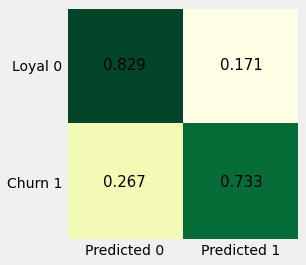

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.845600	0.821721	0.829387	0.732843	0.270344	0.394980	0.369860


In [24]:
# Create and train Logistic Regression model using 70% training set
if standardize: #Optimized for scaled input
    lr = LogisticRegression(solver='lbfgs', max_iter=20, C=70, class_weight='balanced', random_state=0)
else: # Optimized for unscaled input
    lr = LogisticRegression(solver='liblinear', max_iter=10000, C=7.4, class_weight={0:1, 1:10}, random_state=0)
# class_weight={0:1, 1:1}
lr.fit(X_train, y_train)

# Quality metrics
y_pred = lr.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, lr, prnt=True)
#print(classification_report(y_test, y_pred))

In [ ]:
solver='liblinear', max_iter=100, C=9.9, class_weight={0:1, 1:11}, random_state=0
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.845580	0.810043	0.815011	0.752451	0.259729	0.386164	0.364553

lr = LogisticRegression(solver='lbfgs', max_iter=10000, C=6.3, class_weight={0:1, 1:16}, random_state=0)
0.845916	0.749513	0.743975	0.813725	0.215165	0.340338	0.328949
solver='lbfgs', max_iter=10000, C=6.3, class_weight={0:1, 1:19}, random_state=0
0.845928	0.699299	0.686258	0.850490	0.189514	0.309960	0.303019

In [276]:
# Details of the Logistic Regression model
print("Distinct values that y takes:",lr.classes_)
# probability of y=0 (1st column) and y=1 (2nd column):
print("Prediction Probabilities (first three values):\n", lr.predict_proba(X)[:3])
print("Regression Coefficients:\n")
print("Intercept b0 =", lr.intercept_[0])
print("Coefficients b =", lr.coef_)

Distinct values that y takes: [0 1]
Prediction Probabilities (first three values):
 [[0.04490628 0.95509372]
 [0.19250998 0.80749002]
 [0.18010564 0.81989436]]
Regression Coefficients:

Intercept b0 = -0.29132634903429383
Coefficients b = [[-2.28001406e+00 -9.59088659e-01  8.44295246e-01  2.83713446e-01
  -2.01324736e+00 -7.92046278e-02 -2.51879284e-01 -5.11548154e-01
   2.14556615e+00 -3.99174267e-01  7.77961340e-01  1.22650388e+00
   1.50886282e-01 -6.16653655e-02  1.67579104e-01  5.36197633e-01
   5.64018260e-01  8.23345745e-01 -3.17078001e-01  2.61749613e-01
   4.85614570e-01  9.99157878e-02 -7.13818670e-03 -2.64686405e-02
   1.81688466e-02  2.35055034e-02 -8.40865934e-02 -7.76152329e-02
   1.80963178e-02  2.33050938e+00  1.41314259e+00 -4.50529312e-01
   1.14774104e+00 -4.41340636e-01  1.07305897e+00  7.75533055e-01
  -1.45971777e+00  1.43851419e+00  3.29824118e+00  7.22871618e-06
   7.06764146e-02  2.00568796e-01  5.11158397e-01  4.04814346e-01
  -2.64252974e-01 -9.58176126e-01  

#### Hyperparameter optimization: max_iter and solver

In [43]:
# Sweeping over a grid of hyperparameters
# Initialize score dataframe
#standardize = False
if standardize:
    csv_scores = 'data/LogisticRegression.solver_maxiter.std.csv'
else:
    csv_scores = 'data/LogisticRegression.solver_maxiter.csv'
#csv_scores = 'data/LogisticRegression.solver_maxiter.std.csv'
if os.path.exists(csv_scores):
    scores = pd.read_csv(csv_scores)
    #display(scores.head())
    display(scores.tail())
else:
    scores = pd.DataFrame(columns=['solver','max_iter','roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])

solver  max_iter   roc_auc  accuracy       tnr       tpr  precision  \
2695   saga      9800  0.841249  0.923316  0.987526  0.178922    0.55303   
2696   saga      9850  0.841249  0.923316  0.987526  0.178922    0.55303   
2697   saga      9900  0.841249  0.923316  0.987526  0.178922    0.55303   
2698   saga      9950  0.841249  0.923316  0.987526  0.178922    0.55303   
2699   saga     10000  0.841249  0.923316  0.987526  0.178922    0.55303   

           f1       mcc  
2695  0.27037  0.284451  
2696  0.27037  0.284451  
2697  0.27037  0.284451  
2698  0.27037  0.284451  
2699  0.27037  0.284451

In [ ]:
# Grid sweeping of hyperparameters
for max_iter in np.concatenate([np.arange(1,200+1,1), np.arange(205,1000+1,5), np.arange(1050,10000+1,50)]): # np.arange(1,200+1,1)
    for solver in ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']:
        # Create and train the Logistic Regression model
        lr = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0).fit(X_train,y_train)
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test,y_test, lr);
        scores = scores.append({'solver':solver,'max_iter':max_iter,'roc_auc':roc_auc,'accuracy':accuracy,
                          'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
        scores.to_csv(csv_scores, index=False)
scores.sort_values(['solver','max_iter'], inplace=True)
scores.to_csv(csv_scores, index=False)
scores.tail()

In [44]:
print("Currently optimal hyperparameters and performance:")
auc_max = -np.inf
for solver in ['newton-cg','liblinear','lbfgs','sag','saga']:
    ds = scores.loc[scores['solver']==solver]
    idx_opt = np.argmax(ds['roc_auc'])
    auc_opt = ds.iloc[idx_opt]['roc_auc']
    if auc_opt > auc_max:
        auc_max = auc_opt
        idx_max = idx_opt
        solver_max = solver
    print(ds.iloc[idx_opt]) # showing optimum for each solver
print(scores.loc[scores['solver']==solver_max].iloc[idx_max])
scores.loc[ (scores['solver']==solver_max) & (scores['max_iter'] == 69), ['solver','max_iter','roc_auc'] ] # watch a record

Currently optimal hyperparameters and performance:
solver       newton-cg
max_iter            11
roc_auc       0.841376
accuracy      0.923122
tnr           0.987315
tpr           0.178922
precision     0.548872
f1            0.269871
mcc           0.283048
Name: 1090, dtype: object
solver       liblinear
max_iter             7
roc_auc       0.841436
accuracy      0.923316
tnr           0.987526
tpr           0.178922
precision      0.55303
f1             0.27037
mcc           0.284451
Name: 546, dtype: object
solver          lbfgs
max_iter           20
roc_auc      0.841738
accuracy     0.923316
tnr          0.988795
tpr          0.164216
precision    0.558333
f1           0.253788
mcc          0.273922
Name: 19, dtype: object
solver            sag
max_iter          790
roc_auc       0.84131
accuracy     0.923316
tnr          0.987526
tpr          0.178922
precision     0.55303
f1            0.27037
mcc          0.284451
Name: 1937, dtype: object
solver           saga
max_iter        

solver  max_iter   roc_auc
68  lbfgs        69  0.841343

In [8]:
if standardize:
    csv_scores = 'data/LogisticRegression.solver_maxiter.std.csv'
else:
    csv_scores = 'data/LogisticRegression.solver_maxiter.csv'
#csv_scores = 'data/LogisticRegression.solver_maxiter.std.csv'
if os.path.exists(csv_scores):
    scores = pd.read_csv(csv_scores)
    #display(scores.head())
    display(scores.tail())
else:
    scores = pd.DataFrame(columns=['solver','max_iter','roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])


solver  max_iter   roc_auc  accuracy  tnr  tpr  precision   f1  mcc
2695   saga      9800  0.637991  0.920592  1.0  0.0        NaN  0.0  NaN
2696   saga      9850  0.637991  0.920592  1.0  0.0        NaN  0.0  NaN
2697   saga      9900  0.637991  0.920592  1.0  0.0        NaN  0.0  NaN
2698   saga      9950  0.637991  0.920592  1.0  0.0        NaN  0.0  NaN
2699   saga     10000  0.637991  0.920592  1.0  0.0        NaN  0.0  NaN

Plot scores: data/LogisticRegression.solver_maxiter.csv


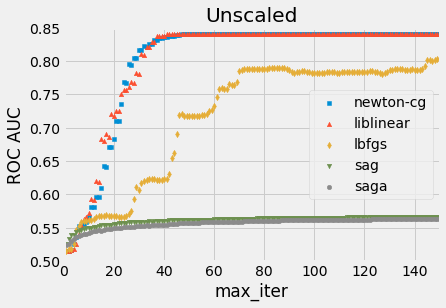

In [130]:
standardize = False
if standardize:
    csv_scores = 'data/LogisticRegression.solver_maxiter.std.csv'
else:
    csv_scores = 'data/LogisticRegression.solver_maxiter.csv'
print("Plot scores:",csv_scores)
auc = pd.read_csv(csv_scores)
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
auc_lbfgs = auc.loc[auc['solver'] == 'lbfgs']
auc_newton = auc.loc[auc['solver'] == 'newton-cg']
auc_liblinear = auc.loc[auc['solver'] == 'liblinear']
auc_sag = auc.loc[auc['solver'] == 'sag']
auc_saga = auc.loc[auc['solver'] == 'saga']
markers = ['s','^','d','v','o']
for i,ds in enumerate([auc_newton, auc_liblinear, auc_lbfgs, auc_sag, auc_saga]):
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = markers[i]);
plt.ylim([0.5,0.85]) # relative to dummy regressor #0.920591669910471,0.953
plt.xlim([0,150])
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
if standardize:
    plt.title("Standardized");
else:
    plt.title("Unscaled");

Plot scores: data/LogisticRegression.solver_maxiter.csv


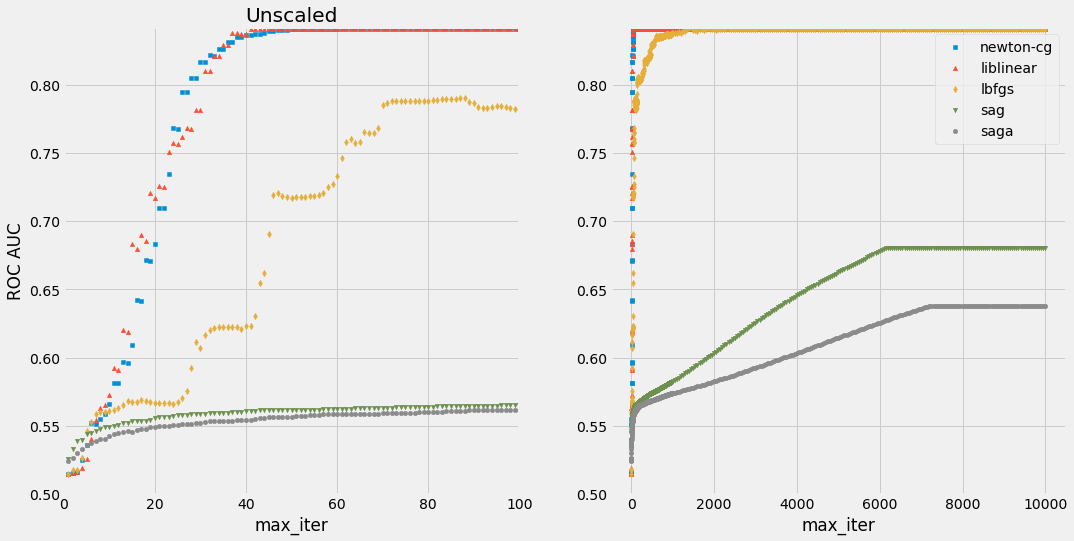

In [9]:
print("Plot scores:",csv_scores)
auc = pd.read_csv(csv_scores)
fig, ax = plt.subplots(1,2,figsize=(16,8),sharey=False)#True
ax[0].set_xlabel('max_iter');
ax[0].set_ylabel('ROC AUC');
auc_lbfgs = auc.loc[auc['solver'] == 'lbfgs']
auc_newton = auc.loc[auc['solver'] == 'newton-cg']
auc_liblinear = auc.loc[auc['solver'] == 'liblinear']
auc_sag = auc.loc[auc['solver'] == 'sag']
auc_saga = auc.loc[auc['solver'] == 'saga']

ax[0].set_xlim([0,100])
ax[0].set_ylim([0.5,0.842])
ax[1].set_ylim([0.5,0.842])

markers = ['s','^','d','v','o']
for i,ds in enumerate([auc_newton, auc_liblinear, auc_lbfgs, auc_sag, auc_saga]):
    ax[0].scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = markers[i]);
    ax[1].scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = markers[i]);
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
if standardize:
    ax[0].set_title("Standardized");
else:
    ax[0].set_title("Unscaled");

Plot scores: data/LogisticRegression.solver_maxiter.std.csv


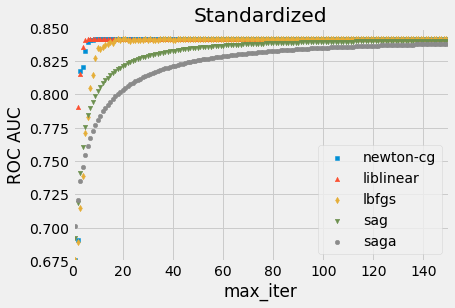

In [133]:
standardize = True
if standardize:
    csv_scores = 'data/LogisticRegression.solver_maxiter.std.csv'
else:
    csv_scores = 'data/LogisticRegression.solver_maxiter.csv'
print("Plot scores:",csv_scores)
auc = pd.read_csv(csv_scores)
plt.xlabel('max_iter');
plt.ylabel('ROC AUC');
auc_lbfgs = auc.loc[auc['solver'] == 'lbfgs']
auc_newton = auc.loc[auc['solver'] == 'newton-cg']
auc_liblinear = auc.loc[auc['solver'] == 'liblinear']
auc_sag = auc.loc[auc['solver'] == 'sag']
auc_saga = auc.loc[auc['solver'] == 'saga']
markers = ['s','^','d','v','o']
for i,ds in enumerate([auc_newton, auc_liblinear, auc_lbfgs, auc_sag, auc_saga]):
    plt.scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = markers[i]);
plt.ylim([0.675,0.85]) # relative to dummy regressor #0.920591669910471,0.953
plt.xlim([0,150])
plt.ylabel('ROC AUC')
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
if standardize:
    plt.title("Standardized");
else:
    plt.title("Unscaled");

Plot scores: data/LogisticRegression.solver_maxiter.std.csv


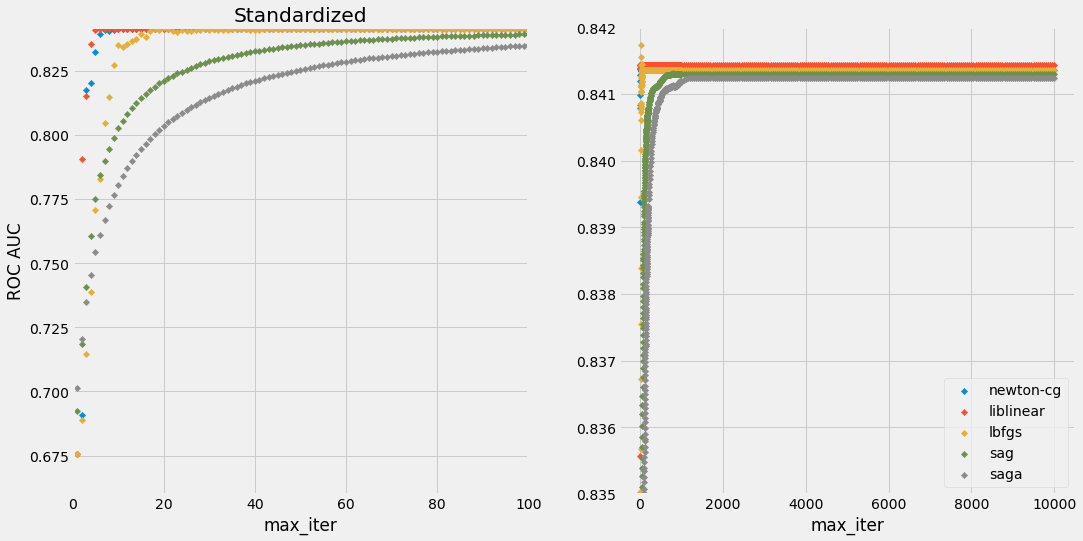

In [102]:
print("Plot scores:",csv_scores)
auc = pd.read_csv(csv_scores)
fig, ax = plt.subplots(1,2,figsize=(16,8),sharey=False)#True
ax[0].set_xlabel('max_iter');
ax[0].set_ylabel('ROC AUC');
auc_lbfgs = auc.loc[auc['solver'] == 'lbfgs']
auc_newton = auc.loc[auc['solver'] == 'newton-cg']
auc_liblinear = auc.loc[auc['solver'] == 'liblinear']
auc_sag = auc.loc[auc['solver'] == 'sag']
auc_saga = auc.loc[auc['solver'] == 'saga']

ax[0].set_xlim([0,100])
ax[0].set_ylim([0.66,0.842])
ax[1].set_ylim([0.835,0.842])

markers = ['s','^','d','v','o']
for i,ds in enumerate([auc_newton, auc_liblinear, auc_lbfgs, auc_sag, auc_saga]):
    ax[0].scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = markers[i]);
    ax[1].scatter(ds['max_iter'], ds['roc_auc'], s=20, marker = markers[i]);
plt.xlabel('max_iter')
plt.legend(['newton-cg','liblinear','lbfgs','sag','saga']);
if standardize:
    ax[0].set_title("Standardized");
else:
    ax[0].set_title("Unscaled");

#### Importance of scaling
Comparison of ROC AUC plots for unscaled and standardized input data shows importance of scaling for logistic regression models. Standardization leads to a much faster convergence (fewer iterations `max_iter`); moreover, solvers `sag` and `saga` slowly converge to a considerably lower AUC in absence of scaling. The highest ROC AUC is 0.855872, achieved for standardized input, while all other solvers give very close maximal AUC values. The optimal combination of solver and number of iterations is the default solver 'lbfgs' with 'max_iter'=37. For unscaled input, 'newton-cg' solver is a clear winner, achieving almost the same AUC value as in the case of standardized input. Solvers 'liblinear' and 'lbfgs' have slightly lower AUC, while 'sag' and 'saga' give unacceptably low AUC. Comparison of the numbers of iterations before convergence (to 6 decimal digits) for unscaled vs standardized input is shown below.

#### Convergence of Logistic Regression solvers
Results for 70% train - 30% test split.

|<b>solver|unscaled|standardized|
|:--------|:-------:|:------:|
|newton-cg|72   |16|
|<b>liblinear|44   |<b>7|
|lbfgs |2150 |78|
|sag      |6200  |795|
|saga     |7250  |1200|

#### ROC AUC for optimized `max_steps`: Comparison of unscaled and standardized data
|<b>solver|unscaled| |standardized| |
|:--------|:-------:|:------:|:------:|:------:|
|         |<b>max_iter|<b>roc_auc |<b>max_iter|<b>roc_auc |
|newton-cg|72   |0.841303|11 |0.841376|
|liblinear|10000|0.841067| 7 |0.841436|
|<b>lbfgs |1450 |<b>0.842241|20 |0.841738|
|sag      |6200  |0.680344| 790 |0.841310|
|saga     |7250  |0.637991| 1200 |0.841249|
    
#### Detailed comparison of quality metrics for unscaled vs standardized data
|<b>solver|<b>data    |<b>max_iter|<b>roc_auc | accuracy | tnr | tpr | precision |f1|mcc|
|:--------|:------:|:--:|:---------:|:--------:|:---:|:---:|:---------:|::|:-:|
|newton-cg|unscaled|72   |0.841303|0.923122|0.987315|0.178922|0.548872|0.269871|0.283048|
|         |<b>standardized|11|0.841376|0.923122|0.987315|0.178922|0.548872|0.269871|0.283048|
|<b>liblinear|unscaled|41|0.841067|0.923316|0.987738|0.176471|0.553846|0.267658|0.282717|
||<b>standardized|7 |0.841436|0.923316|0.987526|0.178922|0.55303|0.27037|0.284451|
|<b>lbfgs |<b>unscaled|1450|<b>0.842241|0.923316|0.988372|0.169118|0.556452|0.259398|0.277466|
||standardized|20 |0.841738|0.923316|0.988795|0.164216|0.558333|0.253788|0.273922|
|sag      |unscaled|6200  |0.680344|0.920592|1.0|0.0|NaN|0.0|NaN|
||<b>standardized|790 |0.841310|0.923316|0.987526|0.178922|0.55303|0.27037|0.284451|
|saga     |unscaled|7250  |0.637991|0.920592|1.0|0.0|NaN|0.0|NaN|
||<b>standardized|1200 |0.841249|0.923316|0.987526|0.178922|0.55303|0.27037|0.284451|

#### Hyperparameter optimization: regularization strength C

In [45]:
def opt_C_rocauc(C_range, solver='lbfgs', max_iter=100, class_weight=None):
    #solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
    global Rocauc, rocauc # Collected and current AUC values
    '''Optimize regularization parameter C by maximizing ROC AUC in Logistic Regression with Train-Test split.'''
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in C_range: #np.arange(Cmin, Cmax+0.1*Cstep, Cstep):
        lr = LogisticRegression(C=C, solver=solver, max_iter=max_iter, class_weight=class_weight, random_state=0).fit(X_train, y_train)
        #pred = lr.predict(X_test) # predicted values, needed if accuracy
        metric = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]) # ROC AUC score; lr.score(X_test, y_test) if accuracy (proportion of correct predictions)
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Current optimal C =',C_opt)
    print('Current highest ROC AUC =',rocauc_opt)
    # Save ROC AUC scores
    try: Rocauc
    except NameError: # if variable does not exist, initialize it
        Rocauc=rocauc
    else: # if variable exists, append to it
        Rocauc=pd.concat([Rocauc, rocauc], axis=0)
    Rocauc.sort_values(['C'], inplace=True)
    # Plot all ROC AUC scores
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(Rocauc['C'], Rocauc['ROC AUC']); # for current AUC values, use 'rocauc'
    plt.xlabel('C');
    plt.ylabel('ROC AUC');

Current optimal C = 10.0
Current highest ROC AUC = 0.8415259814285122


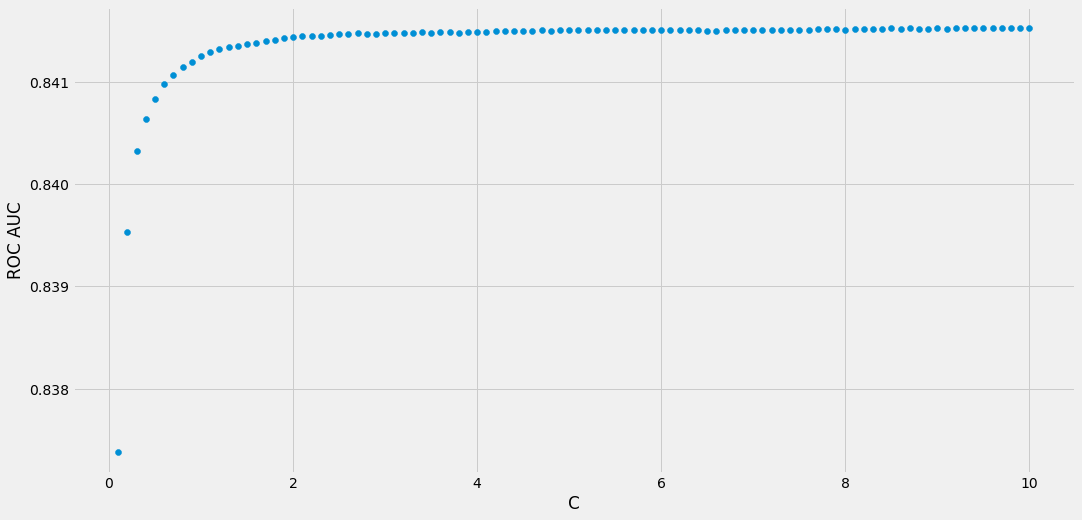

In [67]:
del Rocauc # if changing a hyperparameter (solver, max_iter)
solver = 'saga' # Only one solver at a time due to saving AUC scores
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
max_iter=1200
#C_range = np.concatenate([np.arange(0.001, 0.01+0.0001, 0.001), np.arange(0.02, 0.1+0.0001, 0.01), np.arange(0.2, 1+0.0001, 0.1),
#                np.arange(2, 10+0.0001, 1), np.arange(15, 100+0.0001, 5)])
C_range = np.arange(0.1, 10+0.0001, 0.1)
opt_C_rocauc(C_range, solver=solver, max_iter=max_iter) # Grid optimization
#Rocauc.sort_values(['C'], inplace=True) # Sort AUC by C if adding more values
if standardize:
    scores_csv = "data/LR_C.solver_"+solver+".maxiter_"+str(max_iter)+".std.csv"
else:
    scores_csv = "data/LR_C.solver_"+solver+".maxiter_"+str(max_iter)+".csv"
Rocauc.to_csv(f"data/LR_C.solver_{solver}.maxiter_{max_iter}.csv", index=False)

In [69]:
if standardize:
    #model = LogisticRegression(solver='newton-cg', max_iter=72, C=9.1, random_state=0)
    #model = LogisticRegression(solver='liblinear', max_iter=7, C=9.9, random_state=0)
    #model = LogisticRegression(solver='lbfgs', max_iter=20, C=9.7, random_state=0)
    #model = LogisticRegression(solver='sag', max_iter=790, C=9.3, random_state=0)
    model = LogisticRegression(solver='saga', max_iter=1200, C=10.0, random_state=0)
else:
    #model = LogisticRegression(C=8.7, solver='newton-cg', max_iter=72, random_state=0)
    #model = LogisticRegression(C=6.0, solver='liblinear', max_iter=41, random_state=0)
    #model = LogisticRegression(C=5.9, solver='lbfgs', max_iter=1450, random_state=0)
    #model = LogisticRegression(C=9.5, solver='sag', max_iter=6200, random_state=0)
    model = LogisticRegression(C=8.9, solver='saga', max_iter=7250, class_weight=None, random_state=0)
model.fit(X_train, y_train)
scores_all(X_test, y_test, model, prnt=True)

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.841526	0.923706	0.987104	0.188725	0.557971	0.282051	0.294054


(0.8415259814285122,
 0.9237057220708447,
 0.9871035940803383,
 0.18872549019607843,
 0.5579710144927537,
 0.28205128205128205,
 0.29405381676139714)

#### ROC AUC for unscaled vs standardized data before and after optimization of C
|<b>solver|<b>data    |<b>max_iter|roc_auc | C |<b>roc_auc| increase % |accuracy | tnr | tpr | precision |f1|mcc|
|:--------|:------:|:--:|:---------:|:--------:|:---:|:---:|:---:|:---------:|::|:-:|::|:-:|
|newton-cg|unscaled|72   |0.841303|8.7|<b>0.841835|0.062879|0.922733|0.986681|<b>0.181373|0.540146|<b>0.271560|0.282045|
|         |standardized|11|0.841376|9.1|<b>0.841835|0.054553|0.922733|0.986681|<b>0.181373|0.540146|<b>0.271560|0.282045|
|liblinear|unscaled|41|0.841067|6.0|<b>0.842613|0.183814|0.923316|0.987738|0.176471|0.553846|0.267658|0.282717|
||<b>standardized|7 |0.841436|9.9|0.841824|0.046112|0.922733|0.986681|<b>0.181373|0.540146|0.271560|0.282045|
|<b>lbfgs |unscaled|1450|0.842241|5.9|<b>0.842953|0.084536|0.923316|0.988372|0.169118|0.556452|0.259398|0.277466|
||standardized|20 |0.841738|9.7|0.842100|0.043006|0.923316|0.987949|<b>0.174020|0.554688|<b>0.264925|<b>0.280975|
|sag      |unscaled|6200  |0.680344|9.5|<b>0.680438|0.680345|0.920592|1.0|0.0|NaN|0.0|NaN|
||<b>standardized|790 |0.841310|9.3|0.841631|23.7066|<b>0.923511|0.986892|<b>0.188725|<b>0.553957|<b>0.281536|<b>0.292671|
|saga     |unscaled|7250  |0.637991|8.9|<b>0.638027|0.005643|0.920592|1.0|0.0|NaN|0.0|NaN|
||<b>standardized|1200 |0.841249|10.0|<b>0.841526|0.032927|<b>0.923706|0.987104|<b>0.188725|<b>0.557971|<b>0.282051|<b>0.294054|

Bold font shows values which improved after standardization of input data.

In [75]:
# Find optimal C and ROC AUC values
if standardize:
    scores_csv = "data/LR_C.solver_"+solver+".maxiter_"+str(max_iter)+".std.csv"
else:
    scores_csv = "data/LR_C.solver_"+solver+".maxiter_"+str(max_iter)+".csv"
Rocauc = pd.read_csv(scores_csv)
idx_opt = np.argmax(Rocauc['ROC AUC'])
C_opt = Rocauc['C'].iloc[idx_opt]
auc_max = Rocauc['ROC AUC'].iloc[idx_opt]
print("Optimal C =", C_opt)
print("Max AUC =", auc_max)

Optimal C = 10.0
Max AUC = 0.8415259814285122


Optimization of the regularization parameter 'C' alone has led to only a tiny improvement in ROC-AUC score for `newton-cg`, `liblinear`, and `lbfgs` solvers (with maximal increase of 0.18% for `liblinear` solver), while the accuracy has dropped by -0.063% from 0.9233 to 0.9227.

#### class_weight
ROC AUC slightly increases from 0.84212 to 0.84586 (by 0.444%) with the increase of the `class_weight` for the less numerous churn lable 1, with the optimal setting being `class_weight ='balanced'` (close to `class_weight ={0:1, 1:11}`). However, the accuracy strongly decreases from 0.92312 to 0.80381 (by 12.92%). 

#### Hyperparameter optimization: C and class_weight

In [213]:
standardize=False

False

In [212]:
# Sweeping hyperparameters

# Fixed hyperparameters
solver='saga'  #['lbfgs','liblinear','newton-cg']
max_iter=7250
# Hyperparameter grid
C_val = np.concatenate([np.arange(0.001,0.01,0.001), np.arange(0.01,0.1,0.01), np.arange(0.1,11.01,0.1)])
class_weight_val = np.arange(1,30+1,1)

# Initialize score dataframe
standardize = False
if standardize:
    csv_scores = 'data/LR.C_classweight.solver_'+solver+'_maxiter_'+str(max_iter)+'.std.csv'
else:
    csv_scores = 'data/LR.C_classweight.solver_'+solver+'_maxiter_'+str(max_iter)+'.csv'
if os.path.exists(csv_scores):
    scores = pd.read_csv(csv_scores)
    #display(scores.head())
    #display(scores.tail())
else:
    scores = pd.DataFrame(columns=['C','class_weight','roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])

In [ ]:
# Grid sweeping of hyperparameters
for C in C_val:
    for class_weight in class_weight_val:
        # Create and train the Logistic Regression model
        lr = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0, C=C, class_weight={0:1, 1:class_weight})
        lr.fit(X_train,y_train)
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test,y_test, lr);
        scores = scores.append({'C':C,'class_weight':class_weight,'roc_auc':roc_auc,'accuracy':accuracy,
                          'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
    scores.to_csv(csv_scores, index=False)
scores.sort_values(['C','class_weight'], inplace=True)
#scores.drop_duplicates(subset = ['C','class_weight'], keep = 'first', inplace=True, ignore_index=False)
scores.to_csv(csv_scores, index=False)
scores.tail(2)

In [214]:
scores_opt = scores.iloc[np.argmax(scores['roc_auc'])]
C_opt = scores_opt['C']
class_weight_opt = scores_opt['class_weight']
roc_auc_opt = scores_opt['roc_auc']
print(f"Fixed hyperparameters: solver = {solver}, max_iter = {max_iter}:")
print(f"Currently optimal hyperparameters: C = {C_opt}, class_weight = {class_weight_opt}")
print(f"Currently max. ROC AUC = {roc_auc_opt}")

Fixed hyperparameters: solver = saga, max_iter = 7250:
Currently optimal hyperparameters: C = 7.2, class_weight = 11.0
Currently max. ROC AUC = 0.8456019670024458


In [ ]:
standardize

In [215]:
# Fit the model with optimized hyperparameters
if standardize:
    print("Standardized data.")
    #model = LogisticRegression(solver='newton-cg', max_iter=11, C=7.9, class_weight={0: 1, 1: 11}, random_state=0)
    #model = LogisticRegression(solver='liblinear', max_iter=7, C=9.5, class_weight={0: 1, 1: 11}, random_state=0)
    #model = LogisticRegression(solver='lbfgs', max_iter=20, C=0.3, class_weight={0: 1, 1: 15}, random_state=0)
    #model = LogisticRegression(solver='sag', max_iter=790, C=9.9, class_weight={0: 1, 1: 11}, random_state=0)
    model = LogisticRegression(solver='saga', max_iter=1200, C=7.2, class_weight={0: 1, 1: 11}, random_state=0)
else:
    print("Unscaled data.")
    #model = LogisticRegression(solver = 'newton-cg', max_iter = 72, C=9.2, class_weight={0: 1, 1: 11}, random_state=0)
    #model = LogisticRegression(solver = 'liblinear', max_iter = 41, C=9.5, class_weight={0: 1, 1: 11}, random_state=0)
    #model = LogisticRegression(solver = 'lbfgs', max_iter = 1450, C=2.6, class_weight={0: 1, 1: 11}, random_state=0)
    
    model = LogisticRegression(solver = 'saga', max_iter = 7250, C=7.2, class_weight={0: 1, 1: 11}, random_state=0)
#lr = LogisticRegression(solver=solver, max_iter=max_iter, random_state=0, C=C_opt, class_weight={0:1, 1:class_weight_opt})
model.fit(X_train,y_train)

Unscaled data.


LogisticRegression(C=7.2, class_weight={0: 1, 1: 11}, max_iter=7250,
                   random_state=0, solver='saga')

In [62]:
standardize=False

In [216]:
if standardize:
    pkl_model = 'models/lr.solver='+model.solver+'.maxiter_'+str(model.max_iter)+'.C_'+str(model.C)+'.classweight_'+str(model.class_weight[1])+'.std.pkl'
else:
    pkl_model = 'models/lr.solver_'+model.solver+'.maxiter_'+str(model.max_iter)+'.C_'+str(model.C)+'.classweight_'+str(model.class_weight[1])+'.pkl'
pickle.dump(model, open(pkl_model, 'wb'))
# Use of model attributes is more reliable than variables like 'solver', since the latter can become outdated.
# model.class_weight implies class_weight={0: 1, 1: class_weight} format. Change to model.class_weight if using scalar format.
print("Saved the fitted model:",pkl_model)

Saved the fitted model: models/lr.solver_saga.maxiter_7250.C_7.2.classweight_11.pkl


[[TN, FP], [FN, TP]] =
 [[3651 1079]
 [ 137  271]]


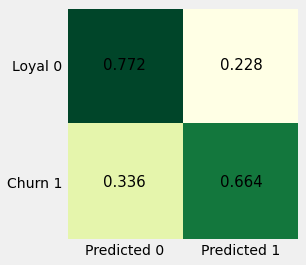

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.788341	0.763332	0.771882	0.664216	0.200741	0.308305	0.267900
Suggested image filename:
 LogisticRegression.ConfusMx.solver=saga.max_iter=7250.C=7.2.class_weight=11.png


In [218]:
# Scores
y_pred = model.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, model, prnt=True)

# Image name
fn="LogisticRegression.ConfusMx.solver="+str(model.solver)+".max_iter="+str(model.max_iter)+".C="+str(model.C)+".class_weight="+str(model.class_weight[1])
if standardize: fn=fn+'.std'
fn=fn+'.png'
print(f"Suggested image filename:\n",fn)

In [237]:
# Load the model
pkl_model = 'models/lr.solver_'+solver+'.maxiter_'+str(max_iter)+'.C_'+str(C_opt)+'.classweight_'+str(class_weight)+'.pkl'
pickled_model = pickle.load(open(pkl_model, 'rb'))
y_pred = pickled_model.predict(X_test)

Image saved: images/LogisticRegression.C_classweight_AUC.solver=saga.maxiter=7250.png


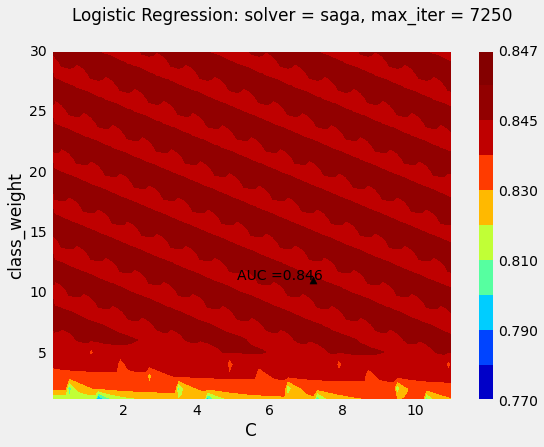

In [219]:
# Contour plot for a chosen combination of (criterion, max_features)
x_val = scores['C'].unique() # However, sometimes `C_val` are not all sampled. `unique` can give repeated close values
y_val = scores['class_weight'].unique() #class_weight_val

#https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
plt.figure(figsize=(8, 6))
plt.contourf(x_val, y_val, np.array(scores['roc_auc']).reshape(len(y_val), len(x_val)),
             levels=np.concatenate([np.arange(0.77,0.845,0.01), [0.845, 0.846, 0.847]]), cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.colorbar();
plt.xlabel('C')
plt.ylabel('class_weight')
plt.suptitle(f'Logistic Regression: solver = {solver}, max_iter = {max_iter}');
plt.scatter(C_opt,class_weight_opt, marker="^", s=50, c='k');
plt.text(C_opt-2.1,class_weight_opt, "AUC ="+str(round(roc_auc_opt,3)), c='k');

# Image file
fn = 'images/LogisticRegression.C_classweight_AUC.solver='+solver+'.maxiter='+str(max_iter)
if standardize:
    fn = fn+'.std'
fn = fn+'.png'
if not os.path.isfile(fn): # if image does not exist, create it
    plt.savefig(fn, dpi='figure', bbox_inches='tight') # save image 
    print("Image saved:",fn)
# if image exists, it is only plotted above

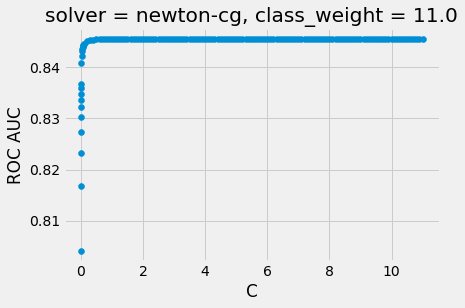

In [223]:
# AUC(C) for optimized class_weight
ds = scores.loc[scores['class_weight'] == class_weight_opt]
plt.ylabel("ROC AUC");
plt.xlabel("C");
plt.title(f"solver = {solver}, class_weight = {class_weight_opt}")
plt.scatter(x = ds['C'], y=ds['roc_auc']);

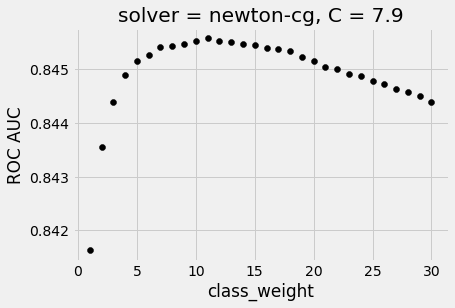

In [224]:
# AUC(class_weight) for optimized C
ds = scores.loc[scores['C'] == C_opt]
plt.ylabel("ROC AUC");
plt.xlabel("class_weight");
plt.title(f"solver = {solver}, C = {C_opt}")
plt.scatter(x = ds['class_weight'], y=ds['roc_auc'], color='black');
#plt.scatter(x = ds['class_weight'], y=ds['accuracy'], color='red');
#plt.scatter(x = ds['class_weight'], y=ds['precision'], color='blue');
#plt.scatter(x = ds['class_weight'], y=ds['mcc'], color='green');
#plt.legend(['AUC','accuracy','precision','MCC']);

In [220]:
def plot_auc_acc_prec_mcc(df, x, save=""):
    '''Plot ROC_AUC, accuracy, precision, MCC for dataframe `df`, x-axis is `x`. Optionally save image to png.'''
    fig, ax = plt.subplots(2,2,'col', figsize=(12,6))
    
    ax[0,0].set_ylabel("ROC AUC");
    ax[0,0].set_xlabel(x);
    ax[0,0].scatter(x = df[x], y=ds['roc_auc'], color='black')
    
    ax[0,1].set_ylabel("Accuracy");
    ax[0,1].set_xlabel(x);
    ax[0,1].scatter(x = df[x], y=ds['accuracy'], color='red');
    
    ax[1,0].set_ylabel("Precision");
    ax[1,0].set_xlabel(x);
    ax[1,0].scatter(x = df[x], y=ds['precision'], color='blue')
    
    ax[1,1].set_ylabel("MCC");
    ax[1,1].set_xlabel(x);
    ax[1,1].scatter(x = df[x], y=ds['mcc'], color='green');
    
    if len(save) > 0:
        plt.savefig(save, dpi='figure', bbox_inches='tight') # save image 
        print("Saved to:",save)
    plt.show()

solver = saga, optimized class_weight = 11.0
Saved to: images/LogisticRegression.C_AUC.solver=saga.class_weight=11.0.png


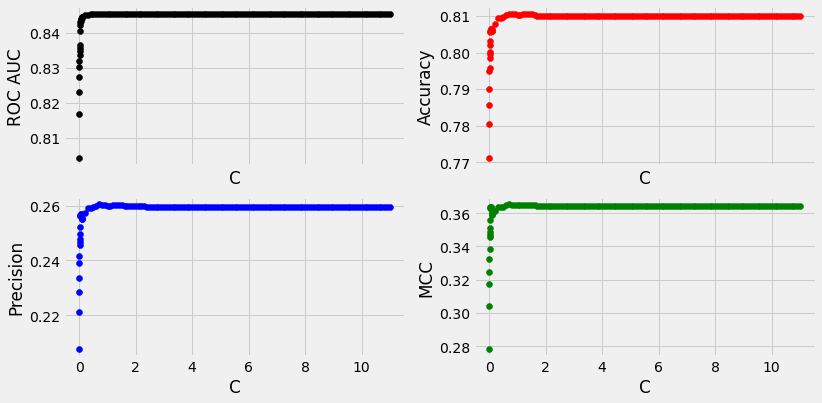

Image saved: images/LogisticRegression.C_AUC.solver=saga.class_weight=11.0.png


In [221]:
ds = scores.loc[scores['class_weight'] == class_weight_opt] # Image data
print(f"solver = {solver}, optimized class_weight = {class_weight_opt}")

# Image file
fn = "images/LogisticRegression.C_AUC.solver="+solver+'.class_weight='+str(class_weight_opt)
if standardize:
    fn = fn+'.std'
fn = fn+'.png'
if not os.path.isfile(fn): # if image does not exist, create it
    plot_auc_acc_prec_mcc(ds, "C", save=fn)
    print("Image saved:",fn)
else: # if image exists, only plot it
    plot_auc_acc_prec_mcc(ds, "C")

solver = saga, optimized C = 7.2


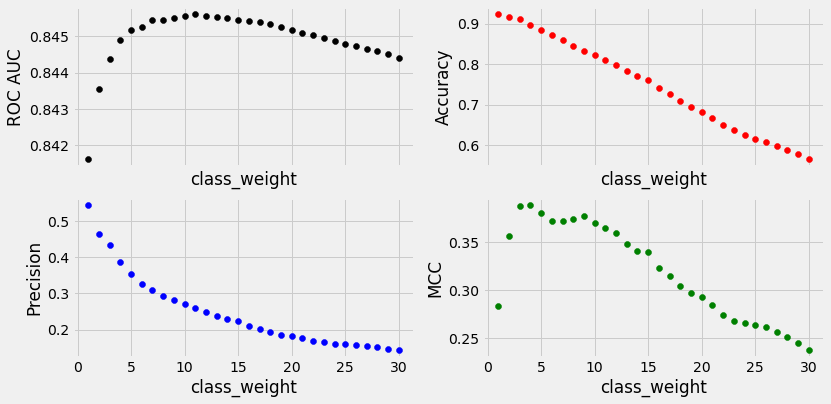

In [222]:
# Data: optimized C
ds = scores.loc[scores['C'] == C_opt]
print(f"solver = {solver}, optimized C = {C_opt}")

# Image file
fn = "images/LogisticRegression.classweight_AUC.solver="+solver+'.C='+str(C_opt)
if standardize:
    fn = fn+'.std'
fn = fn+'.png'
if not os.path.isfile(fn): # if image does not exist, create it
    plot_auc_acc_prec_mcc(ds, "class_weight", save=fn)
    print("Image saved:",fn)
else: # if image exists, only plot it
    plot_auc_acc_prec_mcc(ds, "class_weight")

#### ROC AUC for unscaled vs standardized data before and after simultaneous optimization of C and class_weight
|<b>solver|<b>data    |<b>max_iter|roc_auc | C |<b>roc_auc| increase % | C | class_weight |<b>roc_auc| increase % |accuracy | tnr | tpr | precision |f1|mcc|
|:--------|:------:|:--:|:---------:|:--------:|:---:|:---:|:---:|:---------:|::|:-:|::|:-:|:-:|:-:|:-:|:-:|
|newton-cg|unscaled|72   |0.841303|8.7|<b>0.841835|0.062879|9.2|11|<b>0.845578|0.809848|0.814799|<b>0.752451|0.259510|<b>0.385921|<b>0.364309|
|         |standardized|11|0.841376|9.1|<b>0.841835|0.054553|7.9|11|<b>0.845580|0.444862|0.809848|0.814799|<b>0.752451|0.259510|<b>0.385921|<b>0.364309|
|liblinear|unscaled|41|0.841067|6.0|<b>0.842613|0.183814|9.5|11|<b>0.845579|0.352000|0.809848|0.814799|<b>0.752451|0.259510|<b>0.385921|<b>0.364309|
||<b>standardized|7 |0.841436|9.9|<b>0.841824|0.046112|9.5|11|<b>0.845579|0.446055|0.809848|0.814799|<b>0.752451|0.259510|<b>0.385921|<b>0.364309|
|<b>lbfgs |unscaled|1450|0.842241|5.9|<b>0.842953|0.084536|2.6|11|<b><font color='red'>0.846531</font>|0.424460|0.802452|0.806342|<b>0.757353|0.252245|<b>0.378445|<b>0.357670|
||standardized|20 |0.841738|9.7|<b>0.842100|0.043006|0.3|15|<b>0.846377|0.507897|0.749319|0.743340|<b>0.818627|0.215762|<b>0.341513|<b>0.331161|
|sag      |unscaled|6200  |0.680344|9.5|<b>0.680438|0.680345|||||0.920592|1.0|0.0|NaN|0.0|NaN|
||<b>standardized|790 |0.841310|9.3|<b>0.841631|23.7066|9.9|11|<b>0.845583|0.469564|0.809848|0.814799|<b>0.752451|0.259510|<b>0.385921|<b>0.364309|
|saga     |unscaled|7250  |0.637991|8.9|<b>0.638027|0.005643|7.2|11|0.788341|23.5591|0.763332|0.771882|<b>0.664216|<b>0.200741|<b>0.308305|<b>0.267900|
||<b>standardized|1200 |0.841249|10.0|<b>0.841526|0.032927|7.2|11|0.845602|0.484358|0.809848|0.814799|<b>0.752451|0.259510|<b>0.385921|<b>0.364309|

In [224]:
0.788341/0.638027-1

0.23559191068716512

In [223]:
model

LogisticRegression(C=7.2, class_weight={0: 1, 1: 11}, max_iter=7250,
                   random_state=0, solver='saga')

In [ ]:
round((0.845579/0.842613-1)*100,6)

Involving `class_weight` to the optimization process compared to only optimizing `C` leads to a considerable decrease in accuracy (e.g., 18.84% for the default `lbfgs` solver) and even a larger decrease in TNR (24.76% for `lbfgs`), but radically improves TPR (by 370.42% for `lbfgs`), and thus is more preferable in churn prediction.

|Input   |solver   |max_iter|C|class_weight|AUC|Accur|TNR|TPR|Precis|F1|MCC|
|:-------|:--------|:---:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Unscaled|lbfgs    |10000|9.9|18|<b>0.847024|0.716427|0.706131|0.835784|0.196996|0.318841|0.309997|
||liblinear|10000|7.4|10|0.845600|0.821721|0.829387|0.732843|0.270344|0.394980|0.369860|
||newton-cg|10000|8.1|11|0.845577|0.809848|0.814799|0.752451|0.259510|0.385921|0.364309|

#### Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

https://scikit-learn.org/stable/modules/cross_validation.html

In [277]:
print("Example of cross-validation:")
#lr_cv = LogisticRegression(solver='lbfgs', max_iter=10000, C = 0.7, random_state=0)
lr_cv = LogisticRegression(solver='lbfgs', max_iter=20, C=70, class_weight='balanced', random_state=0)
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
print(f"min = {scores.min()}, mean = {scores.mean()}, max = {scores.max()}, std = {np.std(scores)}")

Example of cross-validation:
Cross-Validation Accuracy Scores [0.54407472 0.48686515 0.44016346 0.49970811 0.73714953 0.85981308
 0.66880841 0.4953271  0.64252336 0.11098131]
min = 0.11098130841121495, mean = 0.5485414245653086, max = 0.8598130841121495, std = 0.19183451920078337


In [279]:
print("Example of cross-validation:")
#lr_cv = LogisticRegression(solver='lbfgs', max_iter=10000, C = 0.7, random_state=0)
lr_cv = LogisticRegression(solver='lbfgs', max_iter=20, C=70, class_weight='balanced', random_state=0)
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
print(f"min = {scores.min()}, mean = {scores.mean()}, max = {scores.max()}, std = {np.std(scores)}")

Example of cross-validation:
Cross-Validation Accuracy Scores [0.54407472 0.48686515 0.44016346 0.49970811 0.73714953 0.85981308
 0.66880841 0.4953271  0.64252336 0.11098131]
min = 0.11098130841121495, mean = 0.5485414245653086, max = 0.8598130841121495, std = 0.19183451920078337


In [281]:
?LogisticRegression

In [282]:
print("Example of cross-validation:")
#lr_cv = LogisticRegression(solver='lbfgs', max_iter=10000, C = 0.7, random_state=0)
#lr_cv = LogisticRegression(solver='lbfgs', max_iter=10000, C=9.9, class_weight=18, random_state=0)
#lr_cv = LogisticRegression(solver='liblinear', max_iter=20, C=7.4, class_weight=10, random_state=0) ###? Doesn't work!
lr_cv = LogisticRegression(solver='newton-cg', max_iter=10000, C=8.1, class_weight={0:11, 1:11}, random_state=0)
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
scores = cross_val_score(lr_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
print(f"min = {scores.min()}, mean = {scores.mean()}, max = {scores.max()}, std = {np.std(scores)}")

Example of cross-validation:
Cross-Validation Accuracy Scores [0.92352598 0.92586106 0.92644483 0.92644483 0.92406542 0.93457944
 0.92348131 0.9036215  0.90478972 0.86331776]
min = 0.8633177570093458, mean = 0.9156131847717563, max = 0.9345794392523364, std = 0.01972588850099185


|Input   |solver   |max_iter|C|class_weight|AUC_test|AUC_min|AUC_mean|AUC_max|AUC_std|
|:-------|:--------|:---:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Unscaled|lbfgs    |10000|9.9|18|<b>0.847024|0.863318|<b><font color="red">0.916431</font>|0.935748|0.019540|
||liblinear|10000|7.4|10|0.845600||||||||
||newton-cg|10000|8.1|11|0.845577|0.863318|0.915730|0.934579|0.019719|

In [286]:
lr = LogisticRegression(solver='newton-cg', max_iter=10000, random_state=0, C=8.1, class_weight={0:11, 1:11})
lr.fit(X_train,y_train)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test,y_test, lr, prnt=True);

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.841901	0.923122	0.986469	0.188725	0.546099	0.280510	0.289946


After 10-fold cross-validation of hyperparameters optimized for 70/30% train-test split, the ranking of solvers remains same. Cross-validation ROC AUC is considerably higher than for the 30% test dataset.

#### Grid optimization of C

In [257]:
def optCV_C_rocauc(C_range, solver='lbfgs', class_weight=None):
    #solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression with 10-fold Cross-Validation.'''
    global Rocauc, rocauc # Collected and current AUC values
    rocauc = pd.DataFrame({'C':[],'ROC AUC':[]})
    rocauc_opt = 0
    for C in C_range: #np.arange(Cmin, Cmax+0.1*Cstep, Cstep):
        lr_cv = LogisticRegression(C=C, solver=solver, max_iter=10000, class_weight=class_weight, random_state=0).fit(X_train, y_train)
        #pred = lr_cv.predict(X_test) # predicted values, needed if accuracy
        metric = np.mean(cross_val_score(lr_cv, X_test, y_test, scoring='roc_auc', cv=10)) # accuracies of cv cross-validations
        rocauc = rocauc.append({'C':C,'ROC AUC':metric}, ignore_index=True)
        if rocauc_opt < metric:
            rocauc_opt = metric
            C_opt = C
    print('Current optimal C =',C_opt)
    print('Current highest ROC AUC =',rocauc_opt)
    # Save ROC AUC scores
    try: Rocauc
    except NameError: # if variable does not exist, initialize it
        Rocauc=rocauc
    else: # if variable exists, append to it
        Rocauc=pd.concat([Rocauc, rocauc], axis=0)
    Rocauc.sort_values(['C'], inplace=True)
    # Plot all ROC AUC scores
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(Rocauc['C'],Rocauc['ROC AUC']); # for current AUC values, use 'rocauc'
    plt.xlabel('C');
    plt.ylabel('ROC AUC');
    #display(rocauc)

Current optimal C = 2.5000000000000004
Current highest ROC AUC = 0.8389892615892333


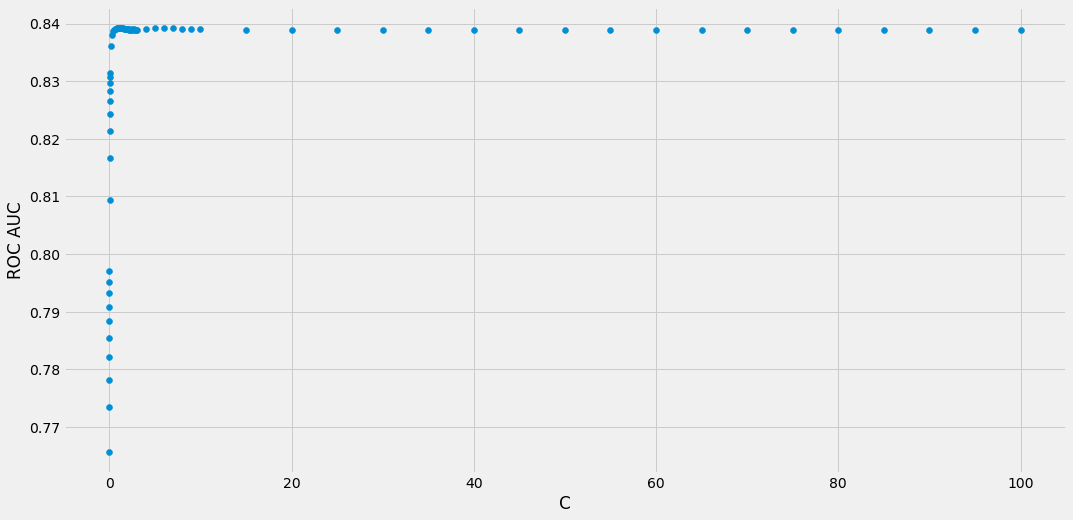

In [273]:
for solver in ['saga']:
#for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    #del Rocauc # if changing a hyperparameter
    #C_range = np.concatenate([np.arange(0.001, 0.01+0.0001, 0.001), np.arange(0.02, 0.1+0.0001, 0.01), np.arange(0.2, 1+0.0001, 0.1),
    #            np.arange(2, 10+0.0001, 1), np.arange(15, 100+0.0001, 5)])
    C_range = np.arange(2.1, 3, 0.1)
    optCV_C_rocauc(C_range, solver=solver, class_weight=None) # Grid optimization
    Rocauc.to_csv("data/LR_C."+solver+".cv.csv", index=False)
Rocauc.loc[Rocauc['ROC AUC'] == np.max(Rocauc['ROC AUC'])]

#### Grid search with cross-validation

In [292]:
# GridSearchCV for train set
def grid_search(X_train, X_test, y_train, model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #scoring_fit='ne_mean_squared_error'
    '''Hyperparameter search over `param_grid` with 10-fold CV.'''
    gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring_fit, cv=cv,  n_jobs=-1, verbose=1)
    fitted_model = gs.fit(X_train, y_train)
    scores = pd.DataFrame(fitted_model.cv_results_)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    #display(scores)
    return fitted_model, pred, scores;

In [361]:
param_grid = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter':[10000], 'C':np.arange(1.8, 2.001, 0.1),
              'class_weight':['balanced']} #'class_weight':[{0:1, 1:1}, 'balanced']
model = LogisticRegression(random_state=0)
lr_cv_opt, y_pred, scores = grid_search(X_train, X_test, y_train, model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False)

# Display optimal result
scores_opt = scores.loc[scores['rank_test_score']==1]
display(scores_opt) # highest-score record
print("mean ROC AUC", scores_opt['mean_test_score'].tolist()[0])

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
7       0.148403      0.013177         0.005984        0.000631     1.9   

  param_class_weight param_max_iter param_solver  \
7           balanced          10000    liblinear   

                                              params  split0_test_score  ...  \
7  {'C': 1.9000000000000001, 'class_weight': 'bal...           0.858138  ...   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
7           0.841586           0.820471           0.855616           0.892861   

   split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
7           0.848958           0.832962           0.849122         0.850615   

   std_test_score  rank_test_score  
7        0.018026                1  

[1 rows x 22 columns]

mean_test_score= 0.8506154551503643


The set of hyperparameters, optimized above for the test set, is: solver='liblinear', max_iter=10000, C=1.9, class_weight='balanced'. The ROC AUC characteristics are: mean_test_score=0.850615, std_test_score=0.018026.
This hyperparameter set has a small mean accuracy of 0.807509 for the test set and 0.807356 for the train set, but considerably smaller value 0.778483 for the entire dataset.

In [383]:
print("10-fold cross-validation of the model with optimized ROC AUC:")
lr_cv = LogisticRegression(solver='liblinear', max_iter=10000, C = 1.9, class_weight='balanced', random_state=0)
scores = cross_val_score(lr_cv, X_test, y_test, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

10-fold cross-validation of the model with optimized ROC AUC:
Cross-Validation Accuracy Scores [0.82490272 0.807393   0.81322957 0.83657588 0.79766537 0.81712062
 0.78793774 0.79182879 0.8128655  0.78557505]


(0.7855750487329435, 0.807509424230702, 0.8365758754863813)

Overall, logistic regression model is weak for the selected 53 features, and may require more features selected. This can be done by using less stringent Initial Value and Variance Inflation Factor criteria, as well as engineering more advanced features.

#### ROC AUC: Optimization of classification threshold
Area Under the Curve (AUC) of Receiver Characteristic Operator (ROC) helps us visualize how well our machine learning classifier is performing and choose the optimal classification threshold probability.

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [494]:
print(lr_cv)

LogisticRegression(C=1.9, class_weight='balanced', max_iter=10000,
                   random_state=0, solver='liblinear')


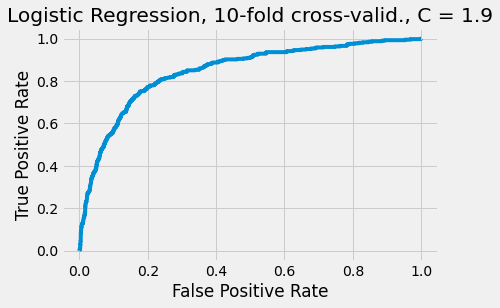

AUC: 0.845


In [231]:
lr_cv.fit(X_train,y_train)
y_pred_prob = lr_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title(f'Logistic Regression, 10-fold cross-valid., C = 1.9') #C = {C_opt}
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show();
print('AUC: %.3f' % roc_auc_score(y_test, y_pred_prob))

In [232]:
print("Performance for a given decision threshold")
THRESHOLD = 0.52
y_pred = np.where(y_pred_prob > THRESHOLD, 1, 0)
cm = confusion_matrix(y_test, y_pred)
tn = cm[0,0] # true negative count
fp = cm[0,1] # false positive count
fn = cm[1,0] # false negative count
tp = cm[1,1] # true positive count
tnr = tn/(tn + fp) # tnr = 1-fpr
fpr = fp/(tn + fp) # fpr = 1-tnr
fnr = fn/(fn + tp) # fnr = 1-tpr
tpr = tp/(tp + fn) # tpr = 1-fnr
precision = tp/(tp+fp) # TP/PP = TP/(TP+FP) = precision_score(y_test, y_pred)
f1 = 2*tp/(2*tp+fp+fn)
MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
pd.DataFrame(data=[roc_auc_score(y_test, y_pred_prob), accuracy_score(y_test, y_pred),
                   tnr, tpr, precision, f1, MCC], 
             index=["roc_auc", "accuracy", "TNR", "TPR", "precision", "F1", "MCC"], columns=['Score'])

Performance for a given decision threshold


Score
roc_auc    0.845486
accuracy   0.813157
TNR        0.818393
TPR        0.752451
precision  0.263293
F1         0.390089
MCC        0.368489

One of the ways to locate the optimal decision threshold with the optimal balance between false positive and true positive rates is using the Geometric Mean (`roc_auc_score`). Let's use the squared geometric mean, which corresponds to the area to the bottom and right from the point on the ROC curve.

ROC curve built manually, array of TPR and FPR rates:

Best Threshold = 0.5200, G-Mean_sq = 0.6158
FPR = 0.1816, TPR = 0.7525


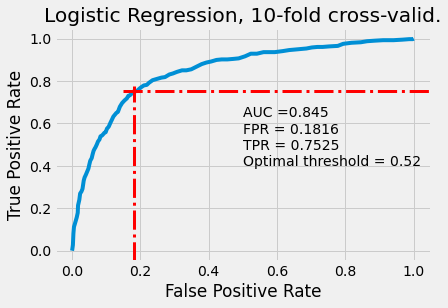

AUC: 0.845486


In [264]:
y_pred_probs = lr_cv.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
FPR = np.empty(int(1+1/prob_step))
TPR = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(y_pred_probs.shape[0]): # each test case
        if y_pred_probs[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    FPR[j] = fp/(tn + fp) # specificity
    TPR[j] = tp/(tp + fn) # sensitivity
    j = j+1
#print("FPR =",FPR)
#print("TPR =",TPR)
# ROC curve
plt.plot(FPR, TPR, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-valid.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()

# calculate the squared g-mean for each threshold
gmeans_sq = TPR * (1-FPR)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold = %.4f, G-Mean_sq = %.4f' % (thresholds[ix], gmeans_sq[ix]))
print('FPR = %.4f, TPR = %.4f' % (FPR[ix], TPR[ix]))
plt.axvline(x=FPR[ix], ymin=0, ymax=TPR[ix], color='red', linestyle='dashdot', linewidth=3)
plt.axhline(y=TPR[ix], xmin=FPR[ix], xmax=1, color='red', linestyle='dashdot', linewidth=3)
txt_auc = 'AUC ='+str(round(roc_auc_score(y_test, y_pred_probs[:,1]),3))+'\nFPR = '+str(round(FPR[ix],4))+\
    '\nTPR = '+str(round(TPR[ix],4))+'\nOptimal threshold = '+str(thresholds[ix])
plt.text(0.5, 0.4, txt_auc)
plt.show()
print('AUC: %.6f' % roc_auc_score(y_test, y_pred_probs[:,1]))

[[TN, FP], [FN, TP]] =
 [[3795  935]
 [  96  312]]


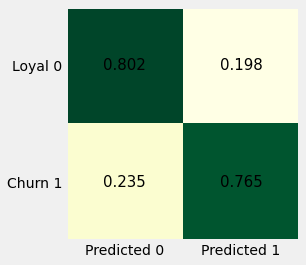

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.845486	0.799338	0.802326	0.764706	0.250200	0.377039	0.357605
Suggested image filename:
 LogisticRegression.ConfusMx.solver=liblinear.max_iter=10000.C=1.9.class_weight=balanced.cv10.png


In [269]:
# Optimized Logistic Regression classifier: Unscaled input
if standardize:
    lr_opt = LogisticRegression(solver='lbfgs', max_iter=20, C=70, class_weight='balanced', random_state=0)
else:
    lr_opt = LogisticRegression(C=1.9, class_weight='balanced', max_iter=10000, solver='liblinear', random_state=0)
lr_opt.fit(X_train, y_train)
# Create and train Logistic Regression model using 70% training set
#lr = LogisticRegression(solver='liblinear', max_iter=10000, C=1.9, class_weight='balanced', random_state=0).fit(X_train, y_train);
# class_weight={0:1, 1:1}

# Quality metrics
y_pred = lr_opt.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, lr_opt, prnt=True)
#print(classification_report(y_test, y_pred))

# Image name
fn="LogisticRegression.ConfusMx.solver="+str(lr_opt.solver)+".max_iter="+str(lr_opt.max_iter)+".C="+str(lr_opt.C)+".class_weight="+"balanced"+".cv10" #str(lr_opt.class_weight[1])
if standardize: fn=fn+'.std'
fn=fn+'.png'
print(f"Suggested image filename:\n",fn)

### 4.4 Decision Tree
For ease of interpretation, it is better to not rescale the continuos features.

In [46]:
# Import df, extract X, y, train-test split
standardize = True # if to standardize continuous features (float, int)
# Import data
if standardize:
    csv = "data/df_20161022_f.std.csv"
else:
    csv = "data/df_20161022_f.csv" #csv = "./data/df_20161022_onehot.csv, data/df_20161022_1.gender_onehot.featuresmt.csv"
df = pd.read_csv(csv)

# Optionally drop some columns
drop_cols = False
if drop_cols:
    df = df.drop(['registration_Month','registration_winter','registration_spring','registration_summer',
              'registration_autumn','registration_DayofMonth','registration_beginOfMonth','registration_middleOfMonth',
             'registration_endOfMonth','registration_DayOfWeek','registration_holiday','registration_weekday',
             'firsttransaction_Month','firsttransaction_winter','firsttransaction_spring','firsttransaction_summer',
             'firsttransaction_autumn','firsttransaction_DayofMonth','firsttransaction_beginOfMonth',
             'firsttransaction_middleOfMonth','firsttransaction_endOfMonth','firsttransaction_DayOfWeek','firsttransaction_holiday',
             'firsttransaction_weekday','reg_to_trans_days1','transaction_Month1','transaction_winter1','transaction_spring1',
             'transaction_summer1','transaction_autumn1','transaction_DayofMonth1','transaction_beginOfMonth1','transaction_middleOfMonth1',
             'transaction_endOfMonth1','transaction_DayOfWeek1','transaction_holiday1','transaction_weekday1']
             ,axis=1)
pd.set_option('display.max_seq_items', None)
#print(df.columns)

# Explanatory and response variables
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
print("No. of features:",X.shape[1])
print("No. of records:",X.shape[0])
df.head()

# Train-Test split: Taking 70% for training set and 30% for test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

No. of features: 53
No. of records: 17124
Train samples: 11986
Test samples: 5138


#### Entropy model - no max_depth
Let's remind ourselves of what's going on with a decision tree implementing an entropy model in scikitlearn.

Ross Quinlan's **ID3 Algorithm** was one of the first, and one of the most basic, to use entropy as a metric.

**Entropy** is a measure of how uncertain we are about which category the data points fall into at a given point in the tree. The **Information gain** of a specific feature with a threshold (such as 'spent_last_month <= 138.0') is the difference in entropy that exists before and after splitting on that feature; i.e., the information we gain about the categories of the data-points by splitting on that feature and that threshold. 

Naturally, we want to minimize entropy and maximize information gain. Quinlan's ID3 algorithm is designed to output a tree such that the features at each node, starting from the root, and going all the way down to the leaves, have maximial information gain. We want a tree whose leaves have elements that are *homogeneous*, that is, all of the same category.

[[TN, FP], [FN, TP]] =
 [[4494  236]
 [ 247  161]]


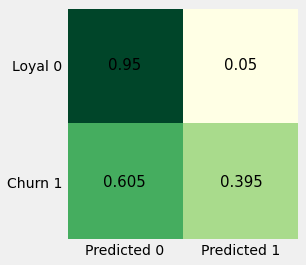

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.688684	0.905995	0.950106	0.394608	0.405542	0.400000	0.349051
Suggested image filename:
 DecisionTree.ConfusMx.criterion=entropy.std.png


In [47]:
# tree.DecisionTreeClassifier
dt_entropy = tree.DecisionTreeClassifier(criterion = "entropy", random_state=0)
dt_entropy.fit(X_train, y_train) # train model
y_pred = dt_entropy.predict(X_test) # predict 0/1 labels
y_pred = pd.Series(y_pred) # convert predictions to pandas series
# Check out entropy model
#print(X_test, y_pred)

# Confusion matrix
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, dt_entropy, prnt=True)
#print(classification_report(y_test, y_pred))

# Image name
fn="DecisionTree.ConfusMx.criterion="+str(dt_entropy.criterion)
if standardize: fn=fn+'.std'
fn=fn+'.png'
print(f"Suggested image filename:\n",fn)

In [ ]:
# Evaluation metrics 
print("Model Entropy - no max depth")
y_pred_prob = dt_entropy.predict_proba(X_test)[:,1]
print('ROC AUC:' , metrics.roc_auc_score(y_test,y_pred_prob))
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision for "No"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall for "Yes" TPR' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall for "No" TNR' , metrics.recall_score(y_test,y_pred, pos_label = 0))

In [37]:
# Entropy calculation for a node
def entropy(n1,n2):
    n = n1+n2 # total no.
    p1=n1/n; p2=n2/n; # probabilities
    return -p1*math.log2(p1)-p2*math.log2(p2)

# Inspect a node in the tree
n1 = 11811
n2 = 1032
print("Entropy =",entropy(n1,n2)) # the smaller - the better, gini=0 - fully separated labels

Entropy = 0.4034290224551148


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

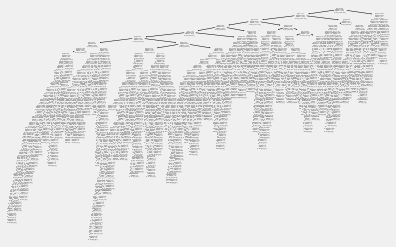

In [48]:
# Visualize the tree
tree.plot_tree(dt_entropy)
# for class_names use dt_entropy.classes_
dot_data = tree.export_graphviz(dt_entropy, out_file=None, class_names=[str(dt_entropy.classes_[0]),str(dt_entropy.classes_[1])], filled=True)
graph = graphviz.Source(dot_data)
graph.render("Customer_Churn.Decision_Tree_entropy")

#### Gini impurity model - no max_depth

Gini impurity, like entropy, is a measure of how well a given feature (and threshold) splits the data into categories.

Their equations are similar, but Gini impurity doesn't require logorathmic functions, which can be computationally expensive. 

[[TN, FP], [FN, TP]] =
 [[4487  243]
 [ 241  167]]


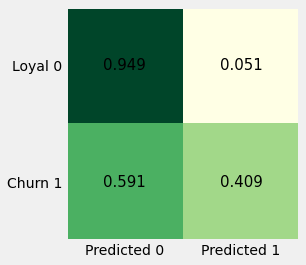

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.696687	0.905800	0.948626	0.409314	0.407317	0.408313	0.357141
Suggested image filename:
 DecisionTree.ConfusMx.criterion=gini.std.png


In [49]:
dt_gini = tree.DecisionTreeClassifier(criterion='gini', random_state=0) 
dt_gini.fit(X_train, y_train) # train model
y_pred = dt_gini.predict(X_test) # predict
y_pred = pd.Series(y_pred) # Turn y_pred into a series, as before
# Check out Gini model
#print(X_test, y_pred)

# Confusion matrix
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, dt_gini, prnt=True)
#print(classification_report(y_test, y_pred))

# Image name
fn="DecisionTree.ConfusMx.criterion="+str(dt_gini.criterion)
if standardize: fn=fn+'.std'
fn=fn+'.png'
print(f"Suggested image filename:\n",fn)

In [ ]:
tree.plot_tree(dt_gini)
# for class_names use dt_gini.classes_
dot_data = tree.export_graphviz(dt_gini, out_file=None, class_names=[str(dt_gini.classes_[0]),str(dt_gini.classes_[1])], filled=True)
graph = graphviz.Source(dot_data)
graph.render("Customer_Churn.Decision_Tree_gini")

In [ ]:
# Gini index calculation for a node
#The Gini Index or Gini Impurity is calculated by subtracting the sum of the squared probabilities of each class from one
def gini(n1,n2):
    n = n1+n2 # total no.
    p1=n1/n; p2=n2/n; # probabilities
    return 1-p1**2-p2**2

# Inspect a node in the tree
n1 = 11040
n2 = 946
print("Gini =",gini(n1,n2)) # the smaller - the better, gini=0 - fully separated labels

In [ ]:
# Evaluation metrics
print("Model Gini impurity - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision for "No"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall for "Yes" TPR' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall for "No" TNR' , metrics.recall_score(y_test,y_pred, pos_label = 0))

In [138]:
if standardize: dt_opt = tree.DecisionTreeClassifier(criterion = "gini")
else: dt_opt = tree.DecisionTreeClassifier(criterion = "gini")
dt_opt.fit(X_train, y_train)

|Data        |Criterion|ROC AUC|Accuracy|TNR|TPR|Precision|F1|MCC|
|:-----------|:--------|:-----:|:------:|:-:|:---------------:|:---------:|:---------:|:------:|
|Raw         |entropy  |0.690759|<b>0.909692|<b>0.954123|0.394608|<b>0.425926|<b>0.409669|<b>0.361161|
|            |gini     |0.692177|0.903659|0.946934|0.401961|0.395181|0.398542|0.346197|	
|Standardized|entropy  |0.688684|0.905995|0.950106|0.394608|0.405542|0.400000|0.349051|
|            |gini     |<b>0.696687|0.905800|0.948626|<b>0.409314|0.407317|0.408313|0.357141|

Comparison of raw and standardized input data shows that ROC AUC is 0.3004% lower for standardized input for `entropy` criterion and 0.6516% higher for `gini`. Accuracy has the same trend: it is 0.4064% lower for standardized input for `entropy` criterion and 0.2369% higher for `gini`.

Comparison of decision criteria shows that Gini index-based decisions give slightly higher ROC AUC (0.2053% for raw input and 1.162% for standardized one) but slightly lower accuracy (0.6632% for raw input and 0.0215% for standardized one).

Overall, all quality metrics are close for raw vs standardized inputs, as well as for the two decision criteria. Standardization leads to a shuffling of features in the dataframe. Apart from that, the decision trees are very similar in the cases of different scalings and branching criteria. We recommend using <b>unscaled input<b> data for better interpretability of the tree with <b>`gini`</b> criterion.

### 4.4 Random Forest classifier
#### Default hyperparameters

In [271]:
# Instantiate model with default hyperparameters, train using train set
rf = RandomForestClassifier(random_state=0).fit(X_train, y_train) 
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, rf, prnt=True)

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.853444	0.933632	0.990486	0.274510	0.713376	0.396460	0.416286


In [396]:
# Details on calculation of ROC AUC
y_score = rf.predict_proba(X_test)[:,1]
roc_auc_rf = roc_auc_score(y_test, y_score)
print("ROC AUC =",roc_auc_rf)

ROC AUC = 0.863886125274634


#### Feature Importance

Feature importance: [0.00070676 0.00468542 0.00641282 0.00173657 0.01835712 0.00274865
 0.00435382 0.01300814 0.04858503 0.00489005 0.00445516 0.00690149
 0.00866014 0.01833517 0.00718697 0.0058324  0.01523515 0.00680043
 0.01958525 0.01529322 0.01113623 0.01273653 0.00361696 0.00868089
 0.00407467 0.02063484 0.00866482 0.00237234 0.004064   0.0061803
 0.0111489  0.06338678 0.00684346 0.01249139 0.00423224 0.02631041
 0.0148356  0.00394177 0.01049458 0.01103116 0.01385322 0.02091871
 0.01276555 0.01001561 0.01921662 0.06691818 0.05194645 0.07834235
 0.04329525 0.03753057 0.03667902 0.06974952 0.07812133]


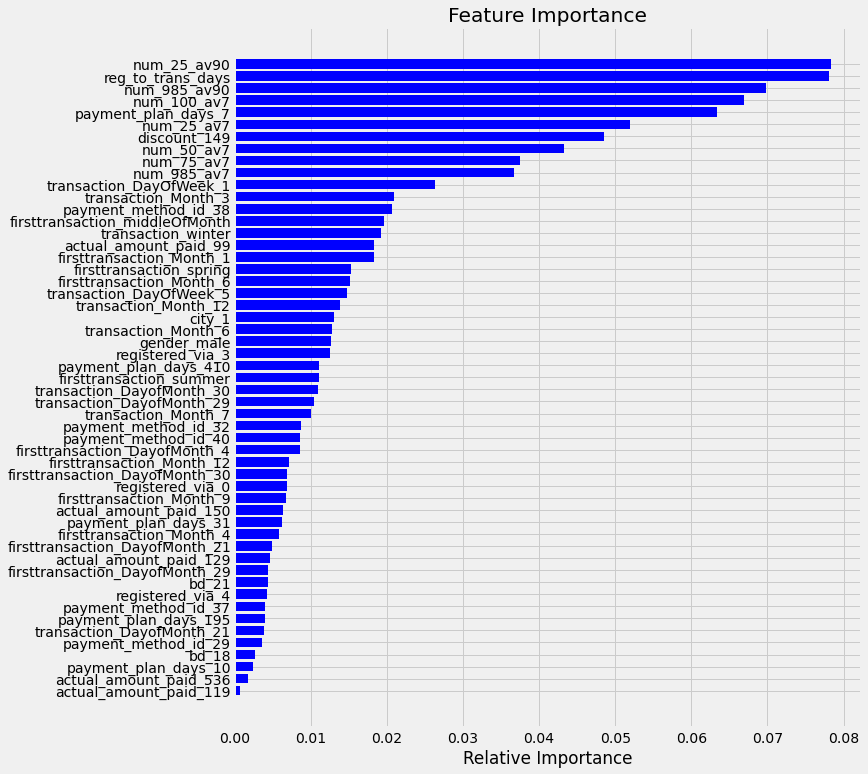

In [397]:
importances = rf.feature_importances_
print("Feature importance:",importances)
indices = np.argsort(importances)
features = X_train.columns
fig, ax = plt.subplots(1, figsize=(10,12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Custom hyperparameters

In [103]:
rf = RandomForestClassifier(n_estimators = 20, random_state = 42, max_depth=50, class_weight=dict({1:11, 0:1}), verbose=1)
rf.fit(X_train, y_train) 
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, rf, prnt=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AUC	Accur	TNR	TPR	Precis	F1	MCC
0.814215	0.917672	0.972516	0.281863	0.469388	0.352221	0.322753


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


#### Optimize hyperparameters one-by-one

#### Greed sweeping of hyperparameters

If using the entire dataset for both training and testing (`.fit(X,y)`, `scores_all(X, y, rf_nosplit)`), the results are as follows.

Currently maximal ROC AUC: 0.9972922710042533
Currently optimal hyperparameters:
      criterion max_features max_depth n_estimators   roc_auc  accuracy  \
16895   entropy         log2        38           46  0.997292  0.989255   

            tnr       tpr  precision        f1       mcc  
16895  0.998985  0.875923   0.986689  0.928013  0.924138 

In [316]:
# Initialize score dataframe
if standardize:
    scores_csv = 'data/RandomForest.hp_sweep_scores.std.3.csv' # VERNI!
else:
    scores_csv = 'data/RandomForest.hp_sweep_scores.3.csv' # VERNI!
if os.path.exists(scores_csv): scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators','class_weight', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])


In [ ]:
?RandomForestClassifier

In [340]:
scores.sort_values(['criterion','max_features','max_depth','n_estimators','class_weight'], inplace=True)
scores.drop_duplicates(inplace=True, ignore_index=True)
scores.to_csv(scores_csv, index=False)
# Initialize score dataframe
if standardize:
    scores_csv = 'data/RandomForest.hp_sweep_scores.std.3.csv' # VERNI!
else:
    scores_csv = 'data/RandomForest.hp_sweep_scores.3.csv' # VERNI!
if os.path.exists(scores_csv): scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators','class_weight', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
#display(scores.head())

In [352]:
# Initialize score dataframe
if standardize:
    scores_csv = 'data/RandomForest.hp_sweep_scores.std.3.csv' # VERNI!
else:
    scores_csv = 'data/RandomForest.hp_sweep_scores.3.csv' # VERNI!
if os.path.exists(scores_csv): scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators','class_weight', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
#display(scores.head())
#display(scores.tail())

# Grid sweeping of hyperparameters using GridSearchCV
#for criterion in ['gini', 'entropy']:
for criterion in ['entropy']:
    #for max_features in ['auto', 'sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for max_features in [0.4]:
        for max_depth in np.arange(1,20+1,1): #np.arange(11,20+1,1):
            for n_estimators in np.arange(58,59+1,1): #np.arange(1,100+1,1): #np.arange(31,100+1,1):
                for class_weight in np.arange(1,2,1):
                    # Create and train the Logistic Regression model
                    rf = RandomForestClassifier(criterion=criterion, max_features=max_features,
                        max_depth=max_depth, n_estimators=n_estimators, class_weight={0:1, 1:class_weight}, random_state=0).fit(X_train,y_train) # Training on train set
                    roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, rf); # Assessing on test set
                    scores = scores.append({'criterion':criterion,'max_features':max_features,'max_depth':max_depth,'n_estimators':n_estimators,'class_weight':class_weight,
                        'roc_auc':roc_auc,'accuracy':accuracy,'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
                scores.to_csv(scores_csv) # Save scores
scores.sort_values(['criterion','max_features','max_depth','n_estimators','class_weight'], inplace=True)
scores.drop_duplicates(inplace=True, ignore_index=True)
scores.to_csv(scores_csv, index=False)

# Optimal score
auc_max = np.max(scores['roc_auc'])
print("Currently maximal ROC AUC:",auc_max)
print("Currently optimal hyperparameters:")
display( scores.loc[scores['roc_auc']==auc_max] ) #scores.iloc[np.argmax(scores['roc_auc'])]

Currently maximal ROC AUC: 0.8792195207892882
Currently optimal hyperparameters:


criterion  max_features  max_depth  n_estimators  class_weight  roc_auc  \
477   entropy           0.4         15            73             1  0.87922   

     accuracy       tnr       tpr  precision     f1       mcc  
477   0.93733  0.993023  0.291667   0.782895  0.425  0.454292

|Optimization|criterion|max_features|max_depth|n_estimators|ROC AUC |Accuracy|TNR     |TPR     |Precision|F1      |MCC     |
|:-----------|:-------:|:----------:|:-------:|:----------:|:------:|:------:|:------:|:------:|:-------:|:------:|:------:|
|Default     |gini     |auto        |None     |100         |0.853444|0.933632|0.990486|0.274510|0.713376 |0.396460|0.416286|
|criterion   |entropy  |auto        |None     |100         |0.865571|0.933437|0.990698|0.269608|0.714286 |0.391459|0.412757|
|max_features|entropy  |0.4         |None     |100         |0.866910|0.934216|0.989641|0.291667|0.708333 |0.413194|0.427670|
|max_depth   |entropy  |0.4         |15       |100         |0.878670|0.937524|0.992812|0.296569|0.780645 |0.429840|0.457424|
|n_estimators|entropy  |0.4         |15       | 73         |<b><font color='red'>0.879220</font>|0.937330|0.993023|0.291667|0.782895 |0.425000|0.454292|

In [332]:
ds.shape

(460, 12)

In [341]:
# Optimal ROC AUC
criterion = 'entropy'
max_features = 0.4
ds = scores.loc[(scores['criterion']==criterion) & (scores['max_features']==max_features)]
print("Optimal parameters, standardized, 70-30% train-test split:")
idx_opt = np.argmax(scores['roc_auc'])
scores_opt = scores.iloc[idx_opt]
max_depth_opt = scores_opt['max_depth']
n_estimators_opt = scores_opt['n_estimators']
display(scores_opt)

Optimal parameters, standardized, 70-30% train-test split:


criterion        entropy
max_features         0.4
max_depth             15
n_estimators          73
class_weight           1
roc_auc          0.87922
accuracy         0.93733
tnr             0.993023
tpr             0.291667
precision       0.782895
f1                 0.425
mcc             0.454292
Name: 327, dtype: object

Image saved: images/RandomForest.maxdepth_nestimators_AUC.criterion=entropy.max_features=0.4.png


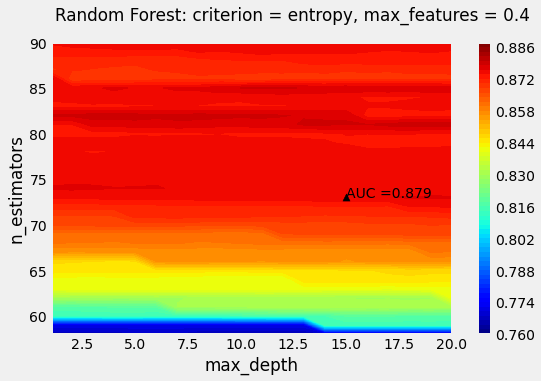

In [357]:
# Contour plot for a chosen combination of (criterion, max_features)
criterion = scores_opt['criterion']
max_features=scores_opt['max_features']
ds = scores.loc[(scores['criterion']==criterion) & (scores['max_features']==max_features)] # dataset selection
x_val = ds['max_depth'].unique()
y_val = ds['n_estimators'].unique()

#https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
plt.figure(figsize=(8, 5))
plt.contourf(x_val, y_val, np.array(ds['roc_auc']).reshape(len(y_val), len(x_val)),
             levels=np.arange(0.76,0.89,0.002), cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.colorbar();
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.suptitle(f'Random Forest: criterion = {criterion}, max_features = {max_features}');
plt.scatter(max_depth_opt,n_estimators_opt, marker="^", s=50, c='k');
plt.text(max_depth_opt,n_estimators_opt, "AUC ="+str(round(auc_max,3)), c='k');

# Image file
fn = 'images/LogisticRegression.C_classweight_AUC.solver='+solver+'.maxiter='+str(max_iter)
fn = 'images/RandomForest.maxdepth_nestimators_AUC.criterion='+criterion+'.max_features='+str(max_features)
if standardize: fn = fn+'.std'
fn = fn+'.png'
#if not os.path.isfile(fn): # if image does not exist, create it
plt.savefig(fn, dpi='figure', bbox_inches='tight') # save image 
print("Image saved:",fn);
# if image exists, it is only plotted above
#print(f"Suggested image name: RandomForest.maxdepth_nestimators_AUC.criterion = {criterion}.max_features = {max_features}.png")

In [354]:
standardize, scores_csv,  scores.shape

(False, 'data/RandomForest.hp_sweep_scores.3.csv', (660, 12))

#### Performance of Random Forest classifier: 70/30% train-test split

|<b>criterion|<b>max_features|max_depth|n_estimators| roc_auc|accuracy|tnr|tpr|precision|f1 |mcc|
|:-----------|:--------------|:--------|:-----------|:------:|:------:|:-:|:-:|:-------:|:-:|:-:|
|entropy |auto |15 |76 |<b>0.876482|0.934216|0.99556|0.223039|0.812500|0.350000|0.404752|

In [538]:
print("Verification: 70-30% train-test split, CV, Optimized ROC AUC")
rf_cv = RandomForestClassifier(criterion='entropy', max_depth=10, max_features=0.5, n_estimators=29, random_state=0)
scores_cv = cross_val_score(rf_cv, X, y, cv=10)
print('Cross-Validation Accuracy Scores', scores_cv)
scores_cv.min(), scores_cv.mean(), scores_cv.max()

Verification: 70-30% train-test split, CV, Optimized ROC AUC
Cross-Validation Accuracy Scores [0.93812026 0.93636894 0.93053123 0.92936369 0.92757009 0.9228972
 0.88785047 0.92114486 0.91997664 0.86565421]


(0.8656542056074766, 0.9179477579368328, 0.9381202568593111)

#### Grid search with cross-validation

In [765]:
# 10-fold cross-validation on entire dataset
# Initialize score dataframe
if standardize:
    scores_csv = 'data/RandomForest.hp_sweep_scores_cv.std.csv'
else:
    scores_csv = 'data/RandomForest.hp_sweep_scores_cv.csv'
if os.path.exists(scores_csv):
    scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators',
        'roc_auc_min','roc_auc_ave','roc_auc_max',
        'roc_auc_1','roc_auc_2','roc_auc_3','roc_auc_4','roc_auc_5','roc_auc_6','roc_auc_7','roc_auc_8','roc_auc_9','roc_auc_10'])
#display(scores.head())
#display(scores.tail())

# Grid sweeping of hyperparameters using GridSearchCV
for criterion in ['entropy']:#['gini', 'entropy'] #OSTALOS gini vse
  for max_features in ['auto', 'sqrt', 'log2']:#['auto', 'sqrt', 'log2', 0.5]
    for max_depth in np.arange(12,12+1,1):
      for n_estimators in np.arange(75,77+1,1):
        # Create and train the Logistic Regression model
        rf = RandomForestClassifier(criterion=criterion, max_features=max_features,
            max_depth=max_depth, n_estimators=n_estimators,  random_state=0)
        #Cross-Validation Accuracy Scores
        scores_cv = cross_val_score(rf, X, y, cv=10,scoring='roc_auc')
        scores = scores.append({'criterion':criterion,'max_features':max_features,'max_depth':max_depth,'n_estimators':n_estimators,
            'roc_auc_min':scores_cv.min(),'roc_auc_ave':scores_cv.mean(),'roc_auc_max':scores_cv.max(),
            'roc_auc_1':scores_cv[0],'roc_auc_2':scores_cv[1],'roc_auc_3':scores_cv[2],'roc_auc_4':scores_cv[3],
            'roc_auc_5':scores_cv[4],'roc_auc_6':scores_cv[5],'roc_auc_7':scores_cv[6],'roc_auc_8':scores_cv[7],
            'roc_auc_9':scores_cv[8],'roc_auc_10':scores_cv[9]}, ignore_index=True)
      scores.to_csv(scores_csv, index=False)
scores.sort_values(['criterion','max_features','max_depth','n_estimators'], inplace=True)
scores.to_csv(scores_csv, index=False)

roc_auc_ave_max = np.max(scores['roc_auc_ave'])
print("Currently maximal roc_auc_ave:",roc_auc_ave_max)
print("Currently optimal hyperparameters:")
print( scores.loc[scores['roc_auc_ave']==roc_auc_ave_max] )

Currently maximal roc_auc_ave: 0.773013806170675
Currently optimal hyperparameters:
    criterion max_features  max_depth  n_estimators  roc_auc_min  roc_auc_ave  \
106   entropy         log2         12            76     0.653585     0.773014   

     roc_auc_max  roc_auc_1  roc_auc_2  roc_auc_3  roc_auc_4  roc_auc_5  \
106     0.880361    0.78282   0.847106   0.862339   0.750131   0.653585   

     roc_auc_6  roc_auc_7  roc_auc_8  roc_auc_9  roc_auc_10  
106    0.65444   0.681016   0.780969   0.837371    0.880361  


#### Performance of Random Forest classifier: 10-fold cross-validation on entire dataset

|<b>criterion|<b>max_features|max_depth|n_estimators| roc_auc_min|roc_auc_ave|roc_auc_max|
|:-----------|:--------------|:--------|:-----------|:----------:|:---------:|:---------:|
|entropy |log2 |13 |76 |0.620837|<b>0.767137|0.877923|

In [505]:
criterion='entropy'; max_features=0.4; max_depth=15; n_estimators=73;
rf_opt = RandomForestClassifier(criterion='entropy', max_features=0.4,
            max_depth=15, n_estimators=73,  random_state=0).fit(X_train, y_train)

#### Confusion matrix

[[TN, FP], [FN, TP]] =
 [[4697   33]
 [ 289  119]]


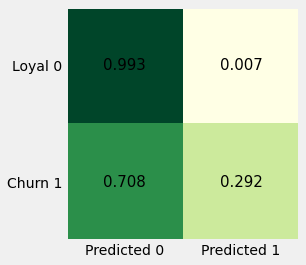

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.879220	0.937330	0.993023	0.291667	0.782895	0.425000	0.454292
Suggested image name:
images/RandomForest.ConfusMx.criterion=entropy.max_features=0.4.max_depth=15.n_estimators=73.png


In [506]:
# Quality metrics
y_pred = rf_opt.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, rf_opt, prnt=True)
#print(classification_report(y_test, y_pred))

print("Suggested image name:")
print(f"images/RandomForest.ConfusMx.criterion={criterion}.max_features={max_features}.max_depth={max_depth}.n_estimators={n_estimators}.png")

In [507]:
pkl_model = 'models/rf.criterion='+rf_opt.criterion+'.max_features='+str(rf_opt.max_features)+'.max_depth='+str(rf_opt.max_depth)+'.n_estimators='+str(rf_opt.n_estimators)
if standardize: pkl_model = pkl_model + '.std'
pkl_model = pkl_model + '.pkl'
    #pkl_model = 'models/rf.criterion_'+rf_opt.solver+'.maxiter_'+str(rf_opt.max_iter)+'.C_'+str(model.C)+'.classweight_'+str(model.class_weight[1])+'.pkl'
pickle.dump(model, open(pkl_model, 'wb'))
# Use of model attributes is more reliable than variables like 'solver', since the latter can become outdated.
# model.class_weight implies class_weight={0: 1, 1: class_weight} format. Change to model.class_weight if using scalar format.
print("Saved the fitted model:",pkl_model)

Saved the fitted model: models/rf.criterion=entropy.max_features=0.4.max_depth=15.n_estimators=73.pkl


#### ROC AUC with optimized threshold

Best Threshold = 0.0600, G-Mean_sq = 0.6427
FPR = 0.2465, TPR = 0.8529


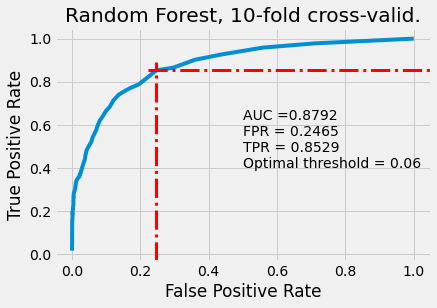

AUC: 0.879220
Suggested image name:
images/RandomForest.ROC.criterion=entropy.max_features=0.4.max_depth=15.n_estimators=73.png


In [513]:
y_pred_probs = rf_opt.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
FPR = np.empty(int(1+1/prob_step))
TPR = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(y_pred_probs.shape[0]): # each test case
        if y_pred_probs[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    FPR[j] = fp/(tn + fp) # specificity
    TPR[j] = tp/(tp + fn) # sensitivity
    j = j+1
#print("FPR =",FPR)
#print("TPR =",TPR)
# ROC curve
plt.plot(FPR, TPR, linestyle='-', label='RF')
plt.title('Random Forest, 10-fold cross-valid.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()

# calculate the squared g-mean for each threshold
gmeans_sq = TPR * (1-FPR)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold = %.4f, G-Mean_sq = %.4f' % (thresholds[ix], gmeans_sq[ix]))
print('FPR = %.4f, TPR = %.4f' % (FPR[ix], TPR[ix]))
plt.axvline(x=FPR[ix], ymin=0, ymax=TPR[ix], color='red', linestyle='dashdot', linewidth=3)
plt.axhline(y=TPR[ix], xmin=FPR[ix], xmax=1, color='red', linestyle='dashdot', linewidth=3)
txt_auc = 'AUC ='+str(round(roc_auc_score(y_test, y_pred_probs[:,1]),4))+'\nFPR = '+str(round(FPR[ix],4))+\
    '\nTPR = '+str(round(TPR[ix],4))+'\nOptimal threshold = '+str(thresholds[ix])
plt.text(0.5, 0.4, txt_auc)
plt.show()
print('AUC: %.6f' % roc_auc_score(y_test, y_pred_probs[:,1]))

print("Suggested image name:")
print(f"images/RandomForest.ROC.criterion={criterion}.max_features={max_features}.max_depth={max_depth}.n_estimators={n_estimators}.png")

#### Precision-Recall Curve
<b>Precision</b> = tp/(tp+fp) - proportion of correct `prediction = 1`.

<b>Recall</b> = tp/(tp+fn) - proportion of correct `prediction = 1` out of all actual 1's.

AUC: 0.538
Suggested image name:
images/RandomForest.Precision_Recall.criterion=entropy.max_features=0.4.max_depth=15.n_estimators=73.png


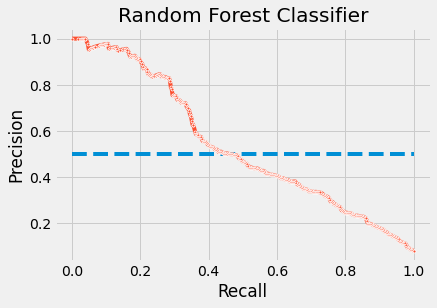

In [509]:
y_score = rf_opt.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc_score = auc(recall, precision)
sns.lineplot([0, 1], [0.5, 0.5], linestyle='--')
ax = sns.lineplot(recall, precision, marker='.')
ax.set(xlabel='Recall', ylabel='Precision', title='Random Forest Classifier')
print('AUC: %.3f' % pr_auc_score)

print("Suggested image name:")
print(f"images/RandomForest.Precision_Recall.criterion={criterion}.max_features={max_features}.max_depth={max_depth}.n_estimators={n_estimators}.png")

### 4.5 XGBoost
XGBoost uses Classification and Regression (CART) trees and instead of containing a single decision in each “leaf” node, they contain real-value scores of whether an instance belongs to a group. After the tree reaches max depth, the decision can be made by converting the scores into categories using a certain threshold.

https://www.youtube.com/playlist?list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ

You can learn more about the defaults for the XGBClassifier and XGBRegressor classes in the <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn">XGBoost Python scikit-learn API</a>.

You can learn more about the meaning of each parameter and how to configure them on the <a href="https://xgboost.readthedocs.io/en/latest//parameter.html">XGBoost parameters page</a>.
We can make predictions using the fit model on the test dataset.
To make predictions we use the scikit-learn function <b>model.predict()</b>.
By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1.

#### Default hyperparameters

In [358]:
#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = XGBClassifier()
xgbc0.fit(X_train, y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

display(default_params)

[00:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'objective': ['binary:logistic'],
 'use_label_encoder': [True],
 'base_score': [0.5],
 'booster': ['gbtree'],
 'colsample_bylevel': [1],
 'colsample_bynode': [1],
 'colsample_bytree': [1],
 'enable_categorical': [False],
 'gamma': [0],
 'gpu_id': [-1],
 'importance_type': [None],
 'interaction_constraints': [''],
 'learning_rate': [0.300000012],
 'max_delta_step': [0],
 'max_depth': [6],
 'min_child_weight': [1],
 'missing': [nan],
 'monotone_constraints': ['()'],
 'n_estimators': [100],
 'n_jobs': [4],
 'num_parallel_tree': [1],
 'predictor': ['auto'],
 'random_state': [0],
 'reg_alpha': [0],
 'reg_lambda': [1],
 'scale_pos_weight': [1],
 'subsample': [1],
 'tree_method': ['exact'],
 'validate_parameters': [1],
 'verbosity': [None]}

In [388]:
#dictionary for collecting results
results_dict = {}

#Benchmark model: grid search is not performed, since only single values (default) are provided as hyperparameter grid.
#However, cross-validation is still executed.
clf0 = GridSearchCV(estimator=xgbc0, scoring='roc_auc', param_grid=default_params, return_train_score=True, verbose=1, cv=10)
clf0.fit(X_train, y_train)

#results dataframe
scores_xgb = pd.DataFrame(clf0.cv_results_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[01:20:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:20:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:20:56

In [386]:
def scores_xgb_table(scores_xgb): # Table of results (1st record only), paste it into a Markdown cell
    dr = 6 # digits rounding
    print("|booster|learning_rate|n_estimators|max_depth|reg_alpha|reg_lambda|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|")
    print("|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|")
    print(f"|{scores_xgb['param_booster'].to_list()[0]}|\
        {scores_xgb['param_learning_rate'].to_list()[0]}|\
        {scores_xgb['param_n_estimators'].to_list()[0]}|\
        {scores_xgb['param_max_depth'].to_list()[0]}|\
        {scores_xgb['param_reg_alpha'].to_list()[0]}|\
        {scores_xgb['param_reg_lambda'].to_list()[0]}|\
        {scores_xgb['param_scale_pos_weight'].to_list()[0]}|\
        {round(scores_xgb['mean_train_score'].to_list()[0], dr)}|\
        {round(scores_xgb['std_train_score'].to_list()[0], dr)}|\
        <b>{round(scores_xgb['mean_test_score'].to_list()[0], dr)}|\
        {round(scores_xgb['std_test_score'].to_list()[0], dr)}|")

In [389]:
scores_xgb_table(scores_xgb)

|booster|learning_rate|n_estimators|max_depth|reg_alpha|reg_lambda|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|gbtree|        0.300000012|        100|        6|        0|        1|        1|        0.989046|        0.000821|        <b>0.849074|        0.022347|


|booster|learning_rate|n_estimators|max_depth|reg_alpha|reg_lambda|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|gbtree|        0.300000012|        100|        6|        0|        1|        1|        0.989046|        0.000821|        <b>0.849074|        0.022347|

#### Custom hyperparameters

In [583]:
# Instantiate model with custom hyperparameters
xgb = XGBClassifier(
    booster = 'gbtree', # 'gbtree'
    learning_rate = 0.039, # Boosting learning rate, [0.3]
    n_estimators=220, # Number of boosting rounds, default is [100]
    max_depth=6,    # Maximum tree depth for base learners, [6]
    reg_alpha=3.363, reg_lambda=1.03,scale_pos_weight=1,
    random_state=0, n_jobs=-1)
# Train the model on training data
xgb.fit(X_train, y_train)
# Assess the model
scores_all(X_test, y_test, xgb, prnt=True) # 30% test set

[23:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.876614	0.931296	0.993023	0.215686	0.727273	0.332703	0.372124


(0.8766143825394852,
 0.9312962242117555,
 0.9930232558139535,
 0.21568627450980393,
 0.7272727272727273,
 0.332703213610586,
 0.37212444247994353)

#### Grid sweeping of hyperparameters

In [605]:
# Initialize score dataframe
if standardize:
    scores_csv = "data/XGBClassifier.score.learningrate_nestimators.std.csv"
else:
    scores_csv = "data/XGBClassifier.score.learningrate_nestimators.csv"    
if os.path.exists(scores_csv):
    scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['booster','learning_rate','n_estimators','max_depth',
                                'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
#display(scores.head())
#display(scores.tail())
print(scores.shape)

(6169, 14)


In [604]:
scores.sort_values(by=['booster','learning_rate','n_estimators','max_depth','reg_alpha','reg_lambda','scale_pos_weight'], inplace=True)
scores.drop_duplicates()
scores.to_csv(scores_csv, index=False)

In [ ]:
for booster in ['gblinear']: #['gbtree','gblinear','dart']:
    for learning_rate in np.arange(0.039-0.006, 0.039+0.007, 0.001): #np.arange(0.038,0.040+0.001,0.001): # 0-0.3, [0.039]
        for n_estimators in np.arange(221-6, 221+7, 1): #np.arange(220,222+1,1): # 1-250, [221]
            for max_depth in [6]: #np.arange(5,7+1,1): # 1-53, [6]
                for reg_alpha in [3.362]: #np.arange(3.364,3.370+0.001,0.001): #0-10, [3.362]
                    for reg_lambda in [1.03]: #np.arange(1.021, 1.04,0.001): # 0-10, [1.03]
                        for scale_pos_weight in [1]: #np.arange(0.99,1.0101,0.001): # [1]
                            # Train model
                            model = XGBClassifier(booster=booster, learning_rate=learning_rate, n_estimators=n_estimators,\
                                max_depth=max_depth,reg_alpha=reg_alpha,reg_lambda=reg_lambda,scale_pos_weight=scale_pos_weight,
                                eval_metric='logloss', use_label_encoder=False).fit(X_train, y_train)
                            # Evaluate predictions
                            roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, model);
                            scores = scores.append({'booster':booster,'learning_rate':round(learning_rate,3),'n_estimators':n_estimators,\
                                'max_depth':max_depth,'reg_alpha':reg_alpha,'reg_lambda':reg_lambda,'scale_pos_weight':scale_pos_weight,
                                'roc_auc':roc_auc,'accuracy':accuracy,'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
        scores.to_csv(scores_csv, index=False)
scores.sort_values(by=['booster','learning_rate','n_estimators','max_depth','reg_alpha','reg_lambda','scale_pos_weight'], inplace=True)
scores.drop_duplicates()
scores.to_csv(scores_csv, index=False)

[01:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could b

[01:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could b

[01:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could b

In [641]:
# Optimal hyperparameters
idx = np.argmax(scores['roc_auc'])
ds = scores.iloc[idx]
roc_auc_max = ds['roc_auc']
print("Currently maximal roc_auc:",roc_auc_max)
print("Currently optimal hyperparameters:")
print( scores.iloc[idx] )

Currently maximal roc_auc: 0.8766698275504705
Currently optimal hyperparameters:
booster                 dart
learning_rate          0.039
n_estimators             221
max_depth                  6
reg_alpha              3.362
reg_lambda              1.03
scale_pos_weight         1.0
roc_auc              0.87667
accuracy            0.931296
tnr                 0.993023
tpr                 0.215686
precision           0.727273
f1                  0.332703
mcc                 0.372124
Name: 2, dtype: object


#### Performance of XGBoost: 70-30% train-test split

|Optimization|booster|learning_rate|n_estimators|max_depth|reg_alpha|reg_lambda|scale_pos_weight|roc_auc|accuracy|tnr|tpr|precision|f1|mcc|
|:----------:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Default     |gbtree*|0.3|100|6|0|1|1|0.845409|0.931685|0.988795|0.269608|0.674847|0.385289|0.398628|
|learning_rate|gbtree|0.039|100|6|0|1|1|0.870159|0.933632|0.994715|0.225490|0.786325|0.350476|0.399116|
|n_estimators|gbtree|0.039|216|6*|0|1|1|0.872758|0.934605|0.993658|0.250000|0.772727|0.377778|0.416397|
|reg_alpha|gbtree|0.039|216|6|3.360|1*|1*|0.876391|0.931296|0.993023|0.215686|0.727273|0.332703|0.372124|
|n_estimators|gbtree*|0.039*|220*|6*|3.360*|1*|1*|0.876461|0.931491|0.993023|0.218137|0.729508|0.335849|0.374986|
|reg_alpha, reg_lambda|gbtree*|0.039*|220|6|3.363|1.03|1|0.876614|0.931296|0.993023|0.215686|0.727273|0.332703|0.372124|
|n_estimators|gbtree|0.039|221|6*|3.363|1.03|1|0.876669|0.931296|0.993023|0.215686|0.727273|0.332703|0.372124|
|reg_alpha|gbtree*|0.039*|221*|6*|3.362|1.03*|1*|<font color='red'>0.876670|0.931296|0.993023|0.215686|0.727273|0.332703|0.372124|

*Hyperparameter value does not change after its optimization.

#### 10-fold cross-validation

|Optimization|booster|learning_rate|n_estimators|max_depth|reg_alpha|reg_lambda|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:----------:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Default     |gbtree|0.3|100|6|0|1|1|0.989046|0.000821|<b>0.849074|0.022347|

array([215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227])

In [645]:
np.arange(0.039-0.006, 0.039+0.007, 0.001)

array([0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04 , 0.041,
       0.042, 0.043, 0.044, 0.045])

In [642]:
# Contour plot for a chosen booster
booster = 'gblinear' # gbtree, gblinear, dart
ds = scores.loc[scores['booster']==booster] # dataset selection
x_val = ds['learning_rate'].unique()
y_val = ds['n_estimators'].unique()
levels=np.arange(np.floor(np.min(ds['roc_auc'])*100)/100,1.001,0.01)

#https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
plt.contourf(x_val, y_val, np.array(ds['roc_auc']).reshape(len(y_val), len(x_val)),
             levels=levels, cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.colorbar();
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
#plt.ylim(1,200)
plt.suptitle(f'Unscaled, 30% test, booster: {booster}');

ValueError: cannot reshape array of size 6 into shape (3,3)

In [ ]:
# Contour plot for a chosen booster
booster = 'gbtree' # gbtree, gblinear, dart
ds = scores.loc[scores['booster']==booster] # dataset selection
x_val = ds['learning_rate'].unique()
y_val = ds['n_estimators'].unique()

#https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
plt.contourf(x_val, y_val, np.array(ds['roc_auc']).reshape(len(y_val), len(x_val)),
             levels=levels, cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
#plt.colorbar();
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
#plt.ylim(30,45)
plt.suptitle(f'Unscaled, 30% test, booster: {booster}');

In [ ]:
n_estimators = 196
plt.figure(figsize=(20, 8))
for booster in ['gbtree','gblinear']:
    ds = scores.loc[(scores['booster']==booster) & (scores['n_estimators']==n_estimators)] # selection dataset
    plt.scatter( x = ds['learning_rate'], y = ds['roc_auc'], label=booster);
plt.title('XGBoost performance for different boosters vs learning_rate');
plt.xlabel('learning_rate');
plt.ylabel('ROC AUC');
plt.legend(['gbtree','gblinear']);

In [ ]:
n_estimators = 70
plt.figure(figsize=(5.8, 3))
for booster in ['gbtree','gblinear']:
    ds = scores.loc[(scores['booster']==booster) & (scores['n_estimators']==n_estimators)] # selection dataset
    plt.scatter( x = ds['learning_rate'], y = ds['roc_auc'], label=booster);
plt.title('Performance of boosters');
plt.xlim(0,1)
plt.ylim(0.92,0.97)
plt.xlabel('learning_rate');
plt.ylabel('ROC AUC');
plt.legend(['gbtree','gblinear']); #xgboost_test30.auc.learningrate.gbtree_gblinear.png

In [ ]:
plt.figure(figsize=(20, 8))
for booster in ['gbtree','gblinear']:
    plt.scatter( x = scores.loc[scores['booster']==booster]['learning_rate'],
           y = scores.loc[scores['booster']==booster]['roc_auc'], label=booster);
plt.title('XGBoost performance for different boosters vs learning_rate');
plt.xlabel('learning_rate');
plt.ylabel('ROC AUC');
plt.legend(['gbtree','gblinear']);

#### Grid search with CV on train set

In [895]:
# Grid of hyperparameters to search over
param_grid = param_grid = {'n_estimators':np.arange(30,32+1,1),\
              'max_depth':np.arange(12,14+1,1),\
              'learning_rate':np.arange(0.152,0.154+0.001,0.001),\
              'booster':['gbtree'],\
              'reg_alpha':np.arange(4.5,4.7+0.1,0.1),\
              'scale_pos_weight':np.arange(1,3+1,1)}
#'booster':['gbtree', 'gblinear', 'dart']

xgb = XGBClassifier()
# Grid search with 10-fold cross-validation on train set
clf = GridSearchCV(estimator=xgb, scoring='roc_auc', param_grid=param_grid, return_train_score=True, cv=10, verbose=0)
clf.fit(X_train, y_train) 

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
# Table of best hyperparameters
scores_xgb_table( scores_xgb.loc[(scores_xgb['param_learning_rate'] == bp['learning_rate']) & (scores_xgb['param_max_depth'] == bp['max_depth'])\
              & (scores_xgb['param_n_estimators'] == bp['n_estimators']) & (scores_xgb['param_booster'] == bp['booster'])] )

|n_estimators|max_depth|learning_rate|booster|reg_alpha|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|30|        12|        0.152|        gbtree|        4.5|        1|        0.935155|        0.001322|        <b>0.872644|        0.022018|


|n_estimators|max_depth|learning_rate|booster|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|16|        11|        0.14|        gbtree|        0.944522|        0.0028|        <b>0.870731|        0.022328|

In [291]:
# Grid of hyperparameters to search over
param_grid = {'n_estimators':np.arange(49,49+1,1),\
              'max_depth':np.arange(19,19+1,1),\
              'learning_rate':np.arange(0.179,0.179+0.001,0.001),\
              'booster':['gbtree'],\
              'reg_alpha':np.arange(6.3,6.5+0.1,0.1),\
              'reg_lambda':np.arange(7.3,7.5+0.1,0.1),\
              'scale_pos_weight':np.arange(1,1+1,1)}
#['gbtree', 'gblinear', 'dart']
xgb = XGBClassifier()
# Grid search with 10-fold cross-validation on train set
clf = GridSearchCV(estimator=xgb, scoring='roc_auc', param_grid=param_grid, return_train_score=True, verbose=0, cv=10)
clf.fit(X_train, y_train) 

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
# Table of best hyperparameters
scores_xgb_table( scores_xgb.loc[(scores_xgb['param_learning_rate'] == bp['learning_rate']) & (scores_xgb['param_max_depth'] == bp['max_depth'])\
              & (scores_xgb['param_n_estimators'] == bp['n_estimators'])] )

[19:15:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:16:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
# Instantiate model with custom hyperparameters
xgb = XGBClassifier(random_state = 42, verbosity=1, n_jobs=-1, oob_score=True)
param_grid = {'n_estimators':np.arange(10,60+1,10), 'max_depth':[8,9,10,11,12], 'max_delta_step':[1,2], 'scale_pos_weight':[1,100]}
xgb_opt, y_pred, scores = grid_search(X_train, X_test, y_train, xgb, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=True)

# Display optimal result
scores_opt = scores.loc[scores['rank_test_score']==1]
display(scores_opt) # highest-score record
print("mean ROC AUC", scores_opt['mean_test_score'].tolist()[0])

#### Randomized search with CV on train set

In [978]:
?XGBClassifier

In [589]:
X_train.shape

(11986, 53)

In [592]:
# Grid of hyperparameters for randomized search: Vicinity of the best values, t = 8 s/value
param_grid = {'n_estimators':np.arange(1,150+1,1),\
              'max_depth':np.arange(1,50+1,1),\
              'learning_rate':np.arange(0.001,0.3+0.0001,0.001),\
              'booster':['gbtree'],\
              'reg_alpha':np.arange(0.1,4.8+0.1,0.1),\
              'reg_lambda':np.arange(0.1,9.1+0.1,0.1),\
              'scale_pos_weight':np.arange(0.1,5.1+1,0.1)}
#'booster':['gbtree', 'gblinear', 'dart'],\
xgb = XGBClassifier()
# Randomized Search with 10-fold cross-validation on train set
clf = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, scoring='roc_auc', n_iter=2, return_train_score=True, verbose=0)
clf.fit(X_train[:100], y_train[:100]) 

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
print("Best parameters:\n",bp)
bs = clf.best_score_ # best score
print("Best ROC AUC:",bs)
# Best record:
scores_xgb_opt = scores_xgb.loc[scores_xgb['rank_test_score']==1].drop(['params','rank_test_score'],axis=1)\
    .filter(regex='^((?!time).)*$').filter(regex='^((?!split).)*$') # exclude columns with 'time' and 'split' in the names
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
print("Best record:\n", scores_xgb_opt)
# Table of best hyperparameters
scores_xgb_table(scores_xgb_opt)

OverflowError: Python int too large to convert to C long

In [588]:
# Grid of hyperparameters for randomized search: Vicinity of the best values, t = 8 s/value
param_grid = {'n_estimators':np.arange(1,5+1,1),\
              'max_depth':np.arange(1,50+1,1),\
              'learning_rate':np.arange(0.001,0.3+0.0001,0.001),\
              'booster':['gbtree'],\
              'reg_alpha':np.arange(0.1,4.8+0.1,0.1),\
              'reg_lambda':np.arange(0.1,9.1+0.1,0.1),\
              'scale_pos_weight':np.arange(0.1,5.1+1,0.1)}
#'booster':['gbtree', 'gblinear', 'dart'],\
xgb = XGBClassifier()
# Randomized Search with 10-fold cross-validation on train set
clf = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, scoring='roc_auc', n_iter=200, return_train_score=True, cv=10, verbose=0)
clf.fit(X_train, y_train) 

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
print("Best parameters:\n",bp)
bs = clf.best_score_ # best score
print("Best ROC AUC:",bs)
# Best record:
scores_xgb_opt = scores_xgb.loc[scores_xgb['rank_test_score']==1].drop(['params','rank_test_score'],axis=1)\
    .filter(regex='^((?!time).)*$').filter(regex='^((?!split).)*$') # exclude columns with 'time' and 'split' in the names
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
print("Best record:\n", scores_xgb_opt)
# Table of best hyperparameters
scores_xgb_table(scores_xgb_opt)

OverflowError: Python int too large to convert to C long

|n_estimators|max_depth|learning_rate|booster|reg_alpha|reg_lambda|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|23|        15|        0.178|        gbtree|        4.7|        9.0|        2|        0.949231|        0.001135|        <b>0.875462|        0.019008|

#### Bayes search
The idea is to build a probability model of the objective function using Bayes theorem for posterior probabilities and use it to select the most promising hyperparameters to evaluate in the true objective function.

In [986]:
?XGBClassifier

In [593]:
# Grid of hyperparameters for randomized search
param_grid = {'n_estimators':np.arange(22,24+1,1),\
              'max_depth':np.arange(14,16+1,1),\
              'learning_rate':np.arange(0.177,0.179+0.0001,0.001),\
              'booster':['gbtree'],\
              'reg_alpha':np.arange(4.6,4.8+0.1,0.1),\
              'reg_lambda':np.arange(8.9,9.1+0.1,0.1),\
              'scale_pos_weight':np.arange(1.9,2.1+1,1)}
clf = BayesSearchCV(estimator=XGBClassifier(), search_spaces=param_grid, n_iter=3, scoring='roc_auc', cv=10, return_train_score=True, verbose=0)
clf.fit(X_train, y_train) 

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
print("Best parameters:\n",bp)
bs = clf.best_score_ # best score
print("Best ROC AUC:",bs)
# Best record:
scores_xgb_opt = scores_xgb.loc[scores_xgb['rank_test_score']==1].drop(['params','rank_test_score'],axis=1)\
    .filter(regex='^((?!time).)*$').filter(regex='^((?!split).)*$') # exclude columns with 'time' and 'split' in the names
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
print("Best record:\n", scores_xgb_opt)
# Table of best hyperparameters
scores_xgb_table(scores_xgb_opt)

NameError: name 'BayesSearchCV' is not defined

In [600]:
from skopt import BayesSearchCV

ModuleNotFoundError: No module named 'skopt'

|n_estimators|max_depth|learning_rate|booster|reg_alpha|reg_lambda|scale_pos_weight|AUC train mean|AUC train std|AUC test mean|AUC test std|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|24|        14|        0.178|        gbtree|        4.6|        9.1|        2.3955968597768855|        0.957152|        0.001294|        <b>0.875531|        0.020385|

In [98]:
xgb_opt = XGBClassifier(
    n_estimators = 24, # Number of boosting rounds, default is [100]
    max_depth = 14,    # Maximum tree depth for base learners, [6]
    learning_rate = 0.178, # Boosting learning rate, [0.3]
    booster = 'gbtree', # ['gbtree'], 'gblinear', 'dart'
    reg_alpha = 4.6,
    reg_lambda = 9.1,
    scale_pos_weight = 2.3956,
    random_state=0, n_jobs=-1)
xgb_opt.fit(X_train, y_train) # Train the model on training data

[00:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.178, max_delta_step=0,
              max_depth=14, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=24, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=4.6, reg_lambda=9.1, scale_pos_weight=2.3956,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [99]:
scores_all(X_test, y_test, xgb_opt, prnt=True)

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.879161	0.924484	0.970402	0.392157	0.533333	0.451977	0.418066


(0.8791612258011028,
 0.9244842351109381,
 0.9704016913319239,
 0.39215686274509803,
 0.5333333333333333,
 0.4519774011299435,
 0.41806638460968903)

Test 0.8791612258011028


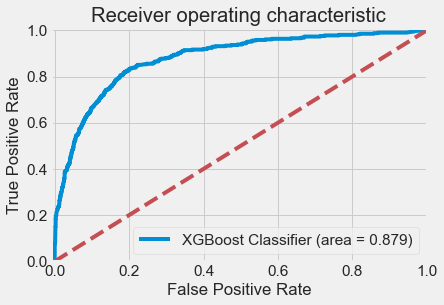

[[TN, FP], [FN, TP]] =
 [[4590  140]
 [ 248  160]]


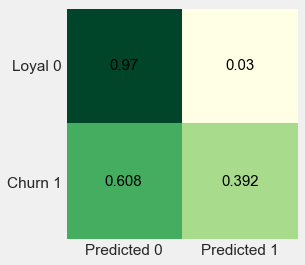

In [101]:
y_score = xgb_opt.predict_proba(X_test)[:,1] # Predictions of optimized XGBoost classifier
roc_auc = roc_auc_score(y_test, y_score)

print("Test",roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
plt.plot(fpr, tpr, label='XGBoost Classifier (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Confusion matrix plot
y_pred=xgb_opt.predict(X_test)
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)

#### Other hyperparameters for future study
https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

In [ ]:
?XGBClassifier

## Explanation of XGBoost model using SHAP
Explain your model with the <a href="https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d">SHAP (SHapley Additive exPlanations)</a>.

Inspired by several methods (1,2,3,4,5,6,7) on model interpretability, <a href="https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf">Lundberg and Lee (2016)</a> proposed the SHAP value as a united approach to explaining the output of any machine learning model. The Shapley value is the average of the marginal contributions across all permutations.
* Global interpretability — the collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable (SHAP value plot).
* Local interpretability — each observation gets its own set of SHAP values (individual SHAP value plot).
* The SHAP values can be calculated for any tree-based model, while other methods use linear regression or logistic regression models as the surrogate models.
If your model is a tree-based machine learning model, you should use the tree explainer `TreeExplainer()` that has been optimized to render fast results. If your model is a deep learning model, use the deep learning explainer `DeepExplainer()`. For all other types of algorithms (such as KNNs), use `KernelExplainer()`. Also, the SHAP api has <a href="https://dataman-ai.medium.com/the-shap-with-more-elegant-charts-bc3e73fa1c0c?sk=7b4aee5d67f52db8ac824b07fd0b84a6">more recent development</a>.

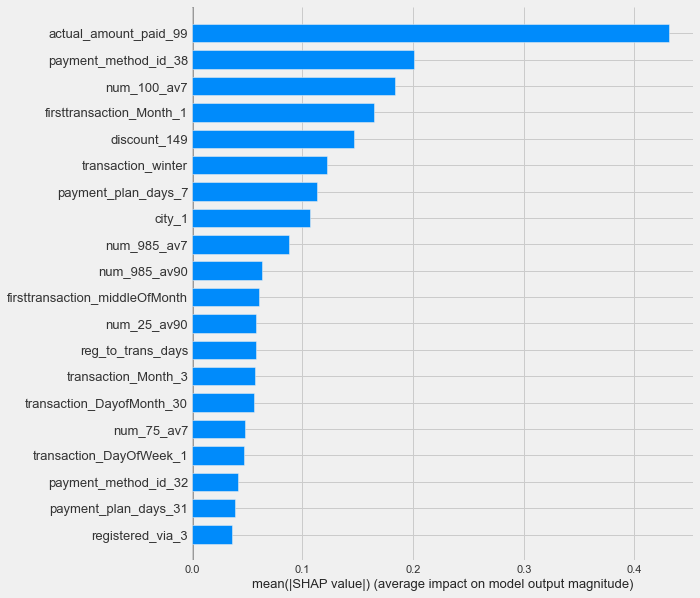

In [64]:
shap_values = shap.TreeExplainer(xgb_opt).shap_values(X_train) # If takes long, X_train.iloc[:2000,:]
shap.summary_plot(shap_values, X_train, plot_type="bar")

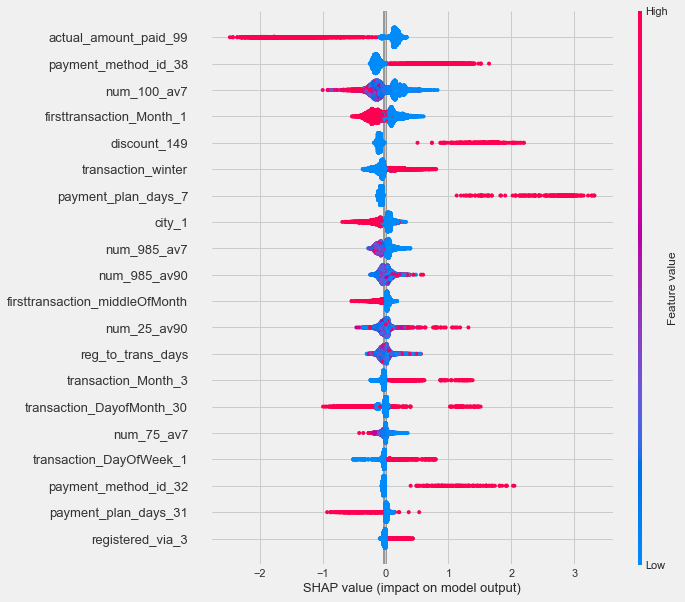

In [65]:
shap.summary_plot(shap_values, X_train)

This SHAP summary plot helps describe the model. A churn is associated with the following characteristics, in descending order of their importance.
* Actual amount paid is not $99.
* Payment method id is 38.
* Small number of fully listened songs over the last week.
* First transaction was not in the beginning of the year (not January).
* Discount was \$149.
* The transaction is in winter.
* Payment plan is only for 7 days.
* The member is not from city 1 (this needs to be verified, there is a chance that this is due to a high proportion of people from city 1, or there could be a mixture of high and low values of this feature not visible on the plot).
* Small number of songs listened between 75% and 98.5% last week.
* First transaction is not in the 2nd decade of a month.
* Large number of songs listened between 0 and 25% of length in the last 3 months.
* Transaction is in March.
* Small number of songs listened between 50% and 75% last week.
* Transaction is on Monday.
* Payment method id is 32.
* Member registration channel is 3.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature (y) vs. the value of the feature for all the examples in a dataset (x). Vertical dispersion at a single value of the feature represents interaction effects with other features. To help reveal these interactions `dependence_plot` automatically selects another feature for coloring.

In [ ]:
# Select the most important feature:
shap.dependence_plot("num_25_av90", shap_values, X_train)

# Select 2nd most important feature:
shap.dependence_plot("reg_to_trans_days", shap_values, X_train)

### Results: Quality metrics
Since we want to correctly classify the positive class `is_churn == 1`, a higher TPR and a lower FNR is desirable. We use ROC-AUC score as a main quality metric.

https://pythondata.com/comparing-machine-learning-methods/

In [153]:
# Optimized models
#lr_opt = LogisticRegression(solver='lbfgs', max_iter=20, C=70, class_weight='balanced', random_state=0).fit(X_train, y_train)
outcome = []
model_names = []
models = [('LogReg', lr_opt), ('DecTree', dt_opt), ('RandomForest', rf_opt), ('XGBoost', xgb_opt)]

In [154]:
for model_name, model in models:
    k_fold_validation = KFold(n_splits=10, random_state=0) # 10 splits
    results = cross_val_score(model, X, y, cv=k_fold_validation, scoring='roc_auc') #'accuracy'
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)

LogReg| Mean=0.836855 STD=0.033439
DecTree| Mean=0.670549 STD=0.037760
RandomForest| Mean=0.857779 STD=0.026130
[01:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric i

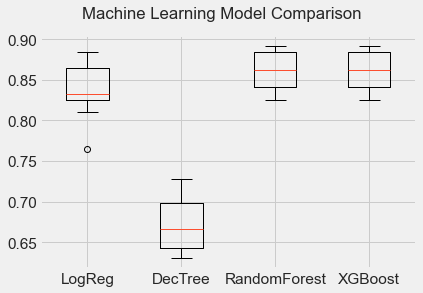

In [150]:
fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show() #images/Models.AUC_std_cv10.png

| Model | ROC-AUC_CV10 | STD_AUC | ROC-AUC | Accuracy | TNR | TPR | Precision | F1 | MCC |
|:------|:-----------|:-------:|:--------:|:---:|:---:|:---------:|:--:|:---:|:---:|
| XGBoost | 0.861316 | 0.024332 | 0.879147 | 0.924484 | 0.970402 | 0.392157 | 0.533333 | 0.451977 | 0.418066 |
| Random Forest |0.857779|0.026130|0.876482|0.934216|0.99556|0.223039|0.812500|0.350000|0.404752|
| Logistic Regression|0.836855|0.033439|0.845863|0.803815|0.807188|0.764706|0.254902|0.382353|0.362974|
| Decision Tree|0.672499|0.033853|


XGBoost is the best model.

## 6. Data modeling with equal proportion of churn and non-churn
To balance 0/1 classes (non-churn and churn), let us take all churn and only 40% of non-churn at random. 

In [283]:
# Take df before IV and VIF filtering, but after encoding

# Import data or create standardized dataset
standardize = True # if to standardize continuous features (float, int); also check if input was already standardized
if standardize:
    csv = "data/df_20161022_onehot.std.csv"
    if os.path.exists(csv):
        df = pd.read_csv(csv)
    else:
        cols2standardize = [col for col in X.columns if col in ['reg_to_trans_days','num_25_av7','num_50_av7','num_75_av7','num_985_av7',
    'num_100_av7','num_25_av30','num_50_av30','num_75_av30','num_985_av30','num_100_av30','num_25_av90','num_50_av90',
    'num_75_av90','num_985_av90','num_100_av90','num_unq_av7','num_unq_av30','num_unq_av90',
    'total_secs_av7','total_secs_av30','total_secs_av90'] ]
        print("Standardize continuous features:",cols2standardize)
        print(f"No. of features to standardize: {len(cols2standardize)}")
        display(X[cols2standardize].head(1))
        scaler = StandardScaler()
        X_std = pd.DataFrame(scaler.fit_transform(X[cols2standardize]), columns=cols2standardize) # standardized continuous variables
        X_nostd = X.drop(cols2standardize, axis=1) # all other variables
        X = pd.concat([X_nostd,pd.DataFrame(X_std)], axis=1) # concatenate columns
        print(f"For predictions, use\nscaler = StandardScaler(with_mean = {scaler.mean_}, with_std = {scaler.scale_})")
        # np.mean(X[cols2standardize]); to be re-used in predictions
        print("X is standardized (mean = 0, sd = 1), X.shape =",X.shape)
        df = pd.concat([pd.DataFrame(X),pd.DataFrame(y, columns=['is_churn'])],axis=1)
        df.to_csv(csv, index=False)
else: # non-scaled
    print("X is not standardized, but check if it was already standardized")
    csv = "data/df_20161022_onehot.csv"
    df = pd.read_csv(csv)

Standardize continuous features: ['num_100_av7', 'num_25_av7', 'num_25_av90', 'num_50_av7', 'num_75_av7', 'num_985_av7', 'num_985_av90', 'reg_to_trans_days']
No. of features to standardize: 8


num_100_av7  num_25_av7  num_25_av90  num_50_av7  num_75_av7  num_985_av7  \
0        41.25         4.5     4.433333       1.625        1.25          1.0   

   num_985_av90  reg_to_trans_days  
0      0.977778               4098

For predictions, use
scaler = StandardScaler(with_mean = [1.87486511e+01 4.32273202e+00 4.71484475e+00 1.16602346e+00
 6.76507492e-01 6.76610800e-01 7.64879503e-01 9.34972553e+02], with_std = [ 33.0927287    9.49856441   8.14776768   3.00943249   1.49489537
   1.39433428   1.30462745 955.98922281])
X is standardized (mean = 0, sd = 1), X.shape = (17124, 53)


In [284]:
Churn=df[df.is_churn==1]
display(Churn.shape)
No_Churn=df[df.is_churn==0]
# Subset No_Churn
No_Churn_sample=No_Churn.sample(n = Churn.shape[0])  # Take the same number of non-churn as churn
print("Equal non-churn sample: ", No_Churn_sample.shape)

X_eq=pd.concat([Churn,No_Churn_sample]);
print("Sample with same sizes of churn and non-churn:", X_eq.shape)

(1354, 54)

Equal non-churn sample:  (1354, 54)
Sample with same sizes of churn and non-churn: (2708, 54)


In [285]:
X_train_eq, X_test_eq, y_train_eq, y_test_eq = train_test_split(X_eq.drop(columns='is_churn'), 
                                                    X_eq['is_churn'], test_size=0.3, random_state=47)
print("Train samples:",y_train_eq.shape[0])
print("Test samples:",y_test_eq.shape[0])

Train samples: 1895
Test samples: 813


In [286]:
final_iv, IV = data_vars(X_train_eq, y_train_eq) # as per sample

actual_amount_paid_119
actual_amount_paid_129
actual_amount_paid_150
actual_amount_paid_536
actual_amount_paid_99
bd_18
bd_21
city_1
discount_149
firsttransaction_DayofMonth_21
firsttransaction_DayofMonth_29
firsttransaction_DayofMonth_30
firsttransaction_DayofMonth_4
firsttransaction_Month_1
firsttransaction_Month_12
firsttransaction_Month_4
firsttransaction_Month_6
firsttransaction_Month_9
firsttransaction_middleOfMonth
firsttransaction_spring
firsttransaction_summer
gender_male
payment_method_id_29
payment_method_id_32
payment_method_id_37
payment_method_id_38
payment_method_id_40
payment_plan_days_10
payment_plan_days_195
payment_plan_days_31
payment_plan_days_410
payment_plan_days_7
registered_via_0
registered_via_3
registered_via_4
transaction_DayOfWeek_1
transaction_DayOfWeek_5
transaction_DayofMonth_21
transaction_DayofMonth_29
transaction_DayofMonth_30
transaction_Month_12
transaction_Month_3
transaction_Month_6
transaction_Month_7
transaction_winter
num_100_av7
0    0.270321


In [287]:
final_iv

VAR_NAME  MIN_VALUE  MAX_VALUE  COUNT  EVENT  \
0            actual_amount_paid_119   0.000000   0.000000   1875    946   
1            actual_amount_paid_119   1.000000   1.000000     20      1   
2            actual_amount_paid_129   0.000000   0.000000   1828    934   
3            actual_amount_paid_129   1.000000   1.000000     67     13   
4            actual_amount_paid_150   0.000000   0.000000   1837    902   
5            actual_amount_paid_150   1.000000   1.000000     58     45   
6            actual_amount_paid_536   0.000000   0.000000   1885    940   
7            actual_amount_paid_536   1.000000   1.000000     10      7   
8             actual_amount_paid_99   0.000000   0.000000   1702    923   
9             actual_amount_paid_99   1.000000   1.000000    193     24   
10                            bd_18   0.000000   0.000000   1865    928   
11                            bd_18   1.000000   1.000000     30     19   
12                            bd_21   0.000000   0.000000   1833    913   
13                            bd_21   1.000000   1.000000     62     34   
14                           city_1   0.000000   0.000000   1327    717   
15                           city_1   1.000000   1.000000    568    230   
16                     discount_149   0.000000   0.000000   1687    766   
17                     discount_149   1.000000   1.000000    208    181   
18   firsttransaction_DayofMonth_21   0.000000   0.000000   1822    921   
19   firsttransaction_DayofMonth_21   1.000000   1.000000     73     26   
20   firsttransaction_DayofMonth_29   0.000000   0.000000   1872    927   
21   firsttransaction_DayofMonth_29   1.000000   1.000000     23     20   
22   firsttransaction_DayofMonth_30   0.000000   0.000000   1853    919   
23   firsttransaction_DayofMonth_30   1.000000   1.000000     42     28   
24    firsttransaction_DayofMonth_4   0.000000   0.000000   1811    894   
25    firsttransaction_DayofMonth_4   1.000000   1.000000     84     53   
26         firsttransaction_Month_1   0.000000   0.000000    997    626   
27         firsttransaction_Month_1   1.000000   1.000000    898    321   
28        firsttransaction_Month_12   0.000000   0.000000   1832    904   
29        firsttransaction_Month_12   1.000000   1.000000     63     43   
30         firsttransaction_Month_4   0.000000   0.000000   1838    901   
31         firsttransaction_Month_4   1.000000   1.000000     57     46   
32         firsttransaction_Month_6   0.000000   0.000000   1774    848   
33         firsttransaction_Month_6   1.000000   1.000000    121     99   
34         firsttransaction_Month_9   0.000000   0.000000   1815    890   
35         firsttransaction_Month_9   1.000000   1.000000     80     57   
36   firsttransaction_middleOfMonth   0.000000   0.000000   1358    720   
37   firsttransaction_middleOfMonth   1.000000   1.000000    537    227   
38          firsttransaction_spring   0.000000   0.000000   1571    748   
39          firsttransaction_spring   1.000000   1.000000    324    199   
40          firsttransaction_summer   0.000000   0.000000   1610    760   
41          firsttransaction_summer   1.000000   1.000000    285    187   
42                      gender_male   0.000000   0.000000   1369    668   
43                      gender_male   1.000000   1.000000    526    279   
44             payment_method_id_29   0.000000   0.000000   1886    941   
45             payment_method_id_29   1.000000   1.000000      9      6   
46             payment_method_id_32   0.000000   0.000000   1845    905   
47             payment_method_id_32   1.000000   1.000000     50     42   
48             payment_method_id_37   0.000000   0.000000   1811    929   
49             payment_method_id_37   1.000000   1.000000     84     18   
50             payment_method_id_38   0.000000   0.000000   1620    753   
51             payment_method_id_38   1.000000   1.000000    275    194   
52             payment_method_id_40   0.000000   0.0

In [288]:
IV

VAR_NAME        IV
0           actual_amount_paid_119  0.056248
1           actual_amount_paid_129  0.063460
2           actual_amount_paid_150  0.043191
3           actual_amount_paid_536  0.003604
4            actual_amount_paid_99  0.324429
5                            bd_18  0.004705
6                            bd_21  0.001285
7                           city_1  0.062129
8                     discount_149  0.339438
9   firsttransaction_DayofMonth_21  0.013584
10  firsttransaction_DayofMonth_29  0.034408
11  firsttransaction_DayofMonth_30  0.010498
12   firsttransaction_DayofMonth_4  0.013069
13        firsttransaction_Month_1  0.299228
14       firsttransaction_Month_12  0.019245
15        firsttransaction_Month_4  0.054345
16        firsttransaction_Month_6  0.129489
17        firsttransaction_Month_9  0.033993
18  firsttransaction_middleOfMonth  0.037760
19         firsttransaction_spring  0.043880
20         firsttransaction_summer  0.071326
21                     gender_male  0.005793
22                     num_100_av7  0.072874
23                      num_25_av7  0.034211
24                     num_25_av90  0.008830
25                      num_50_av7  0.065048
26                      num_75_av7  0.070592
27                     num_985_av7  0.052120
28                    num_985_av90  0.035000
29            payment_method_id_29  0.002212
30            payment_method_id_32  0.060913
31            payment_method_id_37  0.068388
32            payment_method_id_38  0.121132
33            payment_method_id_40  0.047293
34            payment_plan_days_10  0.008833
35           payment_plan_days_195  0.017797
36            payment_plan_days_31  0.081439
37           payment_plan_days_410  0.078570
38             payment_plan_days_7  0.311051
39               reg_to_trans_days  0.023215
40                registered_via_0  0.049975
41                registered_via_3  0.070178
42                registered_via_4  0.014733
43         transaction_DayOfWeek_1  0.029776
44         transaction_DayOfWeek_5  0.026891
45       transaction_DayofMonth_21  0.016828
46       transaction_DayofMonth_29  0.014632
47       transaction_DayofMonth_30  0.019796
48            transaction_Month_12  0.033187
49             transaction_Month_3  0.010201
50             transaction_Month_6  0.000892
51             transaction_Month_7  0.012191
52              transaction_winter  0.042163

In [289]:
features_iv = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']) # List of information-rich features
X_eq_iv = X_train_eq[features_iv] # equilibrated and filtered
print("No. of information-rich features:",X_eq_iv.shape[1])
print("Records:",X_eq_iv.shape[0])
X_eq_iv.head()

No. of information-rich features: 45
Records: 1895


actual_amount_paid_119  actual_amount_paid_129  actual_amount_paid_150  \
16233                       0                       0                       0   
11407                       0                       0                       0   
13087                       0                       0                       0   
11351                       0                       0                       0   
5101                        0                       0                       0   

       actual_amount_paid_99  city_1  discount_149  \
16233                      0       0             1   
11407                      0       1             0   
13087                      0       1             0   
11351                      0       0             0   
5101                       0       0             0   

       firsttransaction_DayofMonth_21  firsttransaction_DayofMonth_29  \
16233                               0                               0   
11407                               0                               0   
13087                               0                               0   
11351                               0                               0   
5101                                0                               0   

       firsttransaction_DayofMonth_30  firsttransaction_DayofMonth_4  ...  \
16233                               0                              0  ...   
11407                               0                              0  ...   
13087                               0                              0  ...   
11351                               0                              0  ...   
5101                                0                              0  ...   

       registered_via_4  transaction_DayOfWeek_1  transaction_DayOfWeek_5  \
16233                 0                        0                        0   
11407                 0                        0                        0   
13087                 1                        0                        0   
11351                 0                        0                        0   
5101                  0                        0                        0   

       transaction_DayofMonth_21  transaction_DayofMonth_29  \
16233                          0                          0   
11407                          0                          0   
13087                          0                          0   
11351                          1                          0   
5101                           0                          0   

       transaction_DayofMonth_30  transaction_Month_12  transaction_Month_3  \
16233                          0                     0                    0   
11407                          0                     0                    0   
13087                          0                     0                    0   
11351                          0                     0                    1   
5101                           0                     0                    0   

       transaction_Month_7  transaction_winter  
16233                    0                   1  
11407                    0                   0  
13087                    1                   0  
11351                    0                   0  
5101                     0                   0  

[5 rows x 45 columns]

In [290]:
# If some variables are highly correlated, eliminate few of them

# Show VIF for each feature
for i in range(X_eq_iv.shape[1]):
    print((i, variance_inflation_factor(X_eq_iv.values, i) ))

# Remove features with too high VIF
#Xiv = Xiv._get_numeric_data()
X_train_eqf, vif = iterate_vif(X_eq_iv) # equilibrated and filtered set
print("Features with VIF <= vif_threshold:",X_train_eqf.shape[1])

# Filter features in entire dataset X and testing X_test
X_eqf = X_eq[X_train_eqf.columns]
X_test_eqf = X_test_eq[X_train_eqf.columns] # take same columns as in filtered train set
print("X_eqf.shape =",X_eqf.shape)
print("X_train_eqf.shape =",X_train_eqf.shape)
print("X_test_eqf.shape =",X_test_eqf.shape)
features_f = X_test_eqf.columns
X_test_eqf.head()

(0, 1.0564691803249373)
(1, 1.1626293429151804)
(2, 1.162634686665848)
(3, 1.5680608918428687)
(4, 2.5049450592037705)
(5, 1.9304390892179468)
(6, 1.5673970546782934)
(7, 1.1953804252383784)
(8, 1.1274913601250438)
(9, 1.1578929977575392)
(10, 2.8326423875176965)
(11, 1.2924333546112832)
(12, 1.339412693640371)
(13, 1.9918977787740375)
(14, 1.2077737716690637)
(15, 1.564690445961463)
(16, 1.9199637774154874)
(17, 2.4725578560430184)
(18, 1.1569707327665277)
(19, 2.025401431941886)
(20, 2.28722575091772)
(21, 2.3538465099931165)
(22, 3.2368904480303495)
(23, 2.9146394802781943)
(24, 1.7803385184133518)
(25, 1.2096158042594185)
(26, 1.5293839442362136)
(27, 1.4027892811721963)
(28, 1.127103158200575)
(29, 1.250079220315812)
(30, 1.7047393815999377)
(31, 1.5694616884615484)
(32, 1.5518124934303332)
(33, 2.367731419589259)
(34, 1.5724408395393703)
(35, 1.2034479328715664)
(36, 1.3190614332295902)
(37, 1.2106108823406405)
(38, 1.5416030152492515)
(39, 1.1957352993022332)
(40, 1.179528031165

actual_amount_paid_119  actual_amount_paid_129  actual_amount_paid_150  \
9557                        0                       0                       0   
11094                       0                       0                       0   
16085                       0                       0                       0   
1608                        0                       0                       0   
12390                       0                       0                       0   

       actual_amount_paid_99  city_1  discount_149  \
9557                       0       1             0   
11094                      0       0             0   
16085                      1       0             0   
1608                       0       0             0   
12390                      1       1             0   

       firsttransaction_DayofMonth_21  firsttransaction_DayofMonth_29  \
9557                                0                               0   
11094                               0                               0   
16085                               0                               0   
1608                                0                               0   
12390                               0                               0   

       firsttransaction_DayofMonth_30  firsttransaction_DayofMonth_4  ...  \
9557                                0                              0  ...   
11094                               0                              0  ...   
16085                               0                              0  ...   
1608                                0                              0  ...   
12390                               0                              0  ...   

       registered_via_4  transaction_DayOfWeek_1  transaction_DayOfWeek_5  \
9557                  0                        1                        0   
11094                 0                        0                        0   
16085                 0                        1                        0   
1608                  0                        1                        0   
12390                 0                        1                        0   

       transaction_DayofMonth_21  transaction_DayofMonth_29  \
9557                           0                          0   
11094                          0                          0   
16085                          0                          0   
1608                           0                          0   
12390                          0                          0   

       transaction_DayofMonth_30  transaction_Month_12  transaction_Month_3  \
9557                           0                     0                    1   
11094                          0                     0                    0   
16085                          0                     0                    0   
1608                           0                     0                    1   
12390                          0                     0                    0   

       transaction_Month_7  transaction_winter  
9557                     0                   0  
11094                    0                   0  
16085                    0                   0  
1608                     0                   0  
12390                    0                   0  

[5 rows x 45 columns]

In [357]:
param_grid = {'learning_rate': np.arange(0.19,0.19+0.001,0.01), \
              'max_depth': np.arange(9,9+1,1), \
              'scale_pos_weight': [49], \
              'max_delta_step': [4], \
              'grow_policy':['lossguide']}
#'grow_policy':['depthwise', 'lossguide']
xgb_eqf = XGBClassifier(n_jobs=-1, random_state = 0, verbosity=0)
xgb_eqf_opt, y_pred_eq, scores_eqf = grid_search(X_train_eqf, X_test_eqf, y_train_eq, xgb_eqf.fit(X_train_eqf, y_train_eq), param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False)

print("Optimal hyperparameters")
scores_eqf_opt = scores_eqf.loc[scores_eqf['rank_test_score']==1]
display(scores_eqf_opt) # highest-score record
print("mean ROC AUC", scores_eqf_opt['mean_test_score'].tolist()[0])
print("std ROC AUC", scores_eqf_opt['std_test_score'].tolist()[0])

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   34.9s finished


Optimal hyperparameters


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.37777      0.076922          0.01127        0.001611   

  param_grow_policy param_learning_rate param_max_delta_step param_max_depth  \
0         lossguide                0.19                    4               9   

  param_scale_pos_weight                                             params  \
0                     49  {'grow_policy': 'lossguide', 'learning_rate': ...   

   ...  split3_test_score  split4_test_score  split5_test_score  \
0  ...           0.888089           0.861496           0.867189   

   split6_test_score  split7_test_score  split8_test_score  split9_test_score  \
0           0.817581            0.87234           0.849608           0.841769   

   mean_test_score  std_test_score  rank_test_score  
0         0.859818        0.019659                1  

[1 rows x 23 columns]

mean ROC AUC 0.8598183532740025
std ROC AUC 0.019658502566112346


In [452]:
?XGBClassifier

In [ ]:
param_grid = {'learning_rate': np.arange(0.01,0.3,0.01), \
              'n_estimators':np.arange(1, 150, 1),
              'max_depth': np.arange(1, 50, 1), \
              'scale_pos_weight': np.arange(1, 51, 1), \
              'max_delta_step': np.arange(1, 10, 1), \
              'reg_alpha':np.arange(0, 10, 0.1),
              'reg_lambda':np.arange(0, 10, 0.1),
              'grow_policy':['lossguide'],\
              'random_state':[0]}

clf = BayesSearchCV(estimator=XGBClassifier(), search_spaces=param_grid, n_iter=6000, scoring='roc_auc', cv=10, return_train_score=True, verbose=0)
clf.fit(X_train_eqf, y_train_eq)  # fit XGBoost to balanced filtered data, ~ 5 s/iteration

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
print("Best parameters:\n",bp)
bs = clf.best_score_ # best score
print("Best ROC AUC:",bs)
# Best record:
scores_xgb_opt = scores_xgb.loc[scores_xgb['rank_test_score']==1].drop(['params','rank_test_score'],axis=1)\
    .filter(regex='^((?!time).)*$').filter(regex='^((?!split).)*$') # exclude columns with 'time' and 'split' in the names
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
print("Best record:\n", scores_xgb_opt)
# Table of best hyperparameters
#scores_xgb_table(scores_xgb_opt)

Balanced filtered data scores:
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.852795	0.761378	0.660099	0.862408	0.717791	0.783482	0.533611
[[TN, FP], [FN, TP]] =
 [[240 166]
 [ 47 360]]


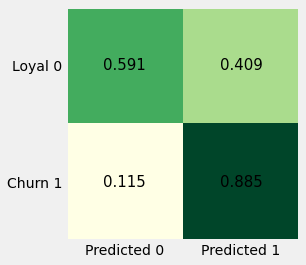

In [437]:
# Fit currently best XGBoost to balanced filtered data
xgb_eqf = XGBClassifier(grow_policy='lossguide', learning_rate=0.16, max_delta_step = 1, max_depth=8,
                            scale_pos_weight=5, n_estimators=100,\
                            random_state=0).fit(X_train_eqf, y_train_eq)
print("Balanced filtered data scores:")
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test_eqf, y_test_eq, xgb_eqf, prnt=True)
tn,fp,fn,tp = confusion_matrix_plot(y_test_eq, y_pred_eq) # Apply to the balanced filtered dataset

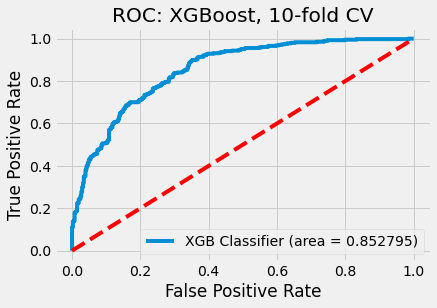

In [438]:
# Receiver Operating Characteristic Curve: balanced filtered data
y_pred_prob = xgb_eqf.predict_proba(X_test_eqf)[:,1]
fpr, tpr, thresh = roc_curve(y_test_eq, y_pred_prob, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='XGB Classifier (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title(f'ROC: XGBoost, 10-fold CV')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC_Balanced')
plt.show();

Entire unbalanced data scores:
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.938541	0.700272	0.677801	0.960784	0.204593	0.337349	0.357042
[[TN, FP], [FN, TP]] =
 [[3206 1524]
 [  16  392]]


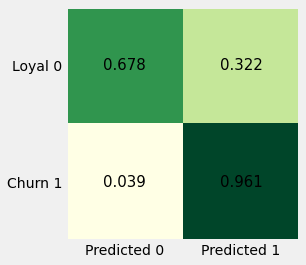

In [439]:
# Scores of optimized XGBoost when applied to entire unbalanced data
print("Entire unbalanced data scores:")
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test[features_f], y_test, xgb_eqf, prnt=True)

y_pred = xgb_eqf.predict(X_test[features_f])
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)

There is a noticeable improvement in TP.

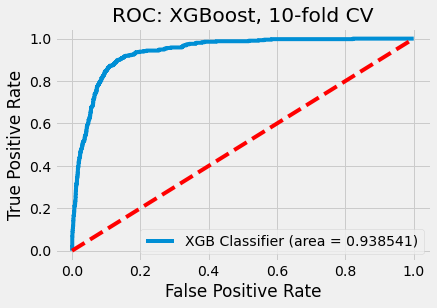

In [440]:
y_pred_prob = xgb_eqf.predict_proba(X_test[features_f])[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob, pos_label=1, drop_intermediate=False)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, linestyle='-', label='XGB Classifier (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title(f'ROC: XGBoost, 10-fold CV')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC_AllData')
plt.show();

In [447]:
#print(bp)
param_grid = {'learning_rate': [0.16], \
              'max_depth': [8], \
              'scale_pos_weight': [5], \
              'max_delta_step': [1], \
              'grow_policy':['lossguide'],\
              'random_state':[0]}

In [448]:
clf = BayesSearchCV(estimator=xgb_eqf, n_iter=1, search_spaces=param_grid, scoring='roc_auc', cv=10, return_train_score=True, verbose=0)
clf.fit(X_train[features_f], y_train)  # fit XGBoost to the entire unbalanced dataset

# Scores
scores_xgb = pd.DataFrame(clf.cv_results_) # dataframe of scores for the entire grid
bp = clf.best_params_ #best parameters
print("Best parameters:\n",bp)
bs = clf.best_score_ # best score
print("Best ROC AUC:",bs)
# Best record:
scores_xgb_opt = scores_xgb.loc[scores_xgb['rank_test_score']==1].drop(['params','rank_test_score'],axis=1)\
    .filter(regex='^((?!time).)*$').filter(regex='^((?!split).)*$') # exclude columns with 'time' and 'split' in the names
#https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe
print("Best record:\n", scores_xgb_opt)
# Table of best hyperparameters
#scores_xgb_table(scores_xgb_opt)

Best parameters:
 OrderedDict([('grow_policy', 'lossguide'), ('learning_rate', 0.16), ('max_delta_step', 1), ('max_depth', 8), ('random_state', 0), ('scale_pos_weight', 5)])
Best ROC AUC: 0.8648889889544873
Best record:
    mean_test_score  std_test_score  mean_train_score  std_train_score  \
0         0.864889        0.020647          0.997358         0.000119   

  param_grow_policy  param_learning_rate  param_max_delta_step  \
0         lossguide                 0.16                     1   

   param_max_depth  param_random_state  param_scale_pos_weight  \
0                8                   0                       5   

   rank_train_score  
0                 1  


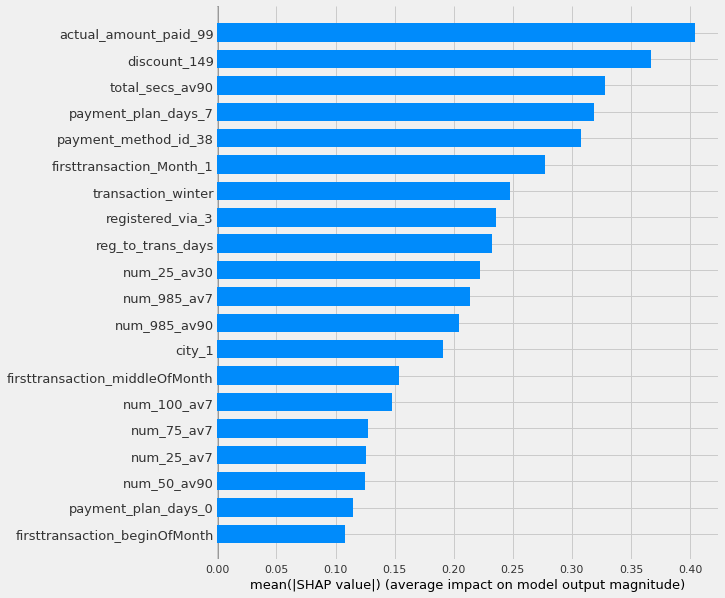

In [412]:
# SHAP for balanced filtered data
shap_values = shap.TreeExplainer(xgb_eqf).shap_values(X_train_eqf)
shap.summary_plot(shap_values, X_train_eqf, plot_type="bar")

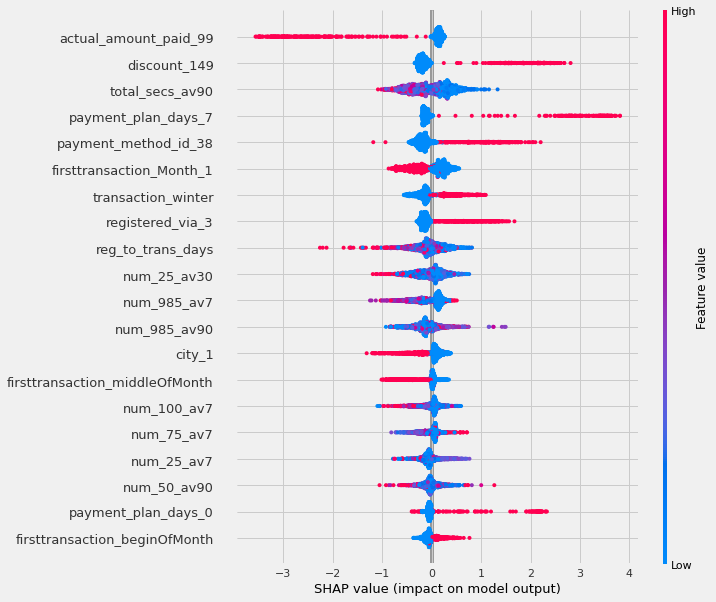

In [416]:
shap.summary_plot(shap_values, X_train_eqf)

Most important predictor is whether the transaction amount was $99: if not, then it is likely to be a churn. Next in importance is payment method: if its id is 38, then a likely churn.

Note that the most influential feature, `is_cancel`, was filtered as having a too high information value.

Next, compare the feature importance for the entire dataset below. 

SHAP values for the entire unbalanced data


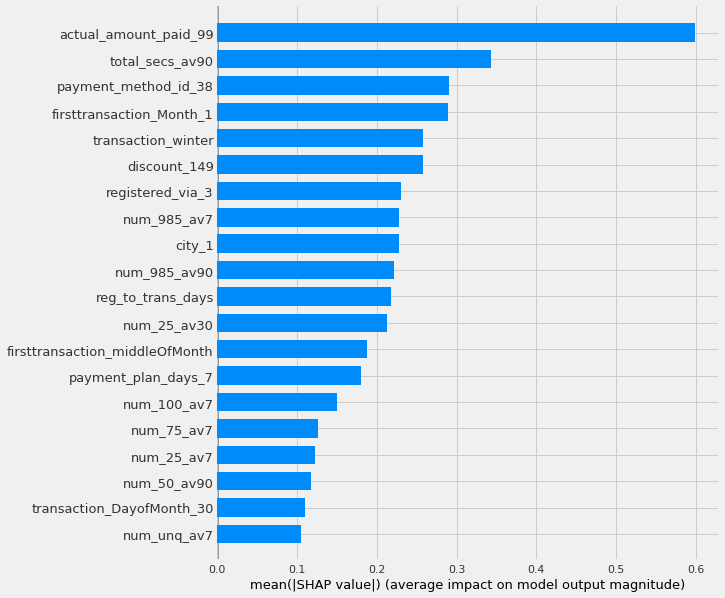

In [449]:
print("SHAP values for the entire unbalanced data")
shap_values = shap.TreeExplainer(xgb_eqf).shap_values(X_train[features_f])
shap.summary_plot(shap_values, X_train[features_f], plot_type="bar")

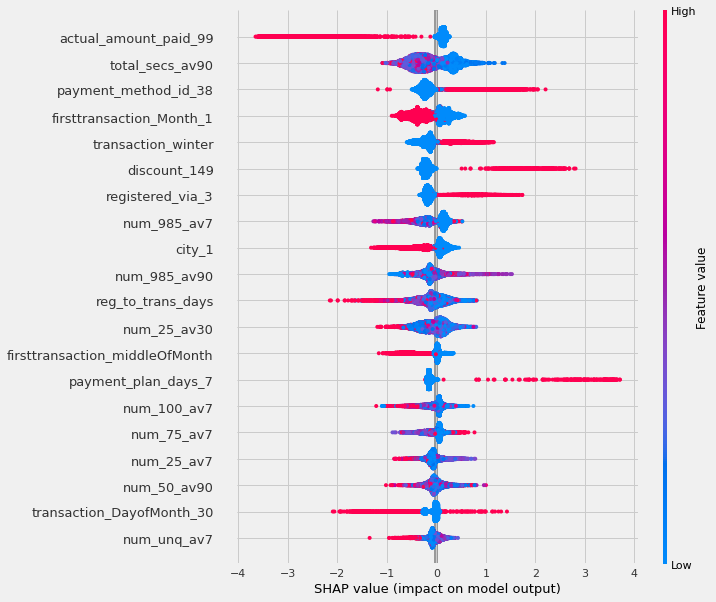

In [450]:
shap.summary_plot(shap_values, X_train[features_f])

#### Balanced churn set

| Model | Test data | ROC-AUC_CV10 | STD_AUC | ROC-AUC | Accuracy | TNR | TPR | Precision | F1 | MCC |
|:------|:----------|:-------------|:-------:|:-------:|:--------:|:---:|:---:|:---------:|:--:|:---:|
| XGBoost | Entire | 0.864889|0.020647|0.938541|0.700272|0.677801|0.960784|0.204593|0.337349|0.357042|0.357042|
| XGBoost | Balanced, filtered |0.859818|0.019658|0.852795|0.761378|0.660099|0.862408|0.717791|0.783482|0.533611|
| Random Forest |
| Logistic Regression|
| Decision Tree|

Balancing the number of churn records with non-churn helps increase ROC AUC score. Needs testing for a larger dataset.

### 7 More than one transaction per member
Now let's introduce features in cases when a member had more than one transaction. Due to the dependence of the number of features on the number of transactions, we have to keep the number of transactions fixed. Consider 2 transactions per member. All members with only 1 transaction are disregarded, and only two first transactions are kept for all others.

In [ ]:
# Select only first `n_trans` transaction for each member
n_trans=1
mt_cutn = pd.DataFrame({'msno':[],'city':[],'bd':[],'gender':[],'registered_via':[],'registration_init_time':[],'payment_method_id':[],'payment_plan_days':[],'plan_list_price':[],'actual_amount_paid':[],'is_auto_renew':[],'transaction_date':[],'membership_expire_date':[],'is_cancel':[],'discount':[],'is_churn':[]})
for member_id in member_list:
    member_transactions = mt_cut.loc[mt_cut['msno'] == member_id]
    if len(member_transactions) >= n_trans:
        tr = member_transactions.head(n_trans)
        #mt_cut1.loc[len(mt_cut1.index)] = [tr['msno'],tr['city'].iloc[0],0,0,0,0,0,0,0,0,0,0,0,0,0]n
        mt_cutn = mt_cutn.append(tr, ignore_index = True)
print(mt_cutn.shape)
mt_cutn.head()

In [ ]:
df = mt_cutn.drop(['msno','plan_list_price','registration_init_time','transaction_date','membership_expire_date'],axis=1)
print(df.shape)
df.head()

In [ ]:
print("Reshape features to have one row per member")
# Column names for all features in all transactions
columns = list(['city','bd','gender','registered_via'])
for i in range(1,n_trans+1):
    for col in ['payment_method_id','payment_plan_days','actual_amount_paid','is_auto_renew','is_cancel','discount']:
        columns.append(col+str(i))
columns.append('is_churn')
print(columns)
mt_cutn = pd.DataFrame(columns=columns)
for i in range(df.shape[0]//n_trans): # members
    tr_all = df.iloc[i * n_trans, 0:4] # common columns for all transactions
    for t in range(n_trans):
        tr_all = np.concatenate((tr_all, df.iloc[i * n_trans + t, 4:10]), axis=0)
    tr_all = np.concatenate((tr_all, df.iloc[(i+1) * n_trans - 1, 10:11]), axis=0)
    tr_all = pd.DataFrame(tr_all, index=columns).transpose()
    mt_cutn = mt_cutn.append(tr_all)
mt_cutn.head()

#### One-hot encoding

In [ ]:
mt_cutn_onehot = pd.get_dummies(mt_cutn, drop_first=False, columns=mt_cutn.columns.drop('is_churn'))
print("No. of predictors:", mt_cutn_onehot.shape[1]-1)
mt_cutn_onehot.head()

In [ ]:
X = mt_cutn_onehot.loc[mt_cutn_onehot['is_churn'] != 2].drop('is_churn', axis=1) # drop unknown churn
print(X.head())
y = mt_cutn_onehot.loc[mt_cutn_onehot['is_churn'] != 2, ['is_churn']]
y = np.ravel(y)
y[:5]

## Suggestions and insights
### 1. Improve data collection
* Collection of transaction and usage log information needs an enforcement of value completeness: 23.48% of members have missing transactions and usage logs, 21.69% of members do not have usage logs, 19.15% of members with transaction information have no membership information. For more details on missing records, see Venn diagram.
* Membersip information suffers from high rate 66.93% of missing gender. This value should be made mandatory.
* Channels of data collection 3, 4, 7, and 9 need an improvement: 64.76% of all records acquired via these channels have missing gender.

### 2. Factors responsible for most churn
* Payment plan is only for 7 days:<br>
From the root node of the decision tree, we can see that the proportion of churn in all data till 2016/10/22 is 946/11040=0.078925. Following the 'False' branch to the right that corresponds to the group of transactions with payment plan for only 7 days, this proportion increases to 125/181 = 0.69061.

* Number of songs played in full last week:<br>
The next important characteristic to consider is the number of songs played in full last week: following the 'True' branch downwards, we see that the churn rate increases to 0.848 in a group with standardized value z <= -0.407, which corresponds to $\le 5.28$ songs (derived using $\mu=18.7486511, \sigma=33.0927287, z = -0.407, x = \mu+z\cdot\sigma = 5.27991$).

* Payment method id is 38:<br>
Following the next 'True' branch downwards, the most decisive feature is payment method id being 38. If it is 38, then the proportion of churn is 103/117=0.88034.

### 3. Technical notes
* Logistic Regression Classifier strongly benefits from standardization of input data: all solvers converge faster and some converge to a higher value.
* Decision tree models do not require scaling.
### 4. Future directions
* Compare min-max scaling with standardization for logistic regression.
* Improve predictions by grouping members with the same number of transactions. This will allow to collect more detailed information on product usage: all values vs averaged over the week, month, and 90 days.
* Try other models, such as SVM (SVC()), KNN (KNeighborsClassifier()), LinearDiscriminantAnalysis(), GaussianNB().

In [426]:
106/125

0.848

In [428]:
X_train.columns[38]

'payment_plan_days_7'